<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURUSD/EURUSD_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURUSD"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-07-25 03:23:46,092 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-07-25 03:23:46,093 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2019-07-25 03:24:50,356 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-07-25 03:27:48,514 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-07-25 03:29:03,466 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-07-25 03:30:09,041 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-07-25 03:31:17,520 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-07-25 03:32:20,490 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-07-25 03:33:42,185 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-07-25 03:35:07,185 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-07-25 03:39:52,757 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_EURUSD__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-EURUSD__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-EURUSD to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close        Volume
Date                                                                 
2018-01-01 22:00:00  1.20102  1.20166  1.20007  1.20136   1687.290039
2018-01-01 23:00:00  1.20137  1.20158  1.20026  1.20106   6885.930176
2018-01-02 00:00:00  1.20105  1.20177  1.20092  1.20160   4362.529785
2018-01-02 01:00:00  1.20159  1.20231  1.20139  1.20154   5860.189941
2018-01-02 02:00:00  1.20153  1.20163  1.20078  1.20095   6161.259766
...                      ...      ...      ...      ...           ...
2018-12-31 18:00:00  1.14515  1.14549  1.14424  1.14452  11589.769531
2018-12-31 19:00:00  1.14452  1.14563  1.14446  1.14534   8138.859863
2018-12-31 20:00:00  1.14536  1.14612  1.14536  1.14561   5789.660156
2018-12-31 21:00:00  1.14560  1.14674  1.14560  1.14644   4643.330078
2018-12-31 22:00:00  1.14644  1.14644  1.14627  1.14627      5.250000

[6221 rows x 5 columns]

Open         High          Low        Close         Volume
count  6221.000000  6221.000000  6221.000000  6221.000000    6221.000000
mean      1.181234     1.182019     1.180465     1.181227   10596.013672
std       0.036889     0.036928     0.036841     0.036890    5908.182617
min       1.121740     1.122470     1.121560     1.121770       5.250000
25%       1.152390     1.153310     1.151610     1.152380    6075.970215
50%       1.169200     1.169930     1.168530     1.169190   10352.379883
75%       1.223890     1.224710     1.223120     1.223900   14169.230469
max       1.254880     1.255530     1.254320     1.254880  146464.656250

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close        Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  1.20108  1.20114  1.20044  1.20099   5588.620117    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  1.201299  1.192468 -1.202362  1.200910  1.201507  1.202422    1.201850    1.201630  1.202463  1.201598  1.200892  1.201491  1.201296  1.201598  1.201037  1.202684                1.202934                 1.201598                1.200261                1.203602                 1.201598                1.199593                1.204270                 1.201598                1.198925                1.204938                 1.201598                1.198257  1.201507  1.201088  1.202518                1.202843                 1.201507                1.200171                1.203511                 1.201507                1.199503                1.204179                 1.201507                1.198834                1.204847                 1.201507   
2018-01-04 01:00:00  1.20099  1.20109  1.20048  1.20077   5328.490234    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  1.201273  1.192688 -1.202137  1.200751  1.201343  1.201897    1.201735    1.201550  1.202275  1.201355  1.200742  1.201272  1.201112  1.201355  1.200880  1.202518                1.202484                 1.201355                1.200226                1.203048                 1.201355                1.199662                1.203612                 1.201355                1.199098                1.204177                 1.201355                1.198533  1.201343  1.200856  1.202349                1.202472                 1.201343                1.200215                1.203036                 1.201343                1.199650                1.203600                 1.201343                1.199086                1.204165                 1.201343   
2018-01-04 02:00:00  1.20078  1.20190  1

Open         High          Low        Close         Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6171.000000  6171.000000  6171.000000  6171.000000    6171.000000  6171.000000  6171.000000  6171.000000    6171.000000  6171.000000   6171.000000     6171.000000     6171.000000       6171.000000  6171.000000  6171.000000  6171.000000  6171.000000   6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000  6171.000000  6171.000000  6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000   
mean      1.181053     1.181839     1.180282     1.181046   10616.937500    15.902609     2.051693   183.856101      30.440285    11.490682      0.034516        0.972290        0.004213          0.995139     6.548533     2.520013    26.635391     2.051693      2.029331    26.635391     1.181082     1.181157    -0.003760     1.181044     1.181077     1.181025     1.181076     1.181098     1.181143     1.181076     1.181045     1.181076     1.181066     1.181076     1.181048     1.181142                1.183161                 1.181076                1.178992                1.184203                 1.181076                1.177949                1.185245                 1.181076                1.176907                1.186288                 1.181076                1.175865     1.181077     1.181050     1.181132                1.183161                 1.181077                1.178992                1.184203                 1.181077                1.177950                1.185246   
std       0.036982     0.037022     0.036934     0.036983    5919.407227     8.726591     1.510123   104.049675       0.844541     6.924977      0.182566        0.164155        0.064778          0.069560     3.410495     1.113078    14.863537     1.510123      1.457985    14.863537     0.036942     0.036854     1.181767     0.036992     0.036945     0.036965     0.036942     0.036930     0.036911     0.036956     0.036988     0.036960     0.036961     0.036956     0.036977     0.036904                0.037069                 0.036956                0.036894                0.037145                 0.036956                0.036883                0.037233                 0.036956                0.036885                0.037334                 0.036956                0.036900     0.036945     0.036973     0.036912                0.037057                 0.036945                0.036885                0.037133                 0.036945                0.036874                0.037221   
min       1.121740     1.122470   

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.595914  0.591237  0.594155  0.595147  0.038122    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.599974  0.536142  0.021210  0.594968  0.602496  0.609852    0.603170    0.604227  0.603889  0.601221  0.592902  0.600274  0.599722  0.601221  0.596689  0.616119                0.591179                 0.601221                0.603620                0.583179                 0.601221                0.607934                0.564262                 0.601221                0.618172                0.546298                 0.601221                0.628564  0.602496  0.596839  0.613868                0.590651                 0.602496                0.606561                0.580740                 0.602496                0.609957                0.566040                 0.602496                0.617216                0.552109                 0.602496   
2018-01-04 01:00:00  0.595238  0.590861  0.594456  0.593494  0.036346    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.599769  0.537906  0.021300  0.593776  0.601236  0.605807    0.602291    0.603613  0.602484  0.599368  0.591774  0.598608  0.598319  0.599368  0.595508  0.614814                0.587790                 0.599368                0.603354                0.579060                 0.599368                0.608453                0.559525                 0.599368                0.619442                0.540983                 0.599368                0.630545  0.601236  0.595090  0.612551                0.587839                 0.601236                0.606896                0.577201                 0.601236                0.611078                0.561844                 0.601236                0.619093                0.547290                 0.601236   
2018-01-04 02:00:00  0.593661  0.596949  

139829

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpd7jz8t9d
  JVM stdout: /tmp/tmpd7jz8t9d/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpd7jz8t9d/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_iq63eq
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.554171  0.725079              0.473716  0.514208  0.264410
1  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.552441  0.758237              0.487541  0.529299  0.280158
2  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.542244  0.690440              0.500000  0.498705  0.248707
3  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.533296  0.744565              0.498276  0.522072  0.272559
4  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.519408  0.693080              0.500000  0.499967  0.249967
5  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.500000  0.692601              0.500000  0.499727  0.249727
6  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.500000  0.693270              0.500000  0.500062  0.250062
7  DeepLearning_grid_1_AutoML_20190725_035538_mod...  0.500000  0.692603              0.500000  0.499723  0.249723
8              DeepLearning_1_AutoML_20190725_035538  0.498471  0.698886              0.500000  0.502041  0.252045

variable  relative_importance  scaled_importance  percentage
0               CORREL_30             1.000000           1.000000    0.002567
1                  SAREXT             0.894468           0.894468    0.002296
2                    hour             0.884685           0.884685    0.002271
3       CDL3WHITESOLDIERS             0.884547           0.884547    0.002270
4            HT_TRENDMODE             0.881565           0.881565    0.002263
...                   ...                  ...                ...         ...
1032       CDLHARAMICROSS             0.281014           0.281014    0.000721
1033          CDLDOJISTAR             0.269910           0.269910    0.000693
1034           CDL3INSIDE             0.268374           0.268374    0.000689
1035       CDL3LINESTRIKE             0.266108           0.266108    0.000683
1036  CDLRISEFALL3METHODS             0.191813           0.191813    0.000492

[1037 rows x 4 columns]

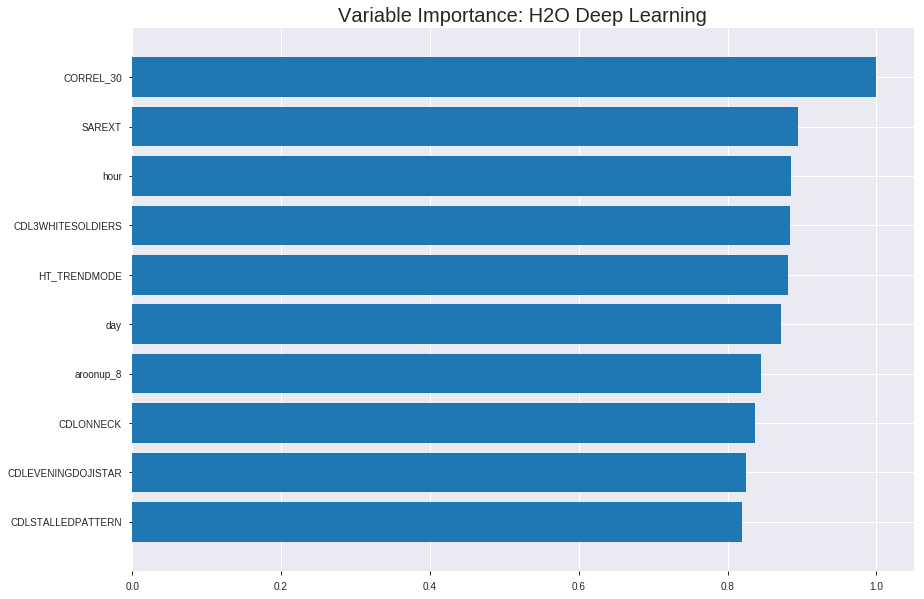

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_035538_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25541445614724806
RMSE: 0.5053854530427722
LogLoss: 0.7058622350435383
Mean Per-Class Error: 0.4593571483711595
AUC: 0.5505124972123583
pr_auc: 0.5389769385809171
Gini: 0.10102499442471657
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14137719860724346: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      7    2153  0.9968   (2153.0/2160.0)
1      0    2159  0        (0.0/2159.0)
Total  7    4312  0.4985   (2153.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.141377     0.667285   393
max f2                       0.141377     0.833719   393
max f0point5                 0.326822     0.558572   332
max accuracy                 0.422858     0.540634   238
max precision                0.913137     0.666667   1
max recall                   0.141377     1          393
max specificity              0.916387     0.999537   0
max absolute_mcc             0.40561      0.0817799  255
max min_per_class_accuracy   0.431446     0.5375     230
max mean_per_class_accuracy  0.422858     0.540643   238

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 44.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.780793           1.0457    1.0457             0.522727         0.852202  0.522727                    0.852202            0.0106531       0.0106531                  4.56967    4.56967
    2        0.0201436                   0.714561           1.07002   1.05772            0.534884         0.743772  0.528736                    0.79861             0.0106531       0.0213062                  7.00152    5.77162
    3        0.0300996                   0.689957           1.30263   1.13873            0.651163         0.702706  0.569231                    0.766888            0.012969        0.0342751                  30.2627    13.8725
    4        0.0400556                   0.66724            1.2561    1.1679             0.627907         0.678869  0.583815                    0.745011            0.0125058       0.0467809                  25.6105    16.79
    5        0.0500116                   0.656006           1.02349   1.13915            0.511628         0.66169   0.569444                    0.728424            0.0101899       0.0569708                  2.34928    13.9153
    6        0.100023                    0.60221            1.11137   1.12526            0.555556         0.625555  0.5625                      0.676989            0.0555813       0.112552                   11.1368    12.5261
    7        0.150035                    0.559585           1.13915   1.12989            0.569444         0.57914   0.564815                    0.644373            0.0569708       0.169523                   13.9153    12.9891
    8        0.200046                    0.531007           1.12989   1.12989            0.564815         0.544691  0.564815                    0.619453            0.0565076       0.226031                   12.9891    12.9891
    9        0.300069                    0.489788           1.03728   1.09902            0.518519         0.50979   0.549383                    0.582898            0.103752        0.329782                   3.72772    9.90199
    10       0.400093                    0.456776           1.03728   1.08358            0.518519         0.472011  0.541667                    0.555177            0.103752        0.433534                   3.72772    8.35842
    11       0.500116                    0.431356           1.0558    1.07803            0.527778         0.443521  0.538889                    0.532845            0.105604        0.539138                   5.58       7.80274
    12       0.599907                    0.408697           0.951496  1.05698            0.475638         0.419249  0.528367                    0.513949            0.0949514       0.63409                    -4.85036   5.69796
    13       0.699931                    0.385947           1.00023   1.04887            0.5              0.39742   0.524314                    0.497297            0.100046        0.734136                   0.0231589  4.887
    14       0.799954                    0.361191           0.907618  1.03121            0.453704         0.374037  0.515485                    0.481885            0.0907828       0.824919                   -9.23824   3.12084
    15       0.899977                    0.330257           0.893725  1.01593            0.446759         0.347465  0.507847                    0.466945            0.0893932       0.914312                   -10.6275   1.59286
    16       1                           0.0640317          0.85668   1                  0.428241         0.293731  0.499884                    0.44



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2617542693179198
RMSE: 0.5116192620669395
LogLoss: 0.7190606741362326
Mean Per-Class Error: 0.47086961661215965
AUC: 0.5256550691516608
pr_auc: 0.5212086575075486
Gini: 0.05131013830332165
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13339166239898437: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    615   0        (0.0/615.0)
Total  1    1233  0.5008   (618.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.133392     0.665584   398
max f2                       0.133392     0.832656   398
max f0point5                 0.260669     0.556181   368
max accuracy                 0.388625     0.528363   258
max precision                0.818133     1          0
max recall                   0.133392     1          398
max specificity              0.818133     1          0
max absolute_mcc             0.690519     0.0705467  25
max min_per_class_accuracy   0.439112     0.512116   209
max mean_per_class_accuracy  0.366493     0.52913    282

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 45.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.729423           1.23477   1.23477            0.615385         0.756088  0.615385                    0.756088            0.0130081       0.0130081                  23.4772    23.4772
    2        0.0202593                   0.702427           1.33767   1.28416            0.666667         0.714466  0.64                        0.736109            0.0130081       0.0260163                  33.7669    28.4163
    3        0.0299838                   0.692296           1.50488   1.35575            0.75             0.695613  0.675676                    0.722975            0.0146341       0.0406504                  50.4878    35.5746
    4        0.0405186                   0.682195           0.926079  1.24403            0.461538         0.688713  0.62                        0.714067            0.0097561       0.0504065                  -7.39212   24.4033
    5        0.0502431                   0.670474           1.00325   1.19743            0.5              0.676456  0.596774                    0.706788            0.0097561       0.0601626                  0.325203   19.743
    6        0.100486                    0.629443           1.00325   1.10034            0.5              0.650648  0.548387                    0.678718            0.0504065       0.110569                   0.325203   10.0341
    7        0.149919                    0.589614           0.822338  1.00868            0.409836         0.60855   0.502703                    0.655581            0.0406504       0.15122                    -17.7662   0.867502
    8        0.200162                    0.562243           1.16507   1.04793            0.580645         0.577117  0.522267                    0.635886            0.0585366       0.209756                   16.5067    4.79313
    9        0.299838                    0.51645            0.995096  1.03037            0.495935         0.53801   0.513514                    0.603349            0.099187        0.308943                   -0.490449  3.0367
    10       0.400324                    0.472021           1.06798   1.03981            0.532258         0.49245   0.518219                    0.575512            0.107317        0.41626                    6.7978     3.98078
    11       0.5                         0.438793           0.978782  1.02764            0.487805         0.454221  0.512156                    0.551332            0.097561        0.513821                   -2.12175   2.76423
    12       0.599676                    0.405057           1.07666   1.03579            0.536585         0.421795  0.516216                    0.529801            0.107317        0.621138                   7.66607    3.57899
    13       0.700162                    0.375859           1.0518    1.03809            0.524194         0.39088   0.517361                    0.509863            0.105691        0.726829                   5.17965    3.80872
    14       0.799838                    0.342839           0.848278  1.01443            0.422764         0.360912  0.505572                    0.491301            0.0845528       0.811382                   -15.1722   1.44332
    15       0.899514                    0.30369            1.01141   1.0141             0.504065         0.325756  0.505405                    0.472957            0.100813        0.912195                   1.14086    1.4098
    16       1                           0.125793           0.8738    1                  0.435484         0.258046  0.498379                    0.


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:03:55  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:03:57  8 min 13.991 sec   409 obs/sec       0.215791  1             932        0.677605         5.76202             -0.836593      0.517685        0.239131           1.09116          0.500116                         0.703442           8.0588                -0.979342        0.50474           0.295883             0.953089           0.5
    2019-07-25 04:04:32  8 min 49.927 sec   434 obs/sec       3.4075    16            14717      0.548643         0.838823            -0.204037      0.51221         0.512225           1.13663          0.500116                         0.636325           1.24469               -0.619655        0.48281           0.48594              0.617386           0.501621
    2019-07-25 04:05:17  9 min 33.245 sec   479 obs/sec       8.20931   38            35456      0.506466         0.70787             -0.0260305     0.513339        0.507933           1.0457           0.498727                         0.519275           0.736883              -0.0785974       0.474107          0.474196             1.08043            0.495948
    2019-07-25 04:05:50  10 min  6.444 sec  512 obs/sec       12.3251   57            53232      0.520095         0.745255            -0.0819967     0.512809        0.507367           0.909301         0.49919                          0.560151           0.861481              -0.255088        0.496844          0.495305             0.926079           0.5
    2019-07-25 04:06:24  10 min 40.985 sec  551 obs/sec       17.2707   80            74592      0.541231         0.807372            -0.171725      0.523673        0.519515           0.954767         0.500116                         0.608871           1.10083               -0.482909        0.495125          0.498862             1.23477            0.501621
    2019-07-25 04:06:57  11 min 13.572 sec  589 obs/sec       22.4561   104           96988      0.520484         0.74572             -0.0836154     0.522444        0.525864           1.18209          0.500116                         0.581569           0.942394              -0.352904        0.47634           0.485903             0.926079           0.501621
    2019-07-25 04:07:29  11 min 46.147 sec  625 obs/sec       28.0785   130           121271     0.505385         0.705862            -0.0216579     0.550512        0.538977           1.0457           0.498495                         0.511619           0.719061              -0.0470281       0.525655          0.521209             1.23477            0.50081
    2019-07-25 04:08:02  12 min 18.710 sec  659 obs/sec       34.1097   158           147320     0.503841         0.704213            -0.0154244     0.546416        0.537294           1.27302          0.49919                          0.513129           0.726479              -0.0532155       0.517789          0.513803             0.926079           0.49919
    2019-07-25 04:08:35 

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ---------------------
CORREL_30            1.0                    1.0                  0.002566838146160939
SAREXT               0.8944675922393799     0.8944675922393799   0.0022959535362647686
hour                 0.8846845030784607     0.8846845030784607   0.0022708419298192277
CDL3WHITESOLDIERS    0.8845471739768982     0.8845471739768982   0.002270489428242759
HT_TRENDMODE         0.881565272808075      0.881565272808075    0.0022628353705745415
---                  ---                    ---                  ---
CDLHARAMICROSS       0.2810142934322357     0.2810142934322357   0.000721318207998326
CDLDOJISTAR          0.2699100375175476     0.2699100375175476   0.0006928153803317713
CDL3INSIDE           0.2683735191822052     0.2683735191822052   0.0006888713864563388
CDL3LINESTRIKE       0.2661084234714508     0.2661084234714508   0.0006830572523812689
CDLRISEFALL3METHODS  0.19181272387504578    0.19181272387504578  0.0004923522165615026


See the whole table with table.as_data_frame()


('accuracy', 0.5559157212317666)

('F1', 0.696035242290749)

('auc', 0.5541706211114626)

('logloss', 0.725079125639146)

('mean_per_class_error', 0.4427343667615733)

('rmse', 0.5142083103989455)

('mse', 0.2644101864833383)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


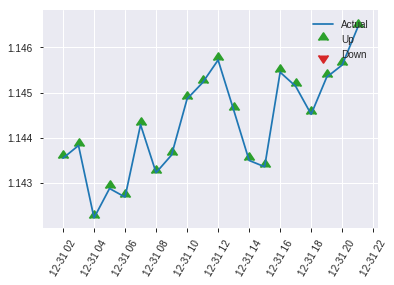


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2644101864833383
RMSE: 0.5142083103989455
LogLoss: 0.725079125639146
Mean Per-Class Error: 0.4427343667615733
AUC: 0.5541706211114626
pr_auc: 0.5785238792388201
Gini: 0.1083412422229253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24725541196123405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   265  0.9138   (265.0/290.0)
1      11   316  0.0336   (11.0/327.0)
Total  36   581  0.4473   (276.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.247255     0.696035  369
max f2                       0.115972     0.849351  399
max f0point5                 0.266935     0.597044  354
max accuracy                 0.282242     0.555916  342
max precision                0.737761     1         0
max recall                   0.115972     1         399
max specificity              0.737761     1         0
max absolute_mcc             0.476054     0.125753  136
max min_per_class_accuracy   0.398361     0.531034  217
max mean_per_class_accuracy  0.476054     0.557266  136

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 41.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.695159           1.34775   1.34775            0.714286         0.710081  0.714286                    0.710081            0.0152905       0.0152905                  34.775    34.775
    2        0.0210697                   0.673985           1.57238   1.45142            0.833333         0.681524  0.769231                    0.696901            0.0152905       0.030581                   57.2375   45.1423
    3        0.0307942                   0.658854           0.943425  1.291              0.5              0.66564   0.684211                    0.687029            0.00917431      0.0397554                  -5.65749  29.1003
    4        0.0405186                   0.641893           1.2579    1.28306            0.666667         0.648772  0.68                        0.677847            0.0122324       0.0519878                  25.79     28.3058
    5        0.0502431                   0.623395           1.2579    1.27819            0.666667         0.633213  0.677419                    0.669209            0.0122324       0.0642202                  25.79     27.8189
    6        0.100486                    0.57897            0.912992  1.09559            0.483871         0.603825  0.580645                    0.636517            0.0458716       0.110092                   -8.7008   9.55904
    7        0.150729                    0.550152           1.03472   1.0753             0.548387         0.565393  0.569892                    0.612809            0.0519878       0.16208                    3.47243   7.53017
    8        0.200972                    0.515601           1.15646   1.09559            0.612903         0.529419  0.580645                    0.591961            0.058104        0.220183                   15.6457   9.55904
    9        0.299838                    0.473271           1.29914   1.16271            0.688525         0.497351  0.616216                    0.560765            0.12844         0.348624                   29.9143   16.2708
    10       0.400324                    0.431908           0.821693  1.07711            0.435484         0.450367  0.57085                     0.533054            0.0825688       0.431193                   -17.8307  7.71088
    11       0.50081                     0.398844           0.973858  1.05639            0.516129         0.415871  0.559871                    0.509542            0.0978593       0.529052                   -2.61419  5.63918
    12       0.599676                    0.368753           0.989823  1.04542            0.52459          0.384683  0.554054                    0.488957            0.0978593       0.626911                   -1.0177   4.5417
    13       0.700162                    0.340383           1.03472   1.04388            0.548387         0.355655  0.553241                    0.469826            0.103976        0.730887                   3.47243   4.38824
    14       0.799028                    0.31547            0.927959  1.02954            0.491803         0.328041  0.545639                    0.452282            0.0917431       0.82263                    -7.20409  2.95389
    15       0.899514                    0.268787           1.03472   1.03012            0.548387         0.294482  0.545946                    0.434654            0.103976        0.926606                   3.47243   3.01182
    16       1                           0.115972           0.730394  1                  0.387097         0.238198  0.529984                    0.414913           

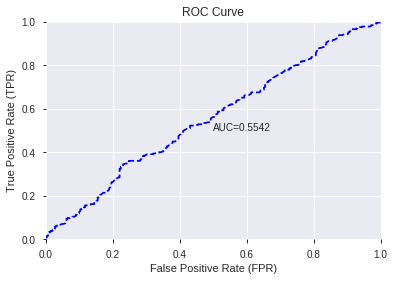

This function is available for GLM models only


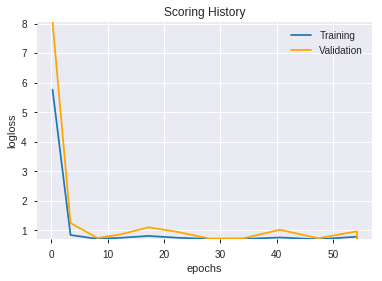

--2019-07-25 04:55:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_035538_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_035538_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_045652_model_7  0.546346  0.757478              0.500000  0.520203  0.270611
1  DeepLearning_grid_1_AutoML_20190725_045652_model_6  0.539666  0.693430              0.492908  0.499711  0.249711
2  DeepLearning_grid_1_AutoML_20190725_045652_model_4  0.514769  0.775740              0.500000  0.526613  0.277322
3  DeepLearning_grid_1_AutoML_20190725_045652_model_5  0.511542  0.707225              0.492713  0.505637  0.255669
4  DeepLearning_grid_1_AutoML_20190725_045652_model_8  0.510271  0.695525              0.500000  0.501187  0.251188
5  DeepLearning_grid_1_AutoML_20190725_045652_model_3  0.509986  0.743414              0.500000  0.514923  0.265146
6               DeepLearning_1_AutoML_20190725_045652  0.502958  0.721183              0.486761  0.512153  0.262301
7  DeepLearning_grid_1_AutoML_20190725_045652_model_9  0.501345  0.691348              0.500000  0.499100  0.249101
8  DeepLearning_grid_1_AutoML_20190725_045652_model_2  0.498608  0.816616              0.500000  0.535658  0.286929
9  DeepLearning_grid_1_AutoML_20190725_045652_model_1  0.492624  1.000265              0.500000  0.566250  0.320639

variable  relative_importance  scaled_importance  percentage
0                   day             1.000000           1.000000    0.021919
1        STOCHRSI_fastk             0.988744           0.988744    0.021672
2                  hour             0.971153           0.971153    0.021287
3             aroonup_8             0.970200           0.970200    0.021266
4             CORREL_24             0.967655           0.967655    0.021210
5           HT_DCPERIOD             0.962113           0.962113    0.021088
6                SAREXT             0.960976           0.960976    0.021063
7            aroonup_30             0.960374           0.960374    0.021050
8        is_month_start             0.955485           0.955485    0.020943
9            aroonup_12             0.949307           0.949307    0.020808
10         HT_TRENDMODE             0.947135           0.947135    0.020760
11         is_month_end             0.946856           0.946856    0.020754
12         weekday_name             0.941409           0.941409    0.020635
13           aroonup_24             0.940391           0.940391    0.020612
14         CDLSHORTLINE             0.939820           0.939820    0.020600
15          aroondown_8             0.936235           0.936235    0.020521
16         aroondown_24             0.932098           0.932098    0.020430
17            CDLONNECK             0.927901           0.927901    0.020339
18    CDLINVERTEDHAMMER             0.926782           0.926782    0.020314
19                  BOP             0.923220           0.923220    0.020236
20         aroondown_20             0.921075           0.921075    0.020189
21   CDLEVENINGDOJISTAR             0.920884           0.920884    0.020185
22         aroondown_12             0.919741           0.919741    0.020160
23      CDLHOMINGPIGEON             0.915631           0.915631    0.020070
24    CDLGRAVESTONEDOJI             0.914746           0.914746    0.020050
25         aroondown_14             0.910896           0.910896    0.019966
26           aroonup_14             0.910431           0.910431    0.019956
27            CDLTAKURI             0.909884           0.909884    0.019944
28            CDLHAMMER             0.908313           0.908313    0.019909
29            CDLINNECK             0.905125           0.905125    0.019839
30     is_quarter_start             0.903770           0.903770    0.019810
31      CDLUNIQUE3RIVER             0.903134           0.903134    0.019796
32           aroonup_20             0.901096           0.901096    0.019751
33          CDLPIERCING             0.897098           0.897098    0.019663
34      CDLADVANCEBLOCK             0.896068           0.896068    0.019641
35   CDLMORNINGDOJISTAR             0.890832           0.890832    0.019526
36      CDLSHOOTINGSTAR             0.886512           0.886512    0.019431
37            CORREL_30             0.884281           0.884281    0.019382
38       CDLMORNINGSTAR             0.880758           0.880758    0.019305
39    CDL3WHITESOLDIERS             0.875900           0.875900    0.019199
40    CDLSTALLEDPATTERN             0.874044           0.874044    0.019158
41             CORREL_8             0.867192           0.867192    0.019008
42       CDLMATCHINGLOW             0.864499           0.864499    0.018949
43       CDLRICKSHAWMAN             0.862844           0.862844    0.018913
44       CDLEVENINGSTAR             0.855731           0.855731    0.018757
45  CDLGAPSIDESIDEWHITE             0.847117           0.847117    0.018568
46    CDLDARKCLOUDCOVER             0.843461           0.843461    0.018488
47         CDLTHRUSTING             0.836550           0.836550    0.018336
48       CDL3BLACKCROWS             0.834750           0.834750    0.018297
49   CDLIDENTICAL3CROWS             0.832652           0.832652    0.018251

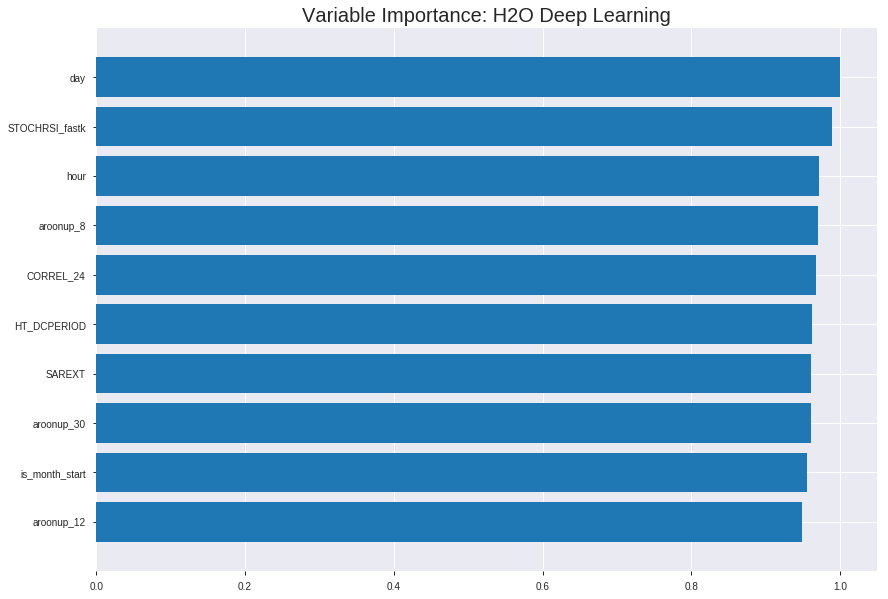

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_045652_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23539129535290518
RMSE: 0.48517140821868837
LogLoss: 0.6620861705406469
Mean Per-Class Error: 0.40033440979191326
AUC: 0.6420418189147925
pr_auc: 0.6365247719516304
Gini: 0.284083637829585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2980959330669723: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      293  1867  0.8644   (1867.0/2160.0)
1      57   2102  0.0264   (57.0/2159.0)
Total  350  3969  0.4455   (1924.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298096     0.686031  316
max f2                       0.122648     0.837358  368
max f0point5                 0.395131     0.597851  264
max accuracy                 0.428833     0.599676  233
max precision                0.999128     1         0
max recall                   0.0517663    1         386
max specificity              0.999128     1         0
max absolute_mcc             0.347334     0.205635  295
max min_per_class_accuracy   0.415525     0.590741  245
max mean_per_class_accuracy  0.427842     0.599666  234

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 46.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.960809           1.8186    1.8186             0.909091         0.980176  0.909091                    0.980176            0.0185271       0.0185271                  81.8603   81.8603
    2        0.0201436                   0.918835           1.67481   1.74753            0.837209         0.93848   0.873563                    0.959567            0.0166744       0.0352015                  67.4806   74.7531
    3        0.0300996                   0.882449           1.81437   1.76964            0.906977         0.898609  0.884615                    0.939404            0.0180639       0.0532654                  81.4374   76.9641
    4        0.0400556                   0.846779           1.62828   1.73451            0.813953         0.863405  0.867052                    0.920514            0.0162112       0.0694766                  62.8284   73.4506
    5        0.0500116                   0.818934           1.11654   1.61148            0.55814          0.832624  0.805556                    0.903018            0.0111163       0.0805929                  11.6538   61.1484
    6        0.100023                    0.688086           1.27807   1.44478            0.638889         0.75052   0.722222                    0.826769            0.0639185       0.144511                   27.8074   44.4779
    7        0.150035                    0.619816           1.26881   1.38612            0.634259         0.649596  0.692901                    0.767711            0.0634553       0.207967                   26.8812   38.6123
    8        0.200046                    0.570007           1.25029   1.35216            0.625            0.593767  0.675926                    0.724225            0.0625289       0.270496                   25.0289   35.2165
    9        0.300069                    0.498977           1.10674   1.27036            0.553241         0.531554  0.635031                    0.660001            0.110699        0.381195                   10.6738   27.0356
    10       0.400093                    0.44829            1.10674   1.22945            0.553241         0.471661  0.614583                    0.612916            0.110699        0.491894                   10.6738   22.9451
    11       0.500116                    0.415282           1.01875   1.18731            0.509259         0.430124  0.593519                    0.576358            0.101899        0.593793                   1.87544   18.7312
    12       0.72401                     0.396594           0.972304  1.12082            0.486039         0.400042  0.560281                    0.521834            0.217693        0.811487                   -2.76963  12.0822
    13       0.799954                    0.388455           0.896549  1.09953            0.448171         0.394174  0.549638                    0.509714            0.0680871       0.879574                   -10.3451  9.9531
    14       0.899977                    0.318944           0.773327  1.06328            0.386574         0.361975  0.531515                    0.493295            0.0773506       0.956925                   -22.6673  6.32768
    15       1                           0.000553636        0.430655  1                  0.215278         0.195331  0.499884                    0.463492            0.0430755       1                          -56.9345  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2723679416484056
RMSE: 0.5218888211567725
LogLoss: 0.7605077554222445
Mean Per-Class Error: 0.4687418732022538
AUC: 0.5228141376728792
pr_auc: 0.5184777121734615
Gini: 0.04562827534575842
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.008920908183342614: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    615   0        (0.0/615.0)
Total  0    1234  0.5016   (619.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00892091   0.665224   399
max f2                       0.00892091   0.832431   399
max f0point5                 0.00892091   0.553954   399
max accuracy                 0.449591     0.531605   222
max precision                0.997105     1          0
max recall                   0.00892091   1          399
max specificity              0.997105     1          0
max absolute_mcc             0.449591     0.0639977  222
max min_per_class_accuracy   0.413575     0.523577   254
max mean_per_class_accuracy  0.449591     0.531258   222

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 46.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.946068           1.23477   1.23477            0.615385         0.977286  0.615385                    0.977286            0.0130081       0.0130081                  23.4772   23.4772
    2        0.0202593                   0.89799            1.17046   1.2039             0.583333         0.922592  0.6                         0.951033            0.0113821       0.0243902                  17.0461   20.3902
    3        0.0299838                   0.865899           1.17046   1.19306            0.583333         0.879003  0.594595                    0.927672            0.0113821       0.0357724                  17.0461   19.3056
    4        0.0405186                   0.831064           0.617386  1.04338            0.307692         0.847958  0.52                        0.906946            0.00650407      0.0422764                  -38.2614  4.33821
    5        0.0502431                   0.806472           1.33767   1.10034            0.666667         0.819682  0.548387                    0.890056            0.0130081       0.0552846                  33.7669   10.0341
    6        0.100486                    0.711353           1.10034   1.10034            0.548387         0.755097  0.548387                    0.822577            0.0552846       0.110569                   10.0341   10.0341
    7        0.149919                    0.63768            0.953912  1.05206            0.47541          0.674345  0.524324                    0.7737              0.0471545       0.157724                   -4.60882  5.20589
    8        0.200162                    0.573861           1.06798   1.05605            0.532258         0.605431  0.526316                    0.731463            0.0536585       0.211382                   6.7978    5.60548
    9        0.299838                    0.503001           0.929843  1.0141             0.463415         0.536634  0.505405                    0.666695            0.0926829       0.304065                   -7.01567  1.4098
    10       0.400324                    0.445989           1.26216   1.07636            0.629032         0.471233  0.536437                    0.617632            0.126829        0.430894                   26.2156   7.63635
    11       0.5                         0.412294           0.929843  1.04715            0.463415         0.428055  0.52188                     0.579839            0.0926829       0.523577                   -7.01567  4.71545
    12       0.712318                    0.396594           0.919009  1.00896            0.458015         0.39983   0.502844                    0.526185            0.195122        0.718699                   -8.09905  0.895881
    13       0.799838                    0.388991           1.00325   1.00833            0.5              0.394694  0.502533                    0.511797            0.0878049       0.806504                   0.325203  0.833436
    14       0.899514                    0.325384           0.978782  1.00506            0.487805         0.364592  0.500901                    0.495485            0.097561        0.904065                   -2.12175  0.505969
    15       1                           0.00892091         0.954708  1                  0.475806         0.221056  0.498379                    0.467908            0.095935        1                          -4.52924  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:04:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:04:52  8.521 sec         250 obs/sec       0.306089  1             1322       0.631914         1.30803             -0.597259      0.529446        0.521941           1.00023          0.500116                         0.6283             1.29631               -0.579059        0.520123          0.520075             1.38912            0.501621
    2019-07-25 05:05:25  41.741 sec        590 obs/sec       4.837     16            20891      0.512315         0.719737            -0.0498684     0.59598         0.601425           1.8186           0.465849                         0.530936           0.766837              -0.127585        0.49257           0.504557             1.23477            0.50081
    2019-07-25 05:05:58  1 min 14.606 sec  661 obs/sec       9.96689   33            43047      0.485171         0.662086            0.0584348      0.642042        0.636525           1.8186           0.445473                         0.521889           0.760508              -0.0894832       0.522814          0.518478             1.23477            0.501621
    2019-07-25 05:06:31  1 min 47.309 sec  703 obs/sec       15.4279   51            66633      0.524167         0.761284            -0.0990038     0.673358        0.674357           1.955            0.420931                         0.568714           0.913624              -0.293758        0.503373          0.494615             1.23477            0.493517
    2019-07-25 05:07:02  2 min 18.179 sec  736 obs/sec       20.8868   69            90210      0.482377         0.65203             0.0692512      0.725895        0.731877           1.955            0.384117                         0.548854           0.854116              -0.204976        0.519634          0.510772             1.08043            0.501621
    2019-07-25 05:07:33  2 min 49.772 sec  761 obs/sec       26.6409   88            115062     0.502837         0.709309            -0.0113818     0.76346         0.754588           2.00046          0.344756                         0.578517           0.983832              -0.338742        0.505252          0.504843             1.08043            0.501621
    2019-07-25 05:08:04  3 min 20.481 sec  782 obs/sec       32.4066   107           139964     0.446059         0.570361            0.204127       0.799929        0.795847           2.00046          0.303079                         0.561357           0.916992              -0.260502        0.514403          0.514382             1.38912            0.5
    2019-07-25 05:08:07  3 min 23.706 sec  782 obs/sec       32.4066   107           139964     0.485171         0.662086            0.0584348      0.642042        0.636525           1.8186           0.445473                         0.521889           0.760508              -0.0894832       0.522814          0.518478             1.23477            0.501621

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
day                  1.0                    1.0                  0.02191883096941299
STOCHRSI_fastk       0.9887443780899048     0.9887443780899048   0.021672120895309992
hour                 0.9711533188819885     0.9711533188819885   0.02128654544195874
aroonup_8            0.9702001810073853     0.9702001810073853   0.021265653773994767
CORREL_24            0.9676550626754761     0.9676550626754761   0.021209867755480494
---                  ---                    ---                  ---
CDLGAPSIDESIDEWHITE  0.8471168875694275     0.8471168875694275   0.01856781186996951
CDLDARKCLOUDCOVER    0.8434606194496155     0.8434606194496155   0.0184876707470725
CDLTHRUSTING         0.8365504145622253     0.8365504145622253   0.018336207134181784
CDL3BLACKCROWS       0.8347495198249817     0.8347495198249817   0.018296733626842435
CDLIDENTICAL3CROWS   0.8326519727706909     0.8326519727706909   0.018250757847509045


See the whole table with table.as_data_frame()


('accuracy', 0.5623987034035657)

('F1', 0.6927966101694916)

('auc', 0.5463460930085415)

('logloss', 0.7574782269733958)

('mean_per_class_error', 0.45492987451228517)

('rmse', 0.5202028967056097)

('mse', 0.27061105374090727)

deeplearning prediction progress: |███████████████████████████████████████| 100%


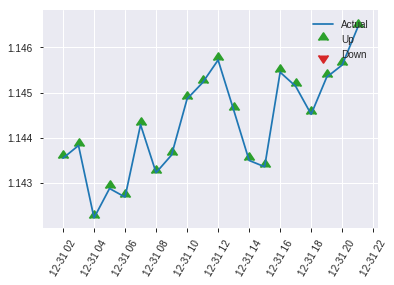


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27061105374090727
RMSE: 0.5202028967056097
LogLoss: 0.7574782269733958
Mean Per-Class Error: 0.45492987451228517
AUC: 0.5463460930085415
pr_auc: 0.5550363119571738
Gini: 0.09269218601708307
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.009385652265788918: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    290  1        (290.0/290.0)
1      0    327  0        (0.0/327.0)
Total  0    617  0.47     (290.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00938565   0.692797  399
max f2                       0.00938565   0.849351  399
max f0point5                 0.376213     0.598637  293
max accuracy                 0.37938      0.562399  291
max precision                0.998962     1         0
max recall                   0.00938565   1         399
max specificity              0.998962     1         0
max absolute_mcc             0.376213     0.11254   293
max min_per_class_accuracy   0.404396     0.524138  246
max mean_per_class_accuracy  0.426747     0.54507   207

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 44.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.926196           0.80865   0.80865            0.428571         0.961745  0.428571                    0.961745            0.00917431      0.00917431                 -19.135   -19.135
    2        0.0210697                   0.877892           0.943425  0.870854           0.5              0.895023  0.461538                    0.93095             0.00917431      0.0183486                  -5.65749  -12.9146
    3        0.0307942                   0.825229           1.57238   1.09239            0.833333         0.855843  0.578947                    0.907232            0.0152905       0.0336391                  57.2375   9.23869
    4        0.0405186                   0.783107           0.943425  1.05664            0.5              0.81006   0.56                        0.883911            0.00917431      0.0428135                  -5.65749  5.66361
    5        0.0502431                   0.759248           0.62895   0.973858           0.333333         0.770975  0.516129                    0.862052            0.00611621      0.0489297                  -37.105   -2.61419
    6        0.100486                    0.650985           1.27819   1.12602            0.677419         0.699729  0.596774                    0.78089             0.0642202       0.11315                    27.8189   12.6023
    7        0.150729                    0.586417           0.912992  1.05501            0.483871         0.615853  0.55914                     0.725878            0.0458716       0.159021                   -8.7008   5.5013
    8        0.200972                    0.516281           0.973858  1.03472            0.516129         0.545759  0.548387                    0.680848            0.0489297       0.207951                   -2.61419  3.47243
    9        0.299838                    0.462848           1.11355   1.06072            0.590164         0.483837  0.562162                    0.615888            0.110092        0.318043                   11.3551   6.07158
    10       0.400324                    0.429281           1.18689   1.09239            0.629032         0.444619  0.578947                    0.572897            0.119266        0.437309                   18.689    9.23869
    11       0.50081                     0.404435           0.852126  1.04418            0.451613         0.416173  0.553398                    0.541451            0.0856269       0.522936                   -14.7874  4.41792
    12       0.722853                    0.396594           1.03295   1.04073            0.547445         0.397363  0.55157                     0.497191            0.229358        0.752294                   3.29472   4.0729
    13       0.799028                    0.382271           1.04379   1.04102            0.553191         0.392788  0.551724                    0.487237            0.0795107       0.831804                   4.37894   4.10208
    14       0.899514                    0.302794           0.882559  1.02332            0.467742         0.349762  0.542342                    0.47188             0.088685        0.920489                   -11.7441  2.33187
    15       1                           0.00938565         0.79126   1                  0.419355         0.18473   0.529984                    0.443025            0.0795107       1                          -20.874   0

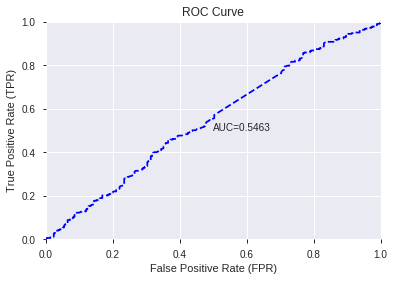

This function is available for GLM models only


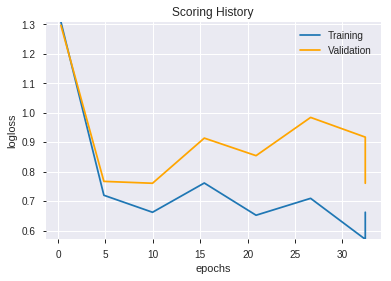

--2019-07-25 05:16:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.80.224
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.80.224|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_045652_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_045652_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['day',
 'STOCHRSI_fastk',
 'hour',
 'aroonup_8',
 'CORREL_24',
 'HT_DCPERIOD',
 'SAREXT',
 'aroonup_30',
 'is_month_start',
 'aroonup_12',
 'HT_TRENDMODE',
 'is_month_end',
 'weekday_name',
 'aroonup_24',
 'CDLSHORTLINE',
 'aroondown_8',
 'aroondown_24',
 'CDLONNECK',
 'CDLINVERTEDHAMMER',
 'BOP',
 'aroondown_20',
 'CDLEVENINGDOJISTAR',
 'aroondown_12',
 'CDLHOMINGPIGEON',
 'CDLGRAVESTONEDOJI',
 'aroondown_14',
 'aroonup_14',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLINNECK',
 'is_quarter_start',
 'CDLUNIQUE3RIVER',
 'aroonup_20',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'CDLMORNINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CORREL_30',
 'CDLMORNINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDLSTALLEDPATTERN',
 'CORREL_8',
 'CDLMATCHINGLOW',
 'CDLRICKSHAWMAN',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'CDL3BLACKCROWS',
 'CDLIDENTICAL3CROWS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_051752_model_1  0.531952  0.691637              0.493103  0.499248  0.249248

variable  relative_importance  scaled_importance  percentage
0          CDLSHORTLINE             0.018202           1.000000    0.063007
1             aroonup_8             0.017789           0.977302    0.061577
2                  hour             0.016905           0.928732    0.058517
3        STOCHRSI_fastk             0.016423           0.902231    0.056847
4                   BOP             0.014549           0.799321    0.050363
5        is_month_start             0.011735           0.644711    0.040621
6             CORREL_24             0.011687           0.642080    0.040456
7        CDLRICKSHAWMAN             0.008920           0.490066    0.030878
8          aroondown_20             0.008716           0.478847    0.030171
9       CDLHOMINGPIGEON             0.008600           0.472463    0.029769
10    CDLGRAVESTONEDOJI             0.008330           0.457638    0.028834
11         CDLTHRUSTING             0.008097           0.444857    0.028029
12            CDLONNECK             0.007709           0.423538    0.026686
13           aroonup_14             0.006788           0.372949    0.023498
14           aroonup_30             0.006613           0.363287    0.022890
15           aroonup_12             0.006462           0.355025    0.022369
16         aroondown_24             0.006265           0.344217    0.021688
17      CDLUNIQUE3RIVER             0.005989           0.329016    0.020730
18       CDL3BLACKCROWS             0.005974           0.328180    0.020678
19   CDLIDENTICAL3CROWS             0.005939           0.326300    0.020559
20         HT_TRENDMODE             0.005197           0.285538    0.017991
21            CORREL_30             0.005086           0.279407    0.017605
22            CDLINNECK             0.004878           0.268006    0.016886
23         is_month_end             0.004809           0.264172    0.016645
24           aroonup_24             0.004392           0.241296    0.015203
25            CDLTAKURI             0.004254           0.233722    0.014726
26  CDLGAPSIDESIDEWHITE             0.003983           0.218804    0.013786
27         aroondown_12             0.003883           0.213346    0.013442
28      CDLADVANCEBLOCK             0.003865           0.212319    0.013378
29               SAREXT             0.003793           0.208394    0.013130
30             CORREL_8             0.003769           0.207068    0.013047
31            CDLHAMMER             0.003684           0.202399    0.012753
32       CDLEVENINGSTAR             0.003667           0.201465    0.012694
33          CDLPIERCING             0.003600           0.197756    0.012460
34    CDL3WHITESOLDIERS             0.003450           0.189563    0.011944
35   CDLMORNINGDOJISTAR             0.003302           0.181383    0.011428
36    CDLINVERTEDHAMMER             0.003259           0.179039    0.011281
37         aroondown_14             0.002901           0.159359    0.010041
38          HT_DCPERIOD             0.002752           0.151210    0.009527
39          aroondown_8             0.002653           0.145767    0.009184
40           aroonup_20             0.002325           0.127705    0.008046
41       CDLMORNINGSTAR             0.001488           0.081736    0.005150
42    CDLSTALLEDPATTERN             0.001478           0.081195    0.005116
43      CDLSHOOTINGSTAR             0.001283           0.070510    0.004443
44         weekday_name             0.000962           0.052826    0.003328
45                  day             0.000888           0.048789    0.003074
46       CDLMATCHINGLOW             0.000798           0.043831    0.002762
47     is_quarter_start             0.000387           0.021235    0.001338
48   CDLEVENINGDOJISTAR             0.000343           0.018860    0.001188
49    CDLDARKCLOUDCOVER             0.000068           0.003734    0.000235

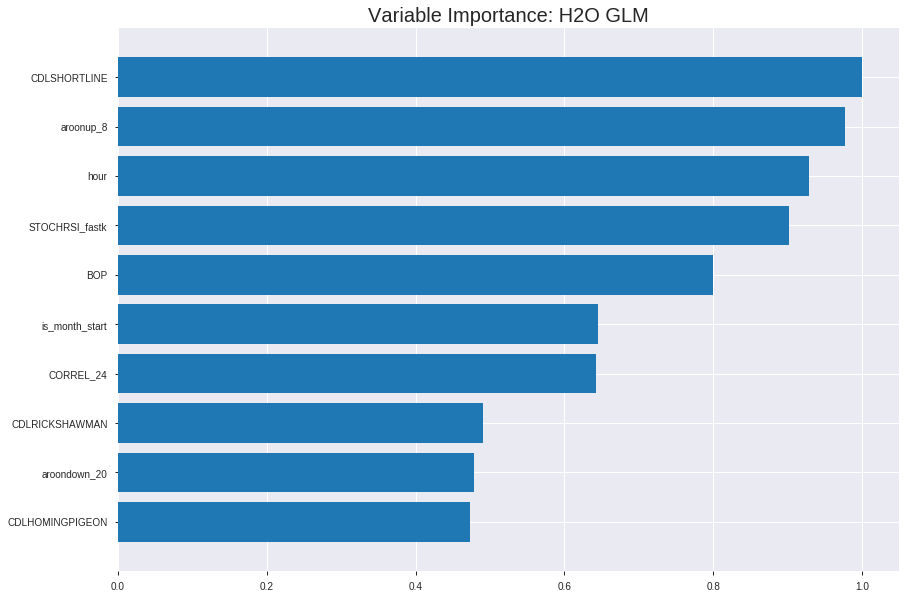

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_051752_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24836225089028108
RMSE: 0.49835955984638347
LogLoss: 0.6898635787230413
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5987.405114141723
Residual deviance: 5959.04159300963
AIC: 6061.04159300963
AUC: 0.5646598862642169
pr_auc: 0.5607197938272499
Gini: 0.12931977252843385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46033796197496574: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      8    2152  0.9963   (2152.0/2160.0)
1      2    2157  0.0009   (2.0/2159.0)
Total  10   4309  0.4987   (2154.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460338     0.666976  393
max f2                       0.450393     0.833398  398
max f0point5                 0.485518     0.560794  302
max accuracy                 0.502512     0.553137  193
max precision                0.67201      1         0
max recall                   0.450393     1         398
max specificity              0.67201      1         0
max absolute_mcc             0.502512     0.107616  193
max min_per_class_accuracy   0.499343     0.548611  215
max mean_per_class_accuracy  0.502512     0.553119  193

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 49.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.539591           1.31849   1.31849            0.659091         0.554402  0.659091                    0.554402            0.0134321       0.0134321                  31.8487   31.8487
    2        0.0201436                   0.534697           1.48872   1.40262            0.744186         0.53686   0.701149                    0.545732            0.0148217       0.0282538                  48.8717   40.2624
    3        0.0300996                   0.531288           1.16306   1.32338            0.581395         0.53299   0.661538                    0.541517            0.0115794       0.0398333                  16.306    32.3383
    4        0.0400556                   0.527927           1.11654   1.27197            0.55814          0.529744  0.635838                    0.538591            0.0111163       0.0509495                  11.6538   27.1971
    5        0.0500116                   0.525859           1.02349   1.22251            0.511628         0.52681   0.611111                    0.536245            0.0101899       0.0611394                  2.34928   22.2505
    6        0.100023                    0.5198             1.19472   1.20861            0.597222         0.522771  0.604167                    0.529508            0.0597499       0.120889                   19.4721   20.8613
    7        0.150035                    0.515676           1.12989   1.18237            0.564815         0.517584  0.591049                    0.525533            0.0565076       0.177397                   12.9891   18.2373
    8        0.200046                    0.512453           1.16694   1.17851            0.583333         0.514003  0.58912                     0.522651            0.0583604       0.235757                   16.6937   17.8514
    9        0.300069                    0.50741            1.08358   1.14687            0.541667         0.509787  0.573302                    0.518363            0.108384        0.344141                   8.35842   14.687
    10       0.400093                    0.503305           1.05117   1.12295            0.525463         0.505281  0.561343                    0.515092            0.105141        0.449282                   5.11693   12.2945
    11       0.500116                    0.499329           1.00949   1.10025            0.50463          0.501212  0.55                        0.512316            0.100973        0.550255                   0.949299  10.0255
    12       0.599907                    0.495589           0.932931  1.07242            0.466357         0.497455  0.536086                    0.509844            0.0930987       0.643353                   -6.70694  7.24212
    13       0.699931                    0.49128            0.902987  1.04821            0.451389         0.493337  0.523983                    0.507485            0.0903196       0.733673                   -9.70131  4.82083
    14       0.799954                    0.486246           0.944663  1.03526            0.472222         0.488744  0.517511                    0.505142            0.0944882       0.828161                   -5.53368  3.52614
    15       0.899977                    0.480402           0.893725  1.01953            0.446759         0.483513  0.509648                    0.502738            0.0893932       0.917554                   -10.6275  1.95311
    16       1                           0.400578           0.824265  1                  0.412037         0.474206  0.499884                    0.499884          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24956908973034894
RMSE: 0.49956890388648983
LogLoss: 0.6922752201325444
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1710.685455494171
Residual deviance: 1708.5352432871196
AIC: 1810.5352432871196
AUC: 0.5180240881568752
pr_auc: 0.5166502124702461
Gini: 0.036048176313750346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4519665225781068: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    615   0        (0.0/615.0)
Total  1    1233  0.5008   (618.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.451967     0.665584   398
max f2                       0.451967     0.832656   398
max f0point5                 0.4784       0.560621   346
max accuracy                 0.50876      0.52188    139
max precision                0.669497     1          0
max recall                   0.451967     1          398
max specificity              0.669497     1          0
max absolute_mcc             0.4784       0.0736234  346
max min_per_class_accuracy   0.499731     0.500813   203
max mean_per_class_accuracy  0.50876      0.521203   139

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 50.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.538547           0.926079  0.926079           0.461538         0.557346  0.461538                    0.557346            0.0097561       0.0097561                  -7.39212   -7.39212
    2        0.0202593                   0.532835           1.50488   1.2039             0.75             0.535703  0.6                         0.546957            0.0146341       0.0243902                  50.4878    20.3902
    3        0.0299838                   0.529908           1.00325   1.13883            0.5              0.531047  0.567568                    0.541797            0.0097561       0.0341463                  0.325203   13.8827
    4        0.0405186                   0.528825           0.926079  1.08351            0.461538         0.529318  0.54                        0.538553            0.0097561       0.0439024                  -7.39212   8.35122
    5        0.0502431                   0.527473           0.668835  1.00325            0.333333         0.528     0.5                         0.53651             0.00650407      0.0504065                  -33.1165   0.325203
    6        0.100486                    0.520465           1.16507   1.08416            0.580645         0.523088  0.540323                    0.529799            0.0585366       0.108943                   16.5067    8.41595
    7        0.149919                    0.516316           1.11838   1.09544            0.557377         0.51838   0.545946                    0.526034            0.0552846       0.164228                   11.8379    9.54428
    8        0.200162                    0.512611           0.938526  1.05605            0.467742         0.514216  0.526316                    0.523068            0.0471545       0.211382                   -6.14739   5.60548
    9        0.299838                    0.508067           1.02772   1.04664            0.512195         0.51042   0.521622                    0.518863            0.102439        0.313821                   2.77216    4.66359
    10       0.400324                    0.503511           1.03562   1.04387            0.516129         0.505799  0.520243                    0.515584            0.104065        0.417886                   3.5615     4.38695
    11       0.5                         0.499532           0.848278  1.00488            0.422764         0.501537  0.50081                     0.512784            0.0845528       0.502439                   -15.1722   0.487805
    12       0.599676                    0.495765           0.962469  0.997829           0.479675         0.497601  0.497297                    0.51026             0.095935        0.598374                   -3.75306   -0.217095
    13       0.700162                    0.491346           1.01943   1.00093            0.508065         0.49347   0.498843                    0.50785             0.102439        0.700813                   1.94335    0.092969
    14       0.799838                    0.486754           1.15823   1.02053            0.577236         0.489141  0.508612                    0.505519            0.115447        0.81626                    15.8226    2.0532
    15       0.899514                    0.479588           0.995096  1.01771            0.495935         0.483232  0.507207                    0.503049            0.099187        0.915447                   -0.490449  1.77133
    16       1                           0.445377           0.841437  1                  0.419355         0.473428  0.498379               


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:17:53  0.000 sec   2            2.6       51            1.38299           1.38506
    2019-07-25 05:17:53  0.092 sec   4            1.6       51            1.38154           1.38474
    2019-07-25 05:17:53  0.187 sec   6            1         51            1.37973           1.38455
    2019-07-25 05:17:53  0.278 sec   8            0.63      51            1.37765           1.38462
    2019-07-25 05:17:53  0.375 sec   10           0.39      51            1.37548           1.3851
    2019-07-25 05:17:53  0.411 sec   12           0.24      51            1.37346           1.386
    2019-07-25 05:17:53  0.452 sec   14           0.15      51            1.37175           1.38724
    2019-07-25 05:17:53  0.488 sec   16           0.094     51            1.37044           1.38863

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5364667747163695)

('F1', 0.6957446808510638)

('auc', 0.5319519139512812)

('logloss', 0.6916365014780119)

('mean_per_class_error', 0.4553253189918802)

('rmse', 0.4992478968228334)

('mse', 0.24924846248202248)

glm prediction progress: |████████████████████████████████████████████████| 100%


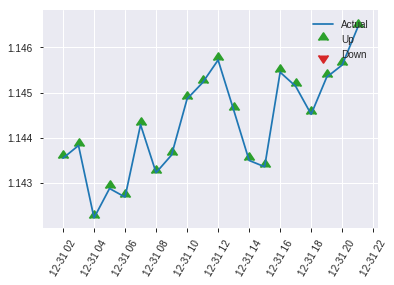


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24924846248202248
RMSE: 0.4992478968228334
LogLoss: 0.6916365014780119
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.3607874834584
Residual deviance: 853.4794428238665
AIC: 955.4794428238665
AUC: 0.5319519139512812
pr_auc: 0.5762714370933004
Gini: 0.06390382790256233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4668874412500198: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    286  0.9862   (286.0/290.0)
1      0    327  0        (0.0/327.0)
Total  4    613  0.4635   (286.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466887     0.695745  395
max f2                       0.466887     0.851119  395
max f0point5                 0.466887     0.588341  395
max accuracy                 0.466887     0.536467  395
max precision                0.621246     1         0
max recall                   0.466887     1         395
max specificity              0.621246     1         0
max absolute_mcc             0.520937     0.117467  34
max min_per_class_accuracy   0.497891     0.525994  198
max mean_per_class_accuracy  0.507605     0.544675  116

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 49.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.536179           1.0782    1.0782             0.571429         0.552126  0.571429                    0.552126            0.0122324       0.0122324                  7.82001   7.82001
    2        0.0210697                   0.531725           1.88685   1.45142            1                0.533282  0.769231                    0.543429            0.0183486       0.030581                   88.685    45.1423
    3        0.0307942                   0.527387           1.57238   1.48962            0.833333         0.528748  0.789474                    0.538793            0.0152905       0.0458716                  57.2375   48.9619
    4        0.0405186                   0.524631           1.2579    1.43401            0.666667         0.52633   0.76                        0.535802            0.0122324       0.058104                   25.79     43.4006
    5        0.0502431                   0.522889           1.2579    1.39992            0.666667         0.523849  0.741935                    0.533488            0.0122324       0.0703364                  25.79     39.9921
    6        0.100486                    0.517516           1.09559   1.24776            0.580645         0.520168  0.66129                     0.526828            0.0550459       0.125382                   9.55904   24.7756
    7        0.150729                    0.513049           1.03472   1.17675            0.548387         0.515475  0.623656                    0.523044            0.0519878       0.17737                    3.47243   17.6745
    8        0.200972                    0.510376           1.09559   1.15646            0.580645         0.511579  0.612903                    0.520178            0.0550459       0.232416                   9.55904   15.6457
    9        0.299838                    0.505861           0.927959  1.08111            0.491803         0.507832  0.572973                    0.516107            0.0917431       0.324159                   -7.20409  8.11141
    10       0.400324                    0.501851           0.943425  1.04655            0.5              0.503573  0.554656                    0.512961            0.0948012       0.41896                    -5.65749  4.65525
    11       0.50081                     0.497812           1.06516   1.05029            0.564516         0.499955  0.556634                    0.510351            0.107034        0.525994                   6.51573   5.02855
    12       0.599676                    0.493174           0.927959  1.03012            0.491803         0.49496   0.545946                    0.507814            0.0917431       0.617737                   -7.20409  3.01182
    13       0.700162                    0.4893             0.912992  1.01331            0.483871         0.491385  0.537037                    0.505456            0.0917431       0.70948                    -8.7008   1.33084
    14       0.799028                    0.484143           1.05169   1.01806            0.557377         0.487368  0.539554                    0.503218            0.103976        0.813456                   5.1687    1.80571
    15       0.899514                    0.478036           0.760827  0.989321           0.403226         0.481409  0.524324                    0.500782            0.0764526       0.889908                   -23.9173  -1.06786
    16       1                           0.462519           1.09559   1                  0.580645         0.473207  0.529984                    0.498011        

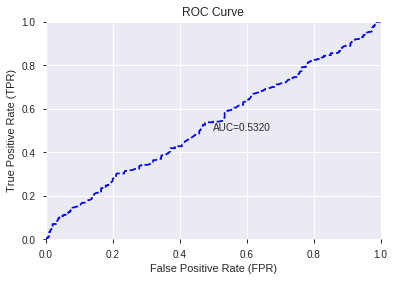

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


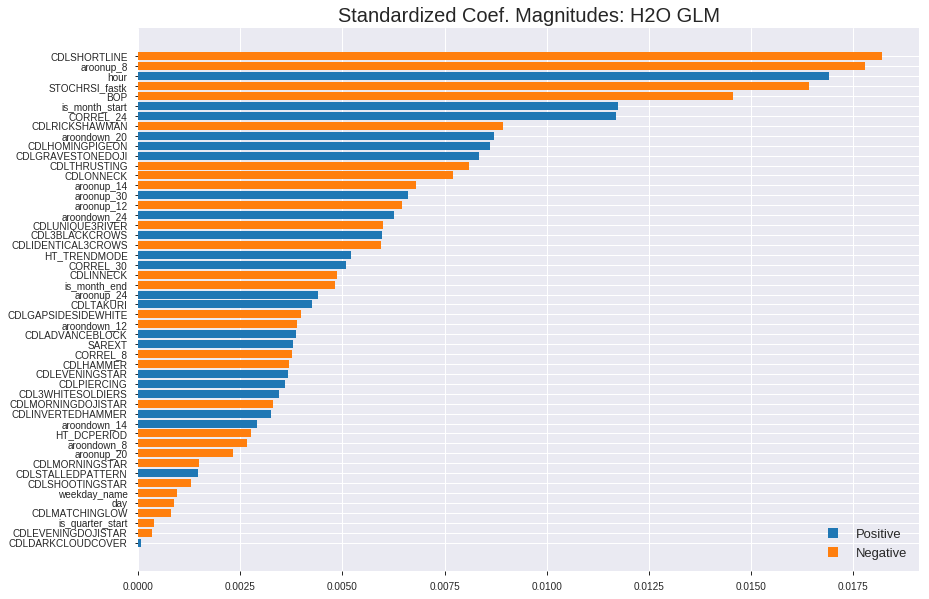

'log_likelihood'
--2019-07-25 05:18:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.83.64
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.83.64|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_051752_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_051752_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLSHORTLINE',
 'aroonup_8',
 'hour',
 'STOCHRSI_fastk',
 'BOP',
 'is_month_start',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'aroondown_20',
 'CDLHOMINGPIGEON',
 'CDLGRAVESTONEDOJI',
 'CDLTHRUSTING',
 'CDLONNECK',
 'aroonup_14',
 'aroonup_30',
 'aroonup_12',
 'aroondown_24',
 'CDLUNIQUE3RIVER',
 'CDL3BLACKCROWS',
 'CDLIDENTICAL3CROWS',
 'HT_TRENDMODE',
 'CORREL_30',
 'CDLINNECK',
 'is_month_end',
 'aroonup_24',
 'CDLTAKURI',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_12',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'CORREL_8',
 'CDLHAMMER',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'aroondown_14',
 'HT_DCPERIOD',
 'aroondown_8',
 'aroonup_20',
 'CDLMORNINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'day',
 'CDLMATCHINGLOW',
 'is_quarter_start',
 'CDLEVENINGDOJISTAR',
 'CDLDARKCLOUDCOVER']

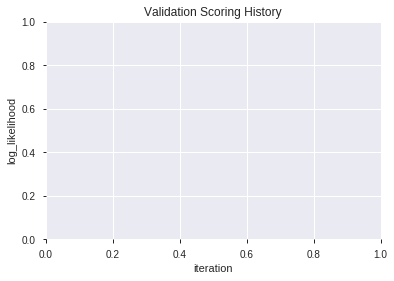

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_051901_model_6  0.544801  0.689404              0.484646  0.498151  0.248154
1  XGBoost_grid_1_AutoML_20190725_051901_model_4  0.542207  0.689347              0.492518  0.498121  0.248124
2  XGBoost_grid_1_AutoML_20190725_051901_model_5  0.536956  0.715555              0.500000  0.509792  0.259888
3  XGBoost_grid_1_AutoML_20190725_051901_model_1  0.536502  0.689587              0.488485  0.498329  0.248331
4               XGBoost_3_AutoML_20190725_051901  0.536038  0.689655              0.485036  0.498320  0.248323
5  XGBoost_grid_1_AutoML_20190725_051901_model_7  0.534372  0.699006              0.496552  0.502717  0.252724
6  XGBoost_grid_1_AutoML_20190725_051901_model_2  0.530855  0.692693              0.498276  0.499792  0.249792
7               XGBoost_1_AutoML_20190725_051901  0.529089  0.699261              0.492713  0.502893  0.252901
8  XGBoost_grid_1_AutoML_20190725_051901_model_3  0.527555  0.691504              0.484093  0.499249  0.249250
9               XGBoost_2_AutoML_20190725_051901  0.525440  0.697577              0.496552  0.502146  0.252151

variable  relative_importance  scaled_importance  percentage
0              SAREXT           690.996704           1.000000    0.095317
1         HT_DCPERIOD           687.895020           0.995511    0.094889
2                 BOP           618.141357           0.894565    0.085267
3      STOCHRSI_fastk           541.646240           0.783862    0.074715
4           CORREL_24           484.266144           0.700823    0.066800
5                 day           480.924255           0.695986    0.066339
6                hour           464.057190           0.671577    0.064013
7           CORREL_30           438.234039           0.634206    0.060450
8          aroonup_30           328.754822           0.475769    0.045349
9        weekday_name           286.943207           0.415260    0.039581
10       aroondown_12           251.035278           0.363294    0.034628
11          aroonup_8           247.390579           0.358020    0.034125
12       aroondown_20           219.782028           0.318065    0.030317
13         aroonup_24           208.212830           0.301322    0.028721
14        aroondown_8           187.133301           0.270816    0.025813
15       aroondown_14           169.030777           0.244619    0.023316
16         aroonup_20           168.006180           0.243136    0.023175
17       aroondown_24           162.024811           0.234480    0.022350
18         aroonup_12           143.321426           0.207413    0.019770
19         aroonup_14           126.932686           0.183695    0.017509
20       CDLSHORTLINE           120.721725           0.174707    0.016652
21     CDLRICKSHAWMAN            67.121101           0.097137    0.009259
22       HT_TRENDMODE            30.648598           0.044354    0.004228
23       is_month_end            23.225765           0.033612    0.003204
24  CDLGRAVESTONEDOJI            20.745186           0.030022    0.002862
25          CDLHAMMER            19.876402           0.028765    0.002742
26    CDLADVANCEBLOCK            17.872684           0.025865    0.002465
27          CDLTAKURI            15.636644           0.022629    0.002157
28     CDLMATCHINGLOW            12.879604           0.018639    0.001777
29  CDLINVERTEDHAMMER             9.866352           0.014278    0.001361
30     is_month_start             6.149518           0.008899    0.000848

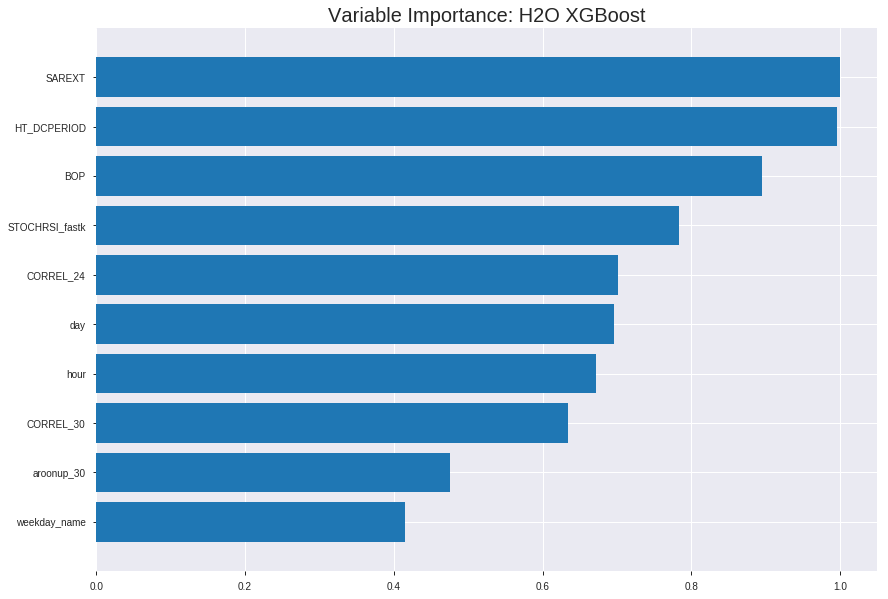

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_051901_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22038612006338995
RMSE: 0.46945300090998454
LogLoss: 0.6330087072366658
Mean Per-Class Error: 0.2732160165028391
AUC: 0.8006106007582385
pr_auc: 0.7987933882323012
Gini: 0.6012212015164771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.468605101108551: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1141  1019  0.4718   (1019.0/2160.0)
1      274   1885  0.1269   (274.0/2159.0)
Total  1415  2904  0.2994   (1293.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468605     0.744618  259
max f2                       0.428562     0.848843  316
max f0point5                 0.503285     0.73144   204
max accuracy                 0.499993     0.726789  210
max precision                0.784803     1         0
max recall                   0.344256     1         389
max specificity              0.784803     1         0
max absolute_mcc             0.499993     0.453932  210
max min_per_class_accuracy   0.496732     0.725463  216
max mean_per_class_accuracy  0.499993     0.726784  210

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.683168           2.00046   2.00046            1                0.707677  1                           0.707677            0.0203798       0.0203798                  100.046   100.046
    2        0.0201436                   0.656297           1.8609    1.93148            0.930233         0.668906  0.965517                    0.688514            0.0185271       0.0389069                  86.0896   93.1482
    3        0.0300996                   0.641661           1.81437   1.89275            0.906977         0.648708  0.946154                    0.675347            0.0180639       0.0569708                  81.4374   89.2746
    4        0.0400556                   0.627769           1.90742   1.89639            0.953488         0.634052  0.947977                    0.665083            0.0189903       0.0759611                  90.7418   89.6393
    5        0.0500116                   0.618827           1.90742   1.89859            0.953488         0.623012  0.949074                    0.656708            0.0189903       0.0949514                  90.7418   89.8588
    6        0.100023                    0.586931           1.89859   1.89859            0.949074         0.6016    0.949074                    0.629154            0.0949514       0.189903                   89.8588   89.8588
    7        0.150035                    0.566897           1.51887   1.77202            0.759259         0.575662  0.885802                    0.611323            0.0759611       0.265864                   51.887    77.2015
    8        0.200046                    0.550984           1.56518   1.72031            0.782407         0.558594  0.859954                    0.598141            0.078277        0.344141                   56.5177   72.0306
    9        0.300069                    0.530043           1.41236   1.61766            0.706019         0.539979  0.808642                    0.578754            0.141269        0.48541                    41.2364   61.7658
    10       0.400093                    0.511349           1.28734   1.53508            0.643519         0.520654  0.767361                    0.564229            0.128763        0.614173                   28.7335   53.5078
    11       0.500116                    0.496541           1.116     1.45126            0.55787          0.503984  0.725463                    0.55218             0.111626        0.725799                   11.5999   45.1262
    12       0.599907                    0.480601           0.872592  1.355              0.436195         0.488372  0.677345                    0.541566            0.0870774       0.812876                   -12.7408  35.5003
    13       0.699931                    0.463842           0.796481  1.27519            0.398148         0.472308  0.637446                    0.531668            0.0796665       0.892543                   -20.3519  27.5188
    14       0.799954                    0.444469           0.564946  1.18638            0.282407         0.455329  0.593054                    0.522123            0.0565076       0.94905                    -43.5054  18.6382
    15       0.899977                    0.416273           0.333411  1.09158            0.166667         0.431529  0.545665                    0.512055            0.0333488       0.982399                   -66.6589  9.15828
    16       1                           0.306308           0.175967  1                  0.087963         0.389427  0.499884                    0.499789         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2517136386749984
RMSE: 0.501710712138976
LogLoss: 0.6966945866443003
Mean Per-Class Error: 0.4785899102932871
AUC: 0.5176418823962069
pr_auc: 0.5129451512829307
Gini: 0.035283764792413796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3357991576194763: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    617   0.9968   (617.0/619.0)
1      0    615   0        (0.0/615.0)
Total  2    1232  0.5      (617.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.335799     0.665945   397
max f2                       0.335799     0.832882   397
max f0point5                 0.419083     0.558414   354
max accuracy                 0.499239     0.52107    224
max precision                0.72347      1          0
max recall                   0.335799     1          397
max specificity              0.72347      1          0
max absolute_mcc             0.447095     0.0607965  318
max min_per_class_accuracy   0.507588     0.505654   211
max mean_per_class_accuracy  0.447095     0.52141    318

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 51.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.676402           1.08043   1.08043            0.538462         0.693687  0.538462                    0.693687            0.0113821       0.0113821                  8.04253   8.04253
    2        0.0202593                   0.656809           1.00325   1.04338            0.5              0.66617   0.52                        0.680479            0.0097561       0.0211382                  0.325203  4.33821
    3        0.0299838                   0.640597           1.33767   1.13883            0.666667         0.649093  0.567568                    0.6703              0.0130081       0.0341463                  33.7669   13.8827
    4        0.0405186                   0.631533           0.771732  1.04338            0.384615         0.635891  0.52                        0.661354            0.00813008      0.0422764                  -22.8268  4.33821
    5        0.0502431                   0.625086           1.8393    1.19743            0.916667         0.628938  0.596774                    0.65508             0.0178862       0.0601626                  83.9295   19.743
    6        0.100486                    0.59128            1.00325   1.10034            0.5              0.606617  0.548387                    0.630848            0.0504065       0.110569                   0.325203  10.0341
    7        0.149919                    0.574857           1.0197    1.07375            0.508197         0.582484  0.535135                    0.614901            0.0504065       0.160976                   1.96988   7.37508
    8        0.200162                    0.561251           0.938526  1.03981            0.467742         0.567472  0.518219                    0.602996            0.0471545       0.20813                    -6.14739  3.98078
    9        0.299838                    0.539878           0.946156  1.00868            0.471545         0.550774  0.502703                    0.585636            0.0943089       0.302439                   -5.38436  0.867502
    10       0.400324                    0.523031           0.954708  0.995129           0.475806         0.531847  0.495951                    0.572134            0.095935        0.398374                   -4.52924  -0.487147
    11       0.5                         0.507426           1.07666   1.01138            0.536585         0.514694  0.504052                    0.560683            0.107317        0.505691                   7.66607   1.13821
    12       0.599676                    0.492279           1.02772   1.0141             0.512195         0.498823  0.505405                    0.550401            0.102439        0.60813                    2.77216   1.4098
    13       0.700162                    0.477603           1.08416   1.02415            0.540323         0.485143  0.510417                    0.541035            0.108943        0.717073                   8.41595   2.41531
    14       0.799838                    0.460098           0.978782  1.0185             0.487805         0.469365  0.507599                    0.532104            0.097561        0.814634                   -2.12175  1.8499
    15       0.899514                    0.436686           0.978782  1.0141             0.487805         0.448872  0.505405                    0.522881            0.097561        0.912195                   -2.12175  1.4098
    16       1                           0.3074             0.8738    1                  0.435484         0.403121  0.498379                    0.510847          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:19:24  14.092 sec  0                  0.5              0.693147            0.5             0                  1                0.500116                         0.5                0.693147              0.5               0                    1                  0.501621
    2019-07-25 05:19:24  14.216 sec  5                  0.495996         0.685161            0.654609        0.662315           1.86407          0.425561                         0.500199           0.693546              0.497227          0.493246             0.926079           0.493517
    2019-07-25 05:19:24  14.284 sec  10                 0.492197         0.677617            0.692315        0.692659           1.90953          0.405649                         0.500087           0.69332               0.508507          0.510474             1.23477            0.498379
    2019-07-25 05:19:24  14.358 sec  15                 0.488658         0.67061             0.709533        0.712887           2.00046          0.38759                          0.499413           0.691961              0.522453          0.524154             1.38912            0.498379
    2019-07-25 05:19:24  14.434 sec  20                 0.485669         0.664697            0.724394        0.726073           1.955            0.365825                         0.499914           0.69297               0.518134          0.521282             1.54346            0.498379
    2019-07-25 05:19:24  14.511 sec  25                 0.483254         0.659938            0.737351        0.73743            2.00046          0.37254                          0.499809           0.692765              0.522223          0.52161              1.23477            0.5
    2019-07-25 05:19:24  14.592 sec  30                 0.480063         0.65368             0.756184        0.756852           2.00046          0.350081                         0.500134           0.693448              0.524096          0.519445             1.23477            0.5
    2019-07-25 05:19:25  14.683 sec  35                 0.477147         0.647972            0.767739        0.767867           2.00046          0.332021                         0.500193           0.693576              0.526127          0.520471             1.23477            0.5
    2019-07-25 05:19:25  14.767 sec  40                 0.47451          0.642824            0.778311        0.77767            2.00046          0.302385                         0.501109           0.695447              0.519394          0.514322             0.926079           0.50081
    2019-07-25 05:19:25  14.875 sec  45                 0.471936         0.637829            0.791228        0.789986           2.00046          0.302153                         0.501314           0.695869              0.5192            0.515088             1.08043            0.50081
    2019-07-25 05:19:25  14.986 sec  50                 0.469453         0.633009            0.800611        0.798793           2.00046          0.299375                         0.501711           0.696695              0.517642          0.512945             1.08043            0.5

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
SAREXT             690.9967041015625      1.0                   0.09531682593298527
HT_DCPERIOD        687.89501953125        0.9955112889078894    0.0948889762391551
BOP                618.141357421875       0.8945648419923878    0.08526708132995689
STOCHRSI_fastk     541.646240234375       0.7838622630459956    0.07471526288219107
CORREL_24          484.2661437988281      0.7008226536021955    0.0668001908832933
---                ---                    ---                   ---
CDLADVANCEBLOCK    17.872684478759766     0.025865079200338478  0.0024653772518815403
CDLTAKURI          15.63664436340332      0.02262911569706279   0.0021569354819143184
CDLMATCHINGLOW     12.87960433959961      0.018639168990459566  0.0017766264261991312
CDLINVERTEDHAMMER  9.866352081298828      0.014278435805460331  0.0013609751802643667
is_month_start     6.149518013000488      0.008899489645172945  0.0008482711054013543


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5510534846029174)

('F1', 0.6934782608695653)

('auc', 0.5448012232415902)

('logloss', 0.6894040886122242)

('mean_per_class_error', 0.4615997047347886)

('rmse', 0.498150839953328)

('mse', 0.24815425934620622)

xgboost prediction progress: |████████████████████████████████████████████| 100%


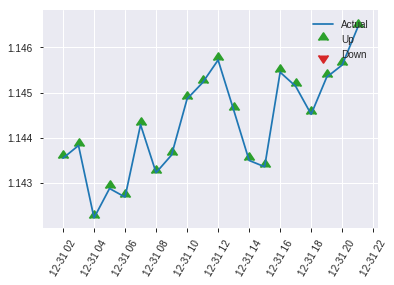


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24815425934620622
RMSE: 0.498150839953328
LogLoss: 0.6894040886122242
Mean Per-Class Error: 0.4615997047347886
AUC: 0.5448012232415902
pr_auc: 0.5803371225077543
Gini: 0.08960244648318039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40118515491485596: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   274  0.9448   (274.0/290.0)
1      8    319  0.0245   (8.0/327.0)
Total  24   593  0.4571   (282.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401185     0.693478  379
max f2                       0.338182     0.849351  399
max f0point5                 0.432561     0.593186  340
max accuracy                 0.43538      0.551053  335
max precision                0.72622      1         0
max recall                   0.338182     1         399
max specificity              0.72622      1         0
max absolute_mcc             0.595913     0.112694  32
max min_per_class_accuracy   0.492433     0.517241  211
max mean_per_class_accuracy  0.510858     0.5384    167

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.650499           1.34775   1.34775            0.714286         0.675897  0.714286                    0.675897            0.0152905       0.0152905                  34.775    34.775
    2        0.0210697                   0.622731           1.2579    1.30628            0.666667         0.629955  0.692308                    0.654693            0.0122324       0.0275229                  25.79     30.6281
    3        0.0307942                   0.614677           1.57238   1.39031            0.833333         0.618881  0.736842                    0.643384            0.0152905       0.0428135                  57.2375   39.0311
    4        0.0405186                   0.607215           1.2579    1.35853            0.666667         0.610459  0.72                        0.635482            0.0122324       0.0550459                  25.79     35.8532
    5        0.0502431                   0.60352            1.2579    1.33905            0.666667         0.605752  0.709677                    0.629728            0.0122324       0.0672783                  25.79     33.9055
    6        0.100486                    0.578373           1.27819   1.30862            0.677419         0.59107   0.693548                    0.610399            0.0642202       0.131498                   27.8189   30.8622
    7        0.150729                    0.561853           0.79126   1.13617            0.419355         0.570855  0.602151                    0.597218            0.0397554       0.171254                   -20.874   13.6168
    8        0.200972                    0.545728           1.09559   1.12602            0.580645         0.553546  0.596774                    0.5863              0.0550459       0.2263                     9.55904   12.6023
    9        0.299838                    0.52542            1.05169   1.10151            0.557377         0.536249  0.583784                    0.569796            0.103976        0.330275                   5.1687    10.1513
    10       0.400324                    0.509421           1.00429   1.07711            0.532258         0.517631  0.57085                     0.556702            0.100917        0.431193                   0.429121  7.71088
    11       0.50081                     0.492724           0.852126  1.03197            0.451613         0.500407  0.546926                    0.545407            0.0856269       0.51682                    -14.7874  3.19666
    12       0.599676                    0.47886            1.02076   1.03012            0.540984         0.4855    0.545946                    0.53553             0.100917        0.617737                   2.0755    3.01182
    13       0.700162                    0.46533            1.03472   1.03078            0.548387         0.471616  0.546296                    0.526357            0.103976        0.721713                   3.47243   3.07793
    14       0.799028                    0.450617           0.927959  1.01806            0.491803         0.457919  0.539554                    0.517889            0.0917431       0.813456                   -7.20409  1.80571
    15       0.899514                    0.42708            1.03472   1.01992            0.548387         0.439113  0.540541                    0.509089            0.103976        0.917431                   3.47243   1.9919
    16       1                           0.338182           0.821693  1                  0.435484         0.404556  0.529984                    0.498585           

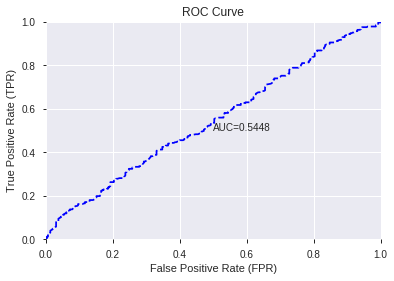

This function is available for GLM models only


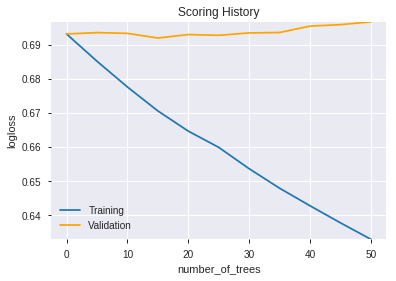

--2019-07-25 05:19:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.36|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_051901_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_051901_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SAREXT',
 'HT_DCPERIOD',
 'BOP',
 'STOCHRSI_fastk',
 'CORREL_24',
 'day',
 'hour',
 'CORREL_30',
 'aroonup_30',
 'weekday_name',
 'aroondown_12',
 'aroonup_8',
 'aroondown_20',
 'aroonup_24',
 'aroondown_8',
 'aroondown_14',
 'aroonup_20',
 'aroondown_24',
 'aroonup_12',
 'aroonup_14',
 'CDLSHORTLINE',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'is_month_start']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_052036_model_1  0.538147  0.693859              0.498276  0.500355  0.250355

variable  relative_importance  scaled_importance  percentage
0                 CDLSHORTLINE             0.008387           1.000000    0.018202
1                         hour             0.006959           0.829762    0.015104
2                    aroonup_8             0.006765           0.806612    0.014682
3               STOCHRSI_fastk             0.006326           0.754206    0.013728
4                          BOP             0.006155           0.733873    0.013358
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_20_2_4             0.000000           0.000000    0.000000
1033  BBANDS_middleband_24_2_3             0.000000           0.000000    0.000000
1034  BBANDS_middleband_30_2_3             0.000000           0.000000    0.000000
1035                   MA_30_6             0.000000           0.000000    0.000000
1036  BBANDS_middleband_30_6_2             0.000000           0.000000    0.000000

[1037 rows x 4 columns]

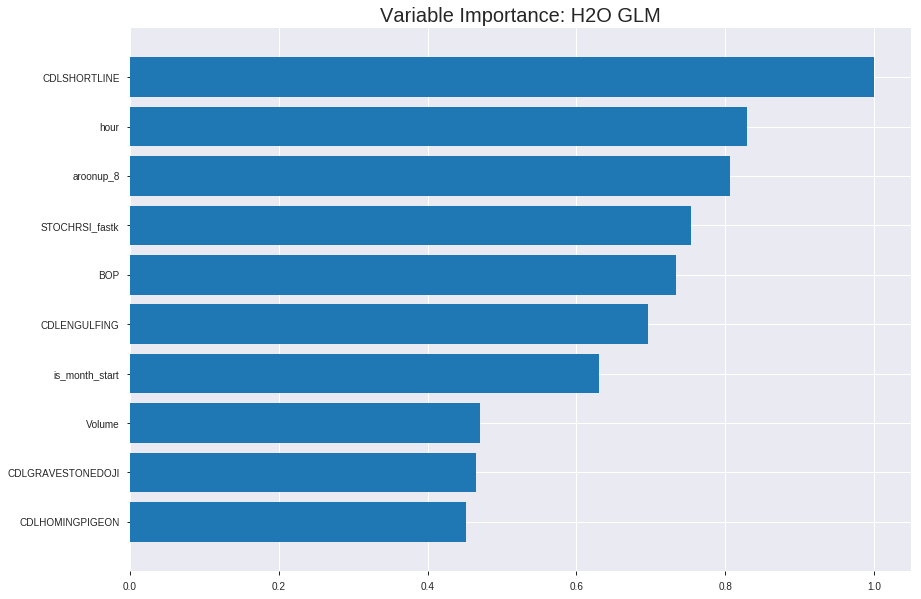

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_052036_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24838053029970303
RMSE: 0.4983778990883354
LogLoss: 0.6899035832845601
Null degrees of freedom: 4318
Residual degrees of freedom: 3301
Null deviance: 5987.405114141723
Residual deviance: 5959.38715241203
AIC: 7995.38715241203
AUC: 0.5579582883021975
pr_auc: 0.5541087875728282
Gini: 0.11591657660439503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4517631957100913: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      2    2158  0.9991   (2158.0/2160.0)
1      0    2159  0        (0.0/2159.0)
Total  2    4317  0.4997   (2158.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.451763     0.66677    397
max f2                       0.451763     0.833398   397
max f0point5                 0.476045     0.562138   337
max accuracy                 0.503225     0.544107   190
max precision                0.588561     1          0
max recall                   0.451763     1          397
max specificity              0.588561     1          0
max absolute_mcc             0.505109     0.0902552  181
max min_per_class_accuracy   0.499354     0.540741   212
max mean_per_class_accuracy  0.503225     0.54409    190

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 49.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.547107           1.40942   1.40942            0.704545         0.55659   0.704545                    0.55659             0.0143585       0.0143585                  40.9417    40.9417
    2        0.0201436                   0.540253           1.20958   1.31065            0.604651         0.543352  0.655172                    0.550047            0.0120426       0.0264011                  20.9582    31.0648
    3        0.0300996                   0.536223           1.53524   1.38494            0.767442         0.538011  0.692308                    0.546066            0.0152849       0.041686                   53.5239    38.4936
    4        0.0400556                   0.533014           1.07002   1.30666            0.534884         0.534547  0.653179                    0.543203            0.0106531       0.052339                   7.00152    30.6661
    5        0.0500116                   0.53049            0.930448  1.23177            0.465116         0.531745  0.615741                    0.540922            0.00926355      0.0616026                  -6.9552    23.1767
    6        0.100023                    0.52397            1.18546   1.20861            0.592593         0.526982  0.604167                    0.533952            0.0592867       0.120889                   18.546     20.8613
    7        0.150035                    0.519142           1.15768   1.19163            0.578704         0.52164   0.595679                    0.529848            0.0578972       0.178786                   15.7675    19.1634
    8        0.200046                    0.5154             1.07432   1.16231            0.537037         0.517155  0.581019                    0.526675            0.0537286       0.232515                   7.43228    16.2306
    9        0.300069                    0.50923            1.04191   1.12217            0.520833         0.512152  0.560957                    0.521834            0.104215        0.33673                    4.19079    12.2173
    10       0.400093                    0.504213           1.04654   1.10326            0.523148         0.506535  0.551505                    0.518009            0.104678        0.441408                   4.65386    10.3265
    11       0.500116                    0.499349           1.00023   1.08266            0.5              0.501861  0.541204                    0.514779            0.100046        0.541454                   0.0231589  8.26581
    12       0.599907                    0.49424            0.937572  1.05852            0.468677         0.496751  0.529139                    0.51178             0.0935618       0.635016                   -6.24279   5.85237
    13       0.699931                    0.489409           0.953925  1.04358            0.476852         0.491963  0.521667                    0.508949            0.0954145       0.730431                   -4.60754   4.35761
    14       0.799954                    0.4833             0.944663  1.03121            0.472222         0.486393  0.515485                    0.506128            0.0944882       0.824919                   -5.53368   3.12084
    15       0.899977                    0.476384           0.953925  1.02262            0.476852         0.480135  0.511191                    0.503239            0.0954145       0.920333                   -4.60754   2.26191
    16       1                           0.445808           0.796481  1                  0.398148         0.469696  0.499884                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24968408394719016
RMSE: 0.4996839840811292
LogLoss: 0.6925147896243664
Null degrees of freedom: 1233
Residual degrees of freedom: 216
Null deviance: 1710.685455494171
Residual deviance: 1709.1265007929364
AIC: 3745.1265007929364
AUC: 0.5200034148968307
pr_auc: 0.5219435527845058
Gini: 0.040006829793661325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4490390770909017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    615   0        (0.0/615.0)
Total  1    1233  0.5008   (618.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.449039     0.665584   398
max f2                       0.449039     0.832656   398
max f0point5                 0.449039     0.554354   398
max accuracy                 0.498727     0.528363   143
max precision                0.563075     1          0
max recall                   0.449039     1          398
max specificity              0.563075     1          0
max absolute_mcc             0.52376      0.0617155  24
max min_per_class_accuracy   0.489765     0.507317   208
max mean_per_class_accuracy  0.498727     0.527691   143

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.530044           1.23477   1.23477            0.615385         0.539917  0.615385                    0.539917            0.0130081       0.0130081                  23.4772   23.4772
    2        0.0202593                   0.525801           1.33767   1.28416            0.666667         0.527658  0.64                        0.534033            0.0130081       0.0260163                  33.7669   28.4163
    3        0.0299838                   0.523004           1.33767   1.30152            0.666667         0.524273  0.648649                    0.530867            0.0130081       0.0390244                  33.7669   30.1516
    4        0.0405186                   0.520843           1.08043   1.24403            0.538462         0.521744  0.62                        0.528495            0.0113821       0.0504065                  8.04253   24.4033
    5        0.0502431                   0.519194           1.17046   1.22979            0.583333         0.520014  0.612903                    0.526854            0.0113821       0.0617886                  17.0461   22.9793
    6        0.100486                    0.512631           0.906163  1.06798            0.451613         0.515331  0.532258                    0.521093            0.0455285       0.107317                   -9.38369  6.7978
    7        0.149919                    0.507448           0.986805  1.04121            0.491803         0.510068  0.518919                    0.517458            0.0487805       0.156098                   -1.31947  4.12129
    8        0.200162                    0.504093           1.16507   1.0723             0.580645         0.505914  0.534413                    0.51456             0.0585366       0.214634                   16.5067   7.23018
    9        0.299838                    0.498257           1.09297   1.07917            0.544715         0.500899  0.537838                    0.510018            0.108943        0.323577                   9.29738   7.91738
    10       0.400324                    0.493502           0.857619  1.02356            0.427419         0.495841  0.510121                    0.50646             0.0861789       0.409756                   -14.2381  2.35608
    11       0.5                         0.489689           0.978782  1.01463            0.487805         0.491529  0.505673                    0.503483            0.097561        0.507317                   -2.12175  1.46341
    12       0.599676                    0.485093           0.978782  1.00868            0.487805         0.487454  0.502703                    0.500819            0.097561        0.604878                   -2.12175  0.867502
    13       0.700162                    0.480348           1.06798   1.01719            0.532258         0.482967  0.506944                    0.498257            0.107317        0.712195                   6.7978    1.71861
    14       0.799838                    0.475507           1.01141   1.01647            0.504065         0.478004  0.506586                    0.495733            0.100813        0.813008                   1.14086   1.64661
    15       0.899514                    0.467978           0.929843  1.00687            0.463415         0.471997  0.501802                    0.493103            0.0926829       0.905691                   -7.01567  0.686736
    16       1                           0.448305           0.938526  1                  0.467742         0.461167  0.498379                    0.489894        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:20:44  0.000 sec   2            2.6       1018          1.37981           1.38503
    2019-07-25 05:20:49  5.049 sec   4            1.9       1023          1.37841           1.38521
    2019-07-25 05:20:54  9.967 sec   6            1.4       1026          1.37676           1.38542
    2019-07-25 05:20:59  15.040 sec  8            1         1028          1.37487           1.38582
    2019-07-25 05:21:04  19.925 sec  10           0.74      1029          1.37275           1.38645
    2019-07-25 05:21:09  24.828 sec  12           0.54      1032          1.37041           1.38747

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5429497568881686)

('F1', 0.6935312831389184)

('auc', 0.5381472107982705)

('logloss', 0.6938592542377848)

('mean_per_class_error', 0.45515659601391967)

('rmse', 0.5003549679022327)

('mse', 0.2503550939044443)

glm prediction progress: |████████████████████████████████████████████████| 100%


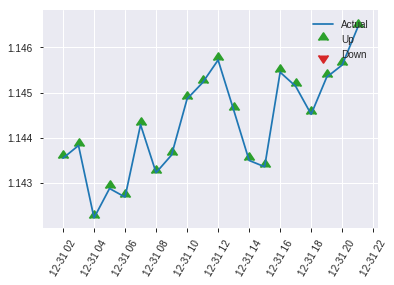


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2503550939044443
RMSE: 0.5003549679022327
LogLoss: 0.6938592542377848
Null degrees of freedom: 616
Residual degrees of freedom: -401
Null deviance: 855.3607874834584
Residual deviance: 856.2223197294265
AIC: 2892.2223197294265
AUC: 0.5381472107982705
pr_auc: 0.5632335572652512
Gini: 0.0762944215965411
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44900948705091126: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    289  0.9966   (289.0/290.0)
1      0    327  0        (0.0/327.0)
Total  1    616  0.4684   (289.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.449009     0.693531   398
max f2                       0.449009     0.849792   398
max f0point5                 0.465018     0.587653   344
max accuracy                 0.47569      0.54295    270
max precision                0.544232     1          0
max recall                   0.449009     1          398
max specificity              0.544232     1          0
max absolute_mcc             0.523963     0.0951566  9
max min_per_class_accuracy   0.484301     0.527586   203
max mean_per_class_accuracy  0.486748     0.544843   184

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 48.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.526673           1.6173    1.6173             0.857143         0.532288  0.857143                    0.532288            0.0183486       0.0183486                  61.73     61.73
    2        0.0210697                   0.520792           1.2579    1.45142            0.666667         0.523742  0.769231                    0.528343            0.0122324       0.030581                   25.79     45.1423
    3        0.0307942                   0.518218           0.943425  1.291              0.5              0.519303  0.684211                    0.525489            0.00917431      0.0397554                  -5.65749  29.1003
    4        0.0405186                   0.515224           0.943425  1.20758            0.5              0.517006  0.64                        0.523453            0.00917431      0.0489297                  -5.65749  20.7584
    5        0.0502431                   0.513783           1.57238   1.27819            0.833333         0.514434  0.677419                    0.521707            0.0152905       0.0642202                  57.2375   27.8189
    6        0.100486                    0.506553           0.730394  1.00429            0.387097         0.510004  0.532258                    0.515856            0.0366972       0.100917                   -26.9606  0.429121
    7        0.150729                    0.502737           1.09559   1.03472            0.580645         0.504441  0.548387                    0.512051            0.0550459       0.155963                   9.55904   3.47243
    8        0.200972                    0.498791           1.21732   1.08037            0.645161         0.500713  0.572581                    0.509216            0.0611621       0.217125                   21.7323   8.03739
    9        0.299838                    0.493323           1.11355   1.09131            0.590164         0.495706  0.578378                    0.504762            0.110092        0.327217                   11.3551   9.13133
    10       0.400324                    0.489072           0.973858  1.06183            0.516129         0.491358  0.562753                    0.501397            0.0978593       0.425076                   -2.61419  6.18307
    11       0.50081                     0.484372           1.00429   1.05029            0.532258         0.48648   0.556634                    0.498404            0.100917        0.525994                   0.429121  5.02855
    12       0.599676                    0.480016           1.02076   1.04542            0.540984         0.481877  0.554054                    0.49568             0.100917        0.626911                   2.0755    4.5417
    13       0.700162                    0.4757             1.00429   1.03951            0.532258         0.477631  0.550926                    0.493089            0.100917        0.727829                   0.429121  3.95147
    14       0.799028                    0.470217           0.897027  1.02188            0.47541          0.473006  0.541582                    0.490604            0.088685        0.816514                   -10.2973  2.18844
    15       0.899514                    0.464266           0.943425  1.01312            0.5              0.467535  0.536937                    0.488027            0.0948012       0.911315                   -5.65749  1.31195
    16       1                           0.448018           0.882559  1                  0.467742         0.458062  0.529984                    0.485016           

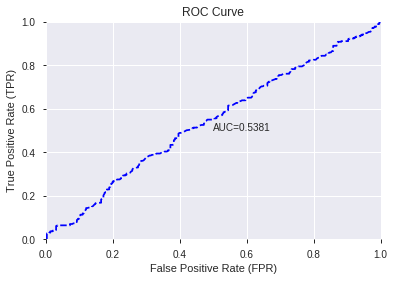

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


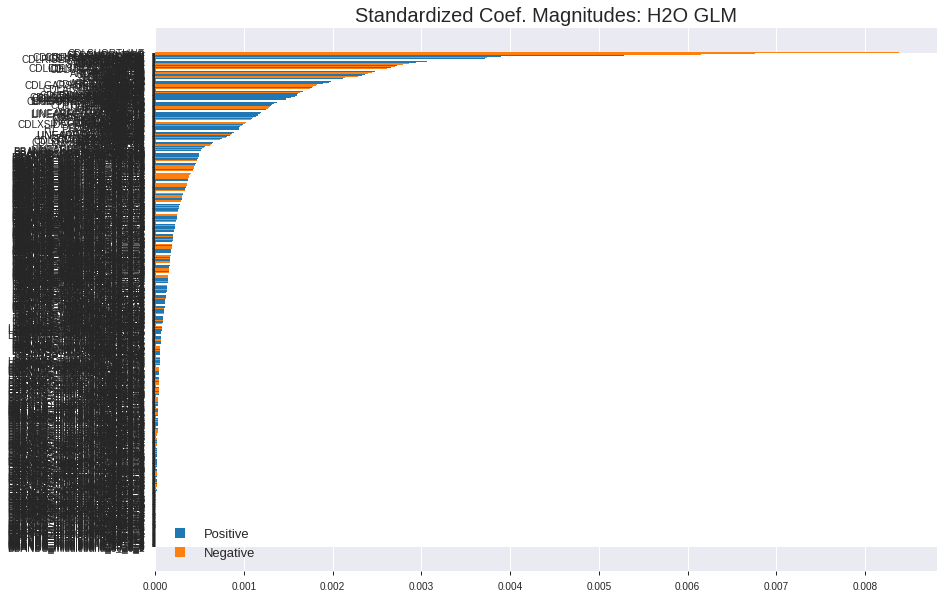

'log_likelihood'
--2019-07-25 05:21:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_052036_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_052036_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

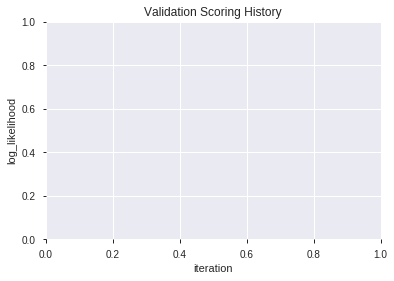

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_052236_model_4  0.545819  0.688410              0.494828  0.497624  0.247630
1  XGBoost_grid_1_AutoML_20190725_052236_model_2  0.535975  0.690176              0.494633  0.498538  0.248540
2  XGBoost_grid_1_AutoML_20190725_052236_model_5  0.535311  0.716278              0.500000  0.509812  0.259909
3               XGBoost_2_AutoML_20190725_052236  0.533228  0.695687              0.494437  0.501116  0.251117
4  XGBoost_grid_1_AutoML_20190725_052236_model_1  0.526189  0.692031              0.487931  0.499439  0.249439
5               XGBoost_3_AutoML_20190725_052236  0.526036  0.692296              0.488875  0.499554  0.249554
6  XGBoost_grid_1_AutoML_20190725_052236_model_7  0.516624  0.705447              0.498276  0.505838  0.255872
7  XGBoost_grid_1_AutoML_20190725_052236_model_3  0.514658  0.697324              0.491379  0.501983  0.251987
8               XGBoost_1_AutoML_20190725_052236  0.502842  0.701439              0.498276  0.503973  0.253988
9  XGBoost_grid_1_AutoML_20190725_052236_model_6  0.500443  0.703932              0.498276  0.505069  0.255095

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastk           115.650055           1.000000    0.021768
1                       hour           115.032089           0.994657    0.021652
2                      MFI_8           108.368362           0.937037    0.020398
3                    BETA_30            97.867699           0.846240    0.018421
4                        BOP            88.658752           0.766612    0.016688
..                       ...                  ...                ...         ...
217                   CCI_24             5.721001           0.049468    0.001077
218  BBANDS_upperband_30_7_5             5.606822           0.048481    0.001055
219               MINUS_DM_8             4.992039           0.043165    0.000940
220   BBANDS_lowerband_8_8_5             4.373616           0.037818    0.000823
221   BBANDS_upperband_8_0_2             4.214256           0.036440    0.000793

[222 rows x 4 columns]

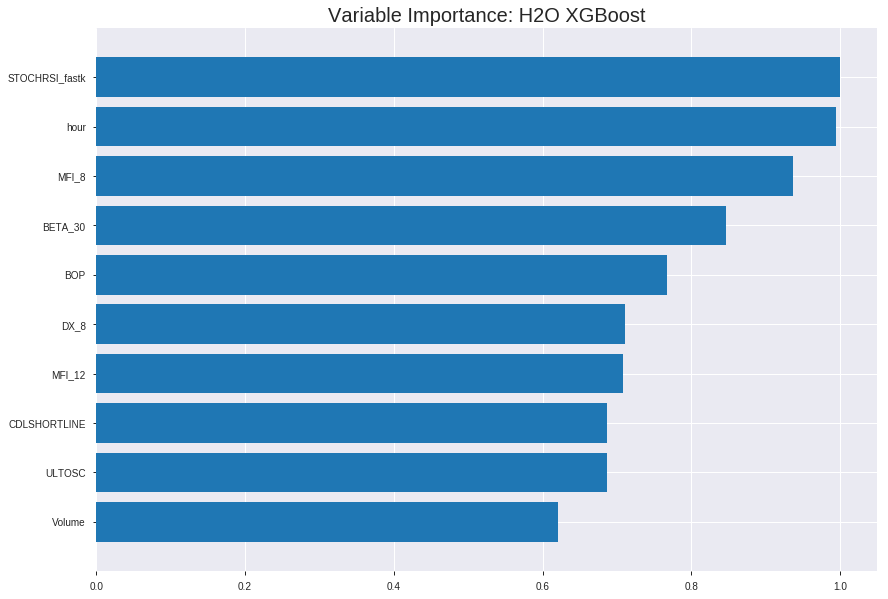

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_052236_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22469210774855994
RMSE: 0.47401699099142
LogLoss: 0.641898706507725
Mean Per-Class Error: 0.29312353112723655
AUC: 0.7738199698076956
pr_auc: 0.7670706787416017
Gini: 0.5476399396153913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47162907677037375: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1062  1098  0.5083   (1098.0/2160.0)
1      300   1859  0.139    (300.0/2159.0)
Total  1362  2957  0.3237   (1398.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471629     0.72674   246
max f2                       0.434892     0.843125  304
max f0point5                 0.515548     0.715301  173
max accuracy                 0.504204     0.706877  192
max precision                0.731114     1         0
max recall                   0.353772     1         381
max specificity              0.731114     1         0
max absolute_mcc             0.504204     0.414092  192
max min_per_class_accuracy   0.500927     0.706346  198
max mean_per_class_accuracy  0.500927     0.706876  198

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 50.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.643813           1.955     1.955              0.977273         0.664348  0.977273                    0.664348            0.0199166       0.0199166                  95.4998   95.4998
    2        0.0201436                   0.627544           1.90742   1.93148            0.953488         0.634129  0.965517                    0.649412            0.0189903       0.0389069                  90.7418   93.1482
    3        0.0300996                   0.617401           1.81437   1.89275            0.906977         0.622184  0.946154                    0.640406            0.0180639       0.0569708                  81.4374   89.2746
    4        0.0400556                   0.608629           1.72133   1.85014            0.860465         0.613188  0.924855                    0.633641            0.0171376       0.0741084                  72.1329   85.0139
    5        0.0500116                   0.603103           1.81437   1.84302            0.906977         0.605741  0.921296                    0.628087            0.0180639       0.0921723                  81.4374   84.3019
    6        0.100023                    0.581099           1.7041    1.77356            0.851852         0.591473  0.886574                    0.60978             0.0852246       0.177397                   70.4098   77.3559
    7        0.150035                    0.564896           1.49109   1.6794             0.74537          0.572155  0.839506                    0.597238            0.0745716       0.251969                   49.1086   67.9401
    8        0.200046                    0.553498           1.54665   1.64621            0.773148         0.559609  0.822917                    0.587831            0.0773506       0.329319                   54.6654   64.6214
    9        0.300069                    0.532202           1.44015   1.57753            0.719907         0.542619  0.78858                     0.57276             0.144048        0.473367                   44.0148   57.7526
    10       0.400093                    0.515983           1.27344   1.50151            0.636574         0.523913  0.750579                    0.560548            0.127374        0.600741                   27.3443   50.1505
    11       0.500116                    0.500573           1.0558    1.41236            0.527778         0.508241  0.706019                    0.550087            0.105604        0.706346                   5.58      41.2364
    12       0.599907                    0.48525            0.86795   1.3218             0.433875         0.492809  0.660749                    0.540559            0.0866142       0.79296                    -13.205   32.1804
    13       0.699931                    0.468707           0.754804  1.24078            0.377315         0.476797  0.620245                    0.531447            0.0754979       0.868458                   -24.5196  24.0777
    14       0.799954                    0.448462           0.629775  1.16438            0.314815         0.459063  0.582055                    0.522397            0.0629921       0.93145                    -37.0225  16.438
    15       0.899977                    0.419828           0.439917  1.08386            0.219907         0.435533  0.541806                    0.512742            0.0440019       0.975452                   -56.0083  8.3863
    16       1                           0.293977           0.245427  1                  0.122685         0.390891  0.499884                    0.500554           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2525059482556486
RMSE: 0.5024996997567746
LogLoss: 0.6983270951954628
Mean Per-Class Error: 0.46745077951587266
AUC: 0.5215335513613617
pr_auc: 0.5154810590559807
Gini: 0.043067102722723405
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3658101558685303: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    614   0.9919   (614.0/619.0)
1      2    613   0.0033   (2.0/615.0)
Total  7    1227  0.4992   (616.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.36581      0.665581   392
max f2                       0.284866     0.832431   399
max f0point5                 0.407357     0.556483   368
max accuracy                 0.534262     0.532415   190
max precision                0.695501     1          0
max recall                   0.284866     1          399
max specificity              0.695501     1          0
max absolute_mcc             0.534262     0.0653216  190
max min_per_class_accuracy   0.539804     0.516963   181
max mean_per_class_accuracy  0.534262     0.532549   190

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 53.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.666211           1.54346   1.54346            0.769231         0.680151  0.769231                    0.680151            0.0162602       0.0162602                  54.3465   54.3465
    2        0.0202593                   0.655395           0.668835  1.12364            0.333333         0.660312  0.56                        0.670628            0.00650407      0.0227642                  -33.1165  12.3642
    3        0.0299838                   0.642736           0.836043  1.03037            0.416667         0.648742  0.513514                    0.66353             0.00813008      0.0308943                  -16.3957  3.0367
    4        0.0405186                   0.631955           1.08043   1.04338            0.538462         0.637637  0.52                        0.656798            0.0113821       0.0422764                  8.04253   4.33821
    5        0.0502431                   0.625449           1.50488   1.1327             0.75             0.628187  0.564516                    0.65126             0.0146341       0.0569106                  50.4878   13.2704
    6        0.100486                    0.606274           0.938526  1.03562            0.467742         0.6151    0.516129                    0.63318             0.0471545       0.104065                   -6.14739  3.5615
    7        0.149919                    0.593898           1.08549   1.05206            0.540984         0.600099  0.524324                    0.622272            0.0536585       0.157724                   8.54858   5.20589
    8        0.200162                    0.583127           0.938526  1.02356            0.467742         0.588255  0.510121                    0.613733            0.0471545       0.204878                   -6.14739  2.35608
    9        0.299838                    0.567352           0.929843  0.992406           0.463415         0.575098  0.494595                    0.60089             0.0926829       0.297561                   -7.01567  -0.759394
    10       0.400324                    0.554171           1.0518    1.00731            0.524194         0.561071  0.502024                    0.590895            0.105691        0.403252                   5.17965   0.731378
    11       0.5                         0.539788           1.15823   1.0374             0.577236         0.547187  0.517018                    0.582181            0.115447        0.518699                   15.8226   3.73984
    12       0.599676                    0.526339           1.04403   1.0385             0.520325         0.533056  0.517568                    0.574016            0.104065        0.622764                   4.40346   3.85014
    13       0.700162                    0.509423           0.970889  1.0288             0.483871         0.517714  0.512731                    0.565936            0.097561        0.720325                   -2.91109  2.87978
    14       0.799838                    0.484402           0.962469  1.02053            0.479675         0.497434  0.508612                    0.557399            0.095935        0.81626                    -3.75306  2.0532
    15       0.899514                    0.447318           0.864591  1.00325            0.430894         0.468361  0.5                         0.547533            0.0861789       0.902439                   -13.5409  0.325203
    16       1                           0.284866           0.970889  1                  0.483871         0.413038  0.498379                    0.534018        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:23:37  22.397 sec  0                  0.5              0.693147            0.5             0                  1                0.500116                         0.5                0.693147              0.5               0                    1                  0.501621
    2019-07-25 05:23:39  24.204 sec  5                  0.496897         0.686955            0.635069        0.63248            1.77819          0.462607                         0.499774           0.692696              0.524374          0.514158             0.926079           0.501621
    2019-07-25 05:23:40  24.926 sec  10                 0.493684         0.68057             0.674153        0.661855           1.77314          0.426256                         0.49974            0.692627              0.517709          0.512909             1.08043            0.501621
    2019-07-25 05:23:41  25.665 sec  15                 0.490471         0.674212            0.699943        0.690989           1.90953          0.389905                         0.499896           0.692945              0.522526          0.515376             1.08043            0.498379
    2019-07-25 05:23:41  26.474 sec  20                 0.488977         0.671252            0.704019        0.693479           1.955            0.3906                           0.500156           0.693472              0.521481          0.515603             1.23477            0.501621
    2019-07-25 05:23:42  27.217 sec  25                 0.486439         0.666235            0.711597        0.705677           1.86407          0.375318                         0.500411           0.693989              0.524197          0.519768             1.23477            0.501621
    2019-07-25 05:23:43  27.972 sec  30                 0.483901         0.661226            0.722111        0.7157             1.955            0.368372                         0.500924           0.695049              0.530738          0.522806             1.08043            0.501621
    2019-07-25 05:23:44  28.763 sec  35                 0.480717         0.654984            0.740598        0.735261           1.955            0.351007                         0.501797           0.696828              0.518632          0.514166             1.38912            0.501621
    2019-07-25 05:23:44  29.535 sec  40                 0.477993         0.649646            0.752532        0.746534           1.86407          0.335263                         0.502562           0.698434              0.517874          0.511632             1.23477            0.501621
    2019-07-25 05:23:45  30.380 sec  45                 0.475807         0.64539             0.766273        0.759742           1.90953          0.323223                         0.502602           0.698527              0.518325          0.51127              1.38912            0.49919
    2019-07-25 05:23:46  31.153 sec  50                 0.474017         0.641899            0.77382         0.767071           1.955            0.323686                         0.5025             0.698327              0.521534          0.515481             1.54346            0.49919

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
STOCHRSI_fastk           115.65005493164062     1.0                   0.021768457317838247
hour                     115.03208923339844     0.9946565896695211    0.02165213951812752
MFI_8                    108.36836242675781     0.9370368435260412    0.020397846533538506
BETA_30                  97.8676986694336       0.846239967004616     0.018421338602388832
BOP                      88.65875244140625      0.7666122812808985    0.01668796672439385
---                      ---                    ---                   ---
CCI_24                   5.721000671386719      0.049468205395737465  0.0010768465177471665
BBANDS_upperband_30_7_5  5.606821537017822      0.048480924114838925  0.0010553549273232261
MINUS_DM_8               4.992038726806641      0.04316503550091157   0.0009396362329245662
BBANDS_lowerband_8_8_5   4.373615741729736      0.037817671114077106  0.0008232323595068319
BBANDS_upperband_8_0_2   4.214256286621094      0.03643972576677193   0.0007932366150277053


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5623987034035657)

('F1', 0.6950053134962806)

('auc', 0.5458188337024148)

('logloss', 0.6884103927240884)

('mean_per_class_error', 0.446984076768955)

('rmse', 0.497624329071963)

('mse', 0.24762997288432137)

xgboost prediction progress: |████████████████████████████████████████████| 100%


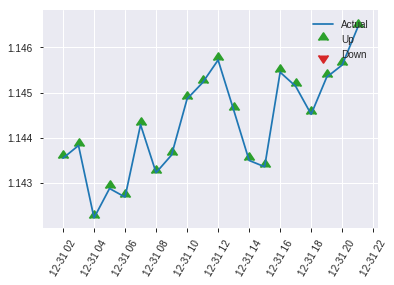


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24762997288432137
RMSE: 0.497624329071963
LogLoss: 0.6884103927240884
Mean Per-Class Error: 0.446984076768955
AUC: 0.5458188337024148
pr_auc: 0.5635010632459023
Gini: 0.09163766740482959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4349622130393982: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    287  0.9897   (287.0/290.0)
1      0    327  0        (0.0/327.0)
Total  3    614  0.4652   (287.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434962     0.695005  396
max f2                       0.434962     0.850676  396
max f0point5                 0.52981      0.593607  257
max accuracy                 0.530164     0.562399  256
max precision                0.692335     1         0
max recall                   0.434962     1         396
max specificity              0.692335     1         0
max absolute_mcc             0.530164     0.111687  256
max min_per_class_accuracy   0.546153     0.535168  206
max mean_per_class_accuracy  0.530164     0.553016  256

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 54.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.651644           1.6173    1.6173             0.857143         0.664154  0.857143                    0.664154            0.0183486       0.0183486                  61.73     61.73
    2        0.0210697                   0.644374           0.62895   1.16114            0.333333         0.646757  0.615385                    0.656125            0.00611621      0.0244648                  -37.105   16.1139
    3        0.0307942                   0.637209           0.943425  1.09239            0.5              0.640601  0.578947                    0.651222            0.00917431      0.0336391                  -5.65749  9.23869
    4        0.0405186                   0.634587           1.57238   1.20758            0.833333         0.635848  0.64                        0.647533            0.0152905       0.0489297                  57.2375   20.7584
    5        0.0502431                   0.628843           0.62895   1.09559            0.333333         0.632804  0.580645                    0.644682            0.00611621      0.0550459                  -37.105   9.55904
    6        0.100486                    0.611257           1.09559   1.09559            0.580645         0.622027  0.580645                    0.633354            0.0550459       0.110092                   9.55904   9.55904
    7        0.150729                    0.595878           1.03472   1.0753             0.548387         0.601635  0.569892                    0.622781            0.0519878       0.16208                    3.47243   7.53017
    8        0.200972                    0.585054           0.852126  1.01951            0.451613         0.589274  0.540323                    0.614404            0.0428135       0.204893                   -14.7874  1.95077
    9        0.299838                    0.570309           1.02076   1.01992            0.540984         0.577458  0.540541                    0.602222            0.100917        0.30581                    2.0755    1.9919
    10       0.400324                    0.558516           1.15646   1.05419            0.612903         0.564648  0.558704                    0.592791            0.116208        0.422018                   15.6457   5.41916
    11       0.50081                     0.546153           1.12602   1.0686             0.596774         0.552055  0.566343                    0.584617            0.11315         0.535168                   12.6023   6.86045
    12       0.599676                    0.537838           1.11355   1.07601            0.590164         0.541792  0.57027                     0.577557            0.110092        0.64526                    11.3551   7.60145
    13       0.700162                    0.525839           0.943425  1.05699            0.5              0.531603  0.560185                    0.570962            0.0948012       0.740061                   -5.65749  5.69855
    14       0.799028                    0.509089           0.897027  1.03719            0.47541          0.517483  0.549696                    0.564345            0.088685        0.828746                   -10.2973  3.71935
    15       0.899514                    0.492931           0.882559  1.01992            0.467742         0.501825  0.540541                    0.55736             0.088685        0.917431                   -11.7441  1.9919
    16       1                           0.412641           0.821693  1                  0.435484         0.467007  0.529984                    0.548281            0

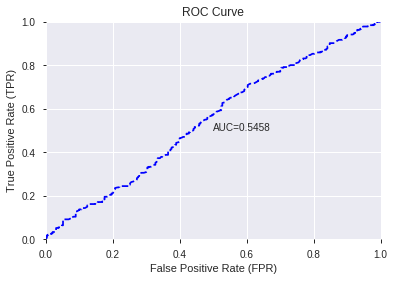

This function is available for GLM models only


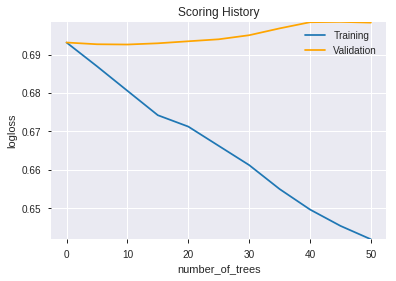

--2019-07-25 05:24:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.131.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.131.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_052236_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_052236_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_052527_model_5  0.534235  0.693641              0.496357  0.500238  0.250238
1  DeepLearning_grid_1_AutoML_20190725_052527_model_7  0.531846  0.774409              0.496162  0.521347  0.271803
2  DeepLearning_grid_1_AutoML_20190725_052527_model_9  0.527597  0.691456              0.500000  0.499152  0.249152
3               DeepLearning_1_AutoML_20190725_052527  0.515955  0.716824              0.494633  0.510577  0.260689
4  DeepLearning_grid_1_AutoML_20190725_052527_model_6  0.509644  0.697996              0.492713  0.502078  0.252083
5  DeepLearning_grid_1_AutoML_20190725_052527_model_3  0.501471  0.777159              0.498276  0.524696  0.275306
6  DeepLearning_grid_1_AutoML_20190725_052527_model_2  0.496752  0.933601              0.500000  0.554231  0.307171
7  DeepLearning_grid_1_AutoML_20190725_052527_model_8  0.483112  0.695428              0.500000  0.500943  0.250943
8  DeepLearning_grid_1_AutoML_20190725_052527_model_1  0.477370  1.218195              0.500000  0.578656  0.334843
9  DeepLearning_grid_1_AutoML_20190725_052527_model_4  0.461684  0.790828              0.496357  0.539526  0.291088

variable  relative_importance  scaled_importance  percentage
0        is_month_start             1.000000           1.000000    0.022522
1      is_quarter_start             0.973916           0.973916    0.021935
2                   day             0.969205           0.969205    0.021829
3             CDLONNECK             0.960176           0.960176    0.021625
4        CDLMORNINGSTAR             0.936655           0.936655    0.021096
5             aroonup_8             0.929045           0.929045    0.020924
6     CDLSTALLEDPATTERN             0.926457           0.926457    0.020866
7              CORREL_8             0.925785           0.925785    0.020851
8    CDLIDENTICAL3CROWS             0.922249           0.922249    0.020771
9           CDLPIERCING             0.918841           0.918841    0.020694
10         HT_TRENDMODE             0.917923           0.917923    0.020674
11            CDLTAKURI             0.913119           0.913119    0.020566
12         aroondown_24             0.912475           0.912475    0.020551
13      CDLUNIQUE3RIVER             0.910891           0.910891    0.020515
14         CDLTHRUSTING             0.909486           0.909486    0.020484
15         weekday_name             0.908961           0.908961    0.020472
16           aroonup_30             0.905801           0.905801    0.020401
17          HT_DCPERIOD             0.905164           0.905164    0.020386
18    CDL3WHITESOLDIERS             0.897838           0.897838    0.020221
19       STOCHRSI_fastk             0.896416           0.896416    0.020189
20         aroondown_20             0.895678           0.895678    0.020173
21            CDLINNECK             0.894584           0.894584    0.020148
22    CDLDARKCLOUDCOVER             0.892961           0.892961    0.020112
23                  BOP             0.892399           0.892399    0.020099
24   CDLEVENINGDOJISTAR             0.889432           0.889432    0.020032
25           aroonup_20             0.886132           0.886132    0.019958
26       CDLEVENINGSTAR             0.885953           0.885953    0.019954
27           aroonup_24             0.885694           0.885694    0.019948
28            CORREL_24             0.885001           0.885001    0.019932
29         aroondown_12             0.883078           0.883078    0.019889
30         is_month_end             0.881826           0.881826    0.019861
31           aroonup_12             0.879442           0.879442    0.019807
32  CDLGAPSIDESIDEWHITE             0.878597           0.878597    0.019788
33            CORREL_30             0.877515           0.877515    0.019764
34           aroonup_14             0.874551           0.874551    0.019697
35   CDLMORNINGDOJISTAR             0.874278           0.874278    0.019691
36                 hour             0.872041           0.872041    0.019640
37       CDL3BLACKCROWS             0.866789           0.866789    0.019522
38          aroondown_8             0.866317           0.866317    0.019512
39         aroondown_14             0.862461           0.862461    0.019425
40      CDLSHOOTINGSTAR             0.856638           0.856638    0.019294
41               SAREXT             0.854673           0.854673    0.019249
42    CDLGRAVESTONEDOJI             0.832734           0.832734    0.018755
43            CDLHAMMER             0.828893           0.828893    0.018669
44       CDLRICKSHAWMAN             0.823324           0.823324    0.018543
45       CDLMATCHINGLOW             0.822709           0.822709    0.018529
46    CDLINVERTEDHAMMER             0.822151           0.822151    0.018517
47         CDLSHORTLINE             0.813386           0.813386    0.018319
48      CDLHOMINGPIGEON             0.798884           0.798884    0.017993
49      CDLADVANCEBLOCK             0.781785           0.781785    0.017608

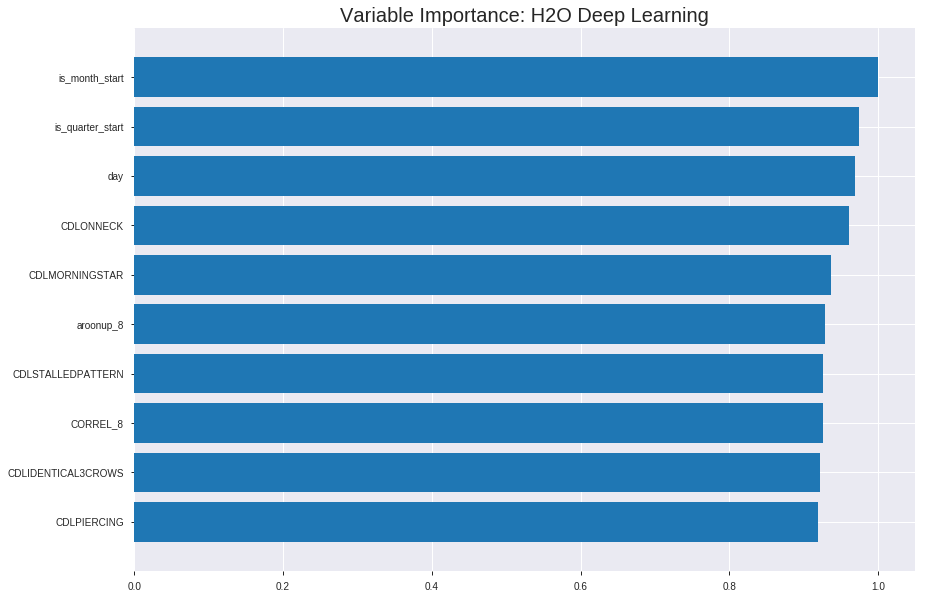

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_052527_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2481764609914021
RMSE: 0.4981731235137059
LogLoss: 0.689491199712521
Mean Per-Class Error: 0.4579981730224898
AUC: 0.553157754790455
pr_auc: 0.5453186791071158
Gini: 0.10631550958091007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36736159648251776: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      0    2160  1        (2160.0/2160.0)
1      0    2159  0        (0.0/2159.0)
Total  0    4319  0.5001   (2160.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367362     0.666564  399
max f2                       0.367362     0.833269  399
max f0point5                 0.446715     0.560115  301
max accuracy                 0.491167     0.542024  187
max precision                0.579903     0.697674  22
max recall                   0.367362     1         399
max specificity              0.662587     0.999537  0
max absolute_mcc             0.500544     0.086617  163
max min_per_class_accuracy   0.481492     0.53358   212
max mean_per_class_accuracy  0.491167     0.542002  187

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 48.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.578825           1.36395   1.36395            0.681818         0.597205  0.681818                    0.597205            0.0138953       0.0138953                  36.3952    36.3952
    2        0.0201436                   0.569268           1.16306   1.26466            0.581395         0.573871  0.632184                    0.585672            0.0115794       0.0254748                  16.306     26.4661
    3        0.0300996                   0.561131           1.02349   1.18489            0.511628         0.564729  0.592308                    0.578745            0.0101899       0.0356647                  2.34928    18.489
    4        0.0400556                   0.554474           1.20958   1.19103            0.604651         0.557803  0.595376                    0.573539            0.0120426       0.0477073                  20.9582    19.1027
    5        0.0500116                   0.549922           1.20958   1.19472            0.604651         0.55199   0.597222                    0.569249            0.0120426       0.0597499                  20.9582    19.4721
    6        0.100023                    0.533418           1.07432   1.13452            0.537037         0.54049   0.56713                     0.55487             0.0537286       0.113478                   7.43228    13.4522
    7        0.150035                    0.524179           1.14841   1.13915            0.574074         0.528565  0.569444                    0.546102            0.057434        0.170912                   14.8414    13.9153
    8        0.200046                    0.516378           1.12989   1.13684            0.564815         0.520354  0.568287                    0.539665            0.0565076       0.22742                    12.9891    13.6837
    9        0.300069                    0.503345           1.116     1.12989            0.55787          0.50939   0.564815                    0.529573            0.111626        0.339046                   11.5999    12.9891
    10       0.400093                    0.491651           1.01875   1.10211            0.509259         0.49754   0.550926                    0.521565            0.101899        0.440945                   1.87544    10.2107
    11       0.500116                    0.481263           0.935402  1.06877            0.467593         0.486443  0.534259                    0.51454             0.0935618       0.534507                   -6.45982   6.8766
    12       0.599907                    0.46998            1.01184   1.0593             0.5058           0.475815  0.529525                    0.508099            0.100973        0.635479                   1.18352    5.92958
    13       0.699931                    0.459367           0.92614   1.04027            0.462963         0.464645  0.520013                    0.501889            0.0926355       0.728115                   -7.38596   4.02673
    14       0.799954                    0.449118           0.99097   1.0341             0.49537          0.454237  0.516932                    0.495931            0.09912         0.827235                   -0.902981  3.41034
    15       0.899977                    0.435621           0.884464  1.01747            0.44213          0.442808  0.508618                    0.490027            0.0884669       0.915702                   -11.5536   1.74725
    16       1                           0.367362           0.842788  1                  0.421296         0.420601  0.499884                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.251015540859944
RMSE: 0.5010145116261044
LogLoss: 0.6952307167920128
Mean Per-Class Error: 0.47735004005936665
AUC: 0.5141468668321578
pr_auc: 0.5069718146852085
Gini: 0.028293733664315646
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33705858938165134: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    615   0        (0.0/615.0)
Total  0    1234  0.5016   (619.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.337059     0.665224   399
max f2                       0.337059     0.832431   399
max f0point5                 0.417641     0.555861   380
max accuracy                 0.515787     0.523501   122
max precision                0.536343     0.556338   74
max recall                   0.337059     1          399
max specificity              0.623762     0.996769   0
max absolute_mcc             0.603029     0.0635772  3
max min_per_class_accuracy   0.484101     0.502439   212
max mean_per_class_accuracy  0.514682     0.52265    125

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 48.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.588837           0.617386  0.617386           0.307692         0.600739  0.307692                    0.600739            0.00650407      0.00650407                 -38.2614  -38.2614
    2        0.0202593                   0.575787           0.836043  0.722341           0.416667         0.582387  0.36                        0.59193             0.00813008      0.0146341                  -16.3957  -27.7659
    3        0.0299838                   0.563004           1.8393    1.0846             0.916667         0.568705  0.540541                    0.584398            0.0178862       0.0325203                  83.9295   8.45968
    4        0.0405186                   0.557559           0.617386  0.963122           0.307692         0.559462  0.48                        0.577915            0.00650407      0.0390244                  -38.2614  -3.6878
    5        0.0502431                   0.554011           1.17046   1.00325            0.583333         0.555245  0.5                         0.573527            0.0113821       0.0504065                  17.0461   0.325203
    6        0.100486                    0.539173           1.06798   1.03562            0.532258         0.546337  0.516129                    0.559932            0.0536585       0.104065                   6.7978    3.5615
    7        0.149919                    0.530151           1.0197    1.03037            0.508197         0.534555  0.513514                    0.551565            0.0504065       0.154472                   1.96988   3.0367
    8        0.200162                    0.5205             1.22979   1.08043            0.612903         0.524639  0.538462                    0.544806            0.0617886       0.21626                    22.9793   8.04253
    9        0.299838                    0.506073           0.978782  1.04664            0.487805         0.512989  0.521622                    0.534229            0.097561        0.313821                   -2.12175  4.66359
    10       0.400324                    0.493469           1.00325   1.03575            0.5              0.499189  0.516194                    0.525433            0.100813        0.414634                   0.325203  3.5746
    11       0.5                         0.483738           0.91353   1.01138            0.455285         0.488487  0.504052                    0.518068            0.0910569       0.505691                   -8.64697  1.13821
    12       0.599676                    0.472605           1.02772   1.0141             0.512195         0.478345  0.505405                    0.511466            0.102439        0.60813                    2.77216   1.4098
    13       0.700162                    0.461863           0.987071  1.01022            0.491935         0.467316  0.503472                    0.505129            0.099187        0.707317                   -1.29295  1.02191
    14       0.799838                    0.451064           0.946156  1.00224            0.471545         0.456477  0.499493                    0.499066            0.0943089       0.801626                   -5.38436  0.223557
    15       0.899514                    0.437827           1.04403   1.00687            0.520325         0.444493  0.501802                    0.493019            0.104065        0.905691                   4.40346   0.686736
    16       1                           0.337059           0.938526  1                  0.467742         0.423425  0.498379                    0.486026        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:31:29  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:31:32  2 min 44.299 sec  1190 obs/sec      0.623755  1             2694       0.498173         0.689491            0.0072941      0.553158        0.545319           1.36395          0.500116                         0.501015           0.695231              -0.00407271      0.514147          0.506972             0.617386           0.501621
    2019-07-25 05:31:49  3 min  1.660 sec  2512 obs/sec      10.4621   17            45186      0.493765         0.679972            0.0247849      0.587413        0.592812           1.72767          0.48113                          0.504533           0.703315              -0.0182236       0.517998          0.516679             1.38912            0.501621
    2019-07-25 05:32:06  3 min 18.205 sec  2824 obs/sec      21.5154   35            92925      0.492645         0.676216            0.0292054      0.612128        0.619964           1.955            0.466543                         0.513862           0.726797              -0.0562287       0.508791          0.509339             1.23477            0.501621
    2019-07-25 05:32:22  3 min 34.944 sec  2992 obs/sec      33.2556   54            143631     0.477969         0.645334            0.0861826      0.658237        0.671276           1.90953          0.434823                         0.510056           0.722482              -0.0406382       0.503773          0.500722             1.08043            0.501621
    2019-07-25 05:32:39  3 min 51.953 sec  3107 obs/sec      45.5355   74            196668     0.467695         0.621565            0.125047       0.691103        0.714751           2.00046          0.41329                          0.515433           0.74088               -0.0626977       0.50684           0.505224             1.08043            0.501621
    2019-07-25 05:32:57  4 min  9.628 sec  3184 obs/sec      58.479    95            252571     0.466689         0.615503            0.128805       0.724246        0.739615           2.00046          0.383191                         0.526464           0.773845              -0.10867         0.514411          0.512511             1.23477            0.501621
    2019-07-25 05:32:59  4 min 11.295 sec  3184 obs/sec      58.479    95            252571     0.498173         0.689491            0.0072941      0.553158        0.545319           1.36395          0.500116                         0.501015           0.695231              -0.00407271      0.514147          0.506972             0.617386           0.501621

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
is_month_start     1.0                    1.0                  0.022522363528339646
is_quarter_start   0.9739162921905518     0.9739162921905518   0.021934896778888262
day                0.9692046046257019     0.9692046046257019   0.021828778438720754
CDLONNECK          0.9601757526397705     0.9601757526397705   0.021625427352050038
CDLMORNINGSTAR     0.9366550445556641     0.9366550445556641   0.021095685414135833
---                ---                    ---                  ---
CDLMATCHINGLOW     0.8227094411849976     0.8227094411849976   0.01852936111256568
CDLINVERTEDHAMMER  0.8221509456634521     0.8221509456634521   0.018516782473400484
CDLSHORTLINE       0.8133856058120728     0.8133856058120728   0.018319366302818274
CDLHOMINGPIGEON    0.7988843321800232     0.7988843321800232   0.01799276334645333
CDLADVANCEBLOCK    0.7817854881286621     0.7817854881286621   0.017607656964814186


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.546191247974068)

('F1', 0.6936170212765956)

('auc', 0.53423494674681)

('logloss', 0.693641071654704)

('mean_per_class_error', 0.4574449014025097)

('rmse', 0.5002378097772132)

('mse', 0.2502378663307034)

deeplearning prediction progress: |███████████████████████████████████████| 100%


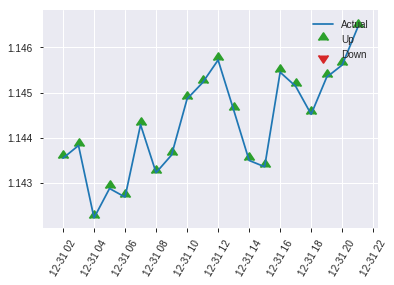


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2502378663307034
RMSE: 0.5002378097772132
LogLoss: 0.693641071654704
Mean Per-Class Error: 0.4574449014025097
AUC: 0.53423494674681
pr_auc: 0.5737956057335586
Gini: 0.0684698934936201
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3876045935557055: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    287  0.9897   (287.0/290.0)
1      1    326  0.0031   (1.0/327.0)
Total  4    613  0.4668   (288.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387605     0.693617  395
max f2                       0.374482     0.849351  399
max f0point5                 0.426713     0.590133  362
max accuracy                 0.470689     0.546191  231
max precision                0.549712     0.8       31
max recall                   0.374482     1         399
max specificity              0.64013      0.996552  0
max absolute_mcc             0.539621     0.145424  45
max min_per_class_accuracy   0.479509     0.531034  203
max mean_per_class_accuracy  0.533989     0.542555  54

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 48.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.580134           0.80865   0.80865            0.428571         0.59736   0.428571                    0.59736             0.00917431      0.00917431                 -19.135   -19.135
    2        0.0210697                   0.564194           1.88685   1.30628            1                0.572409  0.692308                    0.585844            0.0183486       0.0275229                  88.685    30.6281
    3        0.0307942                   0.556918           1.88685   1.48962            1                0.560631  0.789474                    0.577882            0.0183486       0.0458716                  88.685    48.9619
    4        0.0405186                   0.552905           1.2579    1.43401            0.666667         0.555257  0.76                        0.572452            0.0122324       0.058104                   25.79     43.4006
    5        0.0502431                   0.55068            1.57238   1.46079            0.833333         0.551593  0.774194                    0.568415            0.0152905       0.0733945                  57.2375   46.0787
    6        0.100486                    0.534225           1.27819   1.36949            0.677419         0.542087  0.725806                    0.555251            0.0642202       0.137615                   27.8189   36.9488
    7        0.150729                    0.523715           0.669527  1.13617            0.354839         0.529529  0.602151                    0.546677            0.0336391       0.171254                   -33.0473  13.6168
    8        0.200972                    0.513377           0.912992  1.08037            0.483871         0.518211  0.572581                    0.53956             0.0458716       0.217125                   -8.7008   8.03739
    9        0.299838                    0.50012            0.866095  1.00972            0.459016         0.506072  0.535135                    0.528518            0.0856269       0.302752                   -13.3905  0.971981
    10       0.400324                    0.489454           1.12602   1.03891            0.596774         0.494381  0.550607                    0.519949            0.11315         0.415902                   12.6023   3.89134
    11       0.50081                     0.479701           1.12602   1.05639            0.596774         0.484152  0.559871                    0.512767            0.11315         0.529052                   12.6023   5.63918
    12       0.599676                    0.468465           1.05169   1.05562            0.557377         0.474181  0.559459                    0.506405            0.103976        0.633028                   5.1687    5.56162
    13       0.700162                    0.456134           0.79126   1.01768            0.419355         0.462565  0.539352                    0.500113            0.0795107       0.712538                   -20.874   1.76761
    14       0.799028                    0.446725           0.927959  1.00658            0.491803         0.451184  0.533469                    0.494059            0.0917431       0.804281                   -7.20409  0.657523
    15       0.899514                    0.434883           1.00429   1.00632            0.532258         0.44106   0.533333                    0.488138            0.100917        0.905199                   0.429121  0.632008
    16       1                           0.374482           0.943425  1                  0.5              0.41739   0.529984                    0.481029      

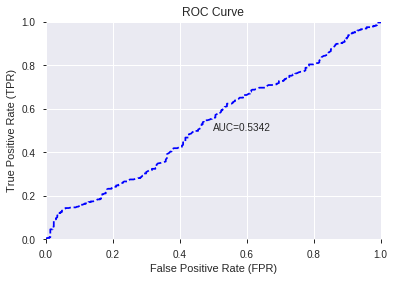

This function is available for GLM models only


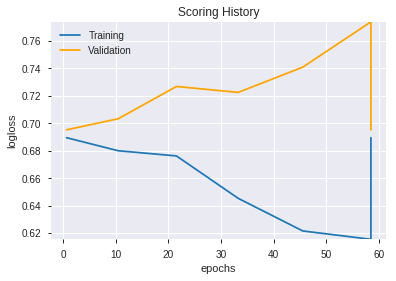

--2019-07-25 05:47:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_052527_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_052527_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['is_month_start',
 'is_quarter_start',
 'day',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'aroonup_8',
 'CDLSTALLEDPATTERN',
 'CORREL_8',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'aroondown_24',
 'CDLUNIQUE3RIVER',
 'CDLTHRUSTING',
 'weekday_name',
 'aroonup_30',
 'HT_DCPERIOD',
 'CDL3WHITESOLDIERS',
 'STOCHRSI_fastk',
 'aroondown_20',
 'CDLINNECK',
 'CDLDARKCLOUDCOVER',
 'BOP',
 'CDLEVENINGDOJISTAR',
 'aroonup_20',
 'CDLEVENINGSTAR',
 'aroonup_24',
 'CORREL_24',
 'aroondown_12',
 'is_month_end',
 'aroonup_12',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_30',
 'aroonup_14',
 'CDLMORNINGDOJISTAR',
 'hour',
 'CDL3BLACKCROWS',
 'aroondown_8',
 'aroondown_14',
 'CDLSHOOTINGSTAR',
 'SAREXT',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLRICKSHAWMAN',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'CDLSHORTLINE',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_054815_model_1  0.531952  0.691637              0.493103  0.499248  0.249248

variable  relative_importance  scaled_importance  percentage
0          CDLSHORTLINE             0.018202           1.000000    0.063007
1             aroonup_8             0.017789           0.977302    0.061577
2                  hour             0.016905           0.928732    0.058517
3        STOCHRSI_fastk             0.016423           0.902231    0.056847
4                   BOP             0.014549           0.799321    0.050363
5        is_month_start             0.011735           0.644711    0.040621
6             CORREL_24             0.011687           0.642080    0.040456
7        CDLRICKSHAWMAN             0.008920           0.490066    0.030878
8          aroondown_20             0.008716           0.478847    0.030171
9       CDLHOMINGPIGEON             0.008600           0.472463    0.029769
10    CDLGRAVESTONEDOJI             0.008330           0.457638    0.028834
11         CDLTHRUSTING             0.008097           0.444857    0.028029
12            CDLONNECK             0.007709           0.423538    0.026686
13           aroonup_14             0.006788           0.372949    0.023498
14           aroonup_30             0.006613           0.363287    0.022890
15           aroonup_12             0.006462           0.355025    0.022369
16         aroondown_24             0.006265           0.344217    0.021688
17      CDLUNIQUE3RIVER             0.005989           0.329016    0.020730
18       CDL3BLACKCROWS             0.005974           0.328180    0.020678
19   CDLIDENTICAL3CROWS             0.005939           0.326300    0.020559
20         HT_TRENDMODE             0.005197           0.285538    0.017991
21            CORREL_30             0.005086           0.279407    0.017605
22            CDLINNECK             0.004878           0.268006    0.016886
23         is_month_end             0.004809           0.264172    0.016645
24           aroonup_24             0.004392           0.241296    0.015203
25            CDLTAKURI             0.004254           0.233722    0.014726
26  CDLGAPSIDESIDEWHITE             0.003983           0.218804    0.013786
27         aroondown_12             0.003883           0.213346    0.013442
28      CDLADVANCEBLOCK             0.003865           0.212319    0.013378
29               SAREXT             0.003793           0.208394    0.013130
30             CORREL_8             0.003769           0.207068    0.013047
31            CDLHAMMER             0.003684           0.202399    0.012753
32       CDLEVENINGSTAR             0.003667           0.201465    0.012694
33          CDLPIERCING             0.003600           0.197756    0.012460
34    CDL3WHITESOLDIERS             0.003450           0.189563    0.011944
35   CDLMORNINGDOJISTAR             0.003302           0.181383    0.011428
36    CDLINVERTEDHAMMER             0.003259           0.179039    0.011281
37         aroondown_14             0.002901           0.159359    0.010041
38          HT_DCPERIOD             0.002752           0.151210    0.009527
39          aroondown_8             0.002653           0.145767    0.009184
40           aroonup_20             0.002325           0.127705    0.008046
41       CDLMORNINGSTAR             0.001488           0.081736    0.005150
42    CDLSTALLEDPATTERN             0.001478           0.081195    0.005116
43      CDLSHOOTINGSTAR             0.001283           0.070510    0.004443
44         weekday_name             0.000962           0.052826    0.003328
45                  day             0.000888           0.048789    0.003074
46       CDLMATCHINGLOW             0.000798           0.043831    0.002762
47     is_quarter_start             0.000387           0.021235    0.001338
48   CDLEVENINGDOJISTAR             0.000343           0.018860    0.001188
49    CDLDARKCLOUDCOVER             0.000068           0.003734    0.000235

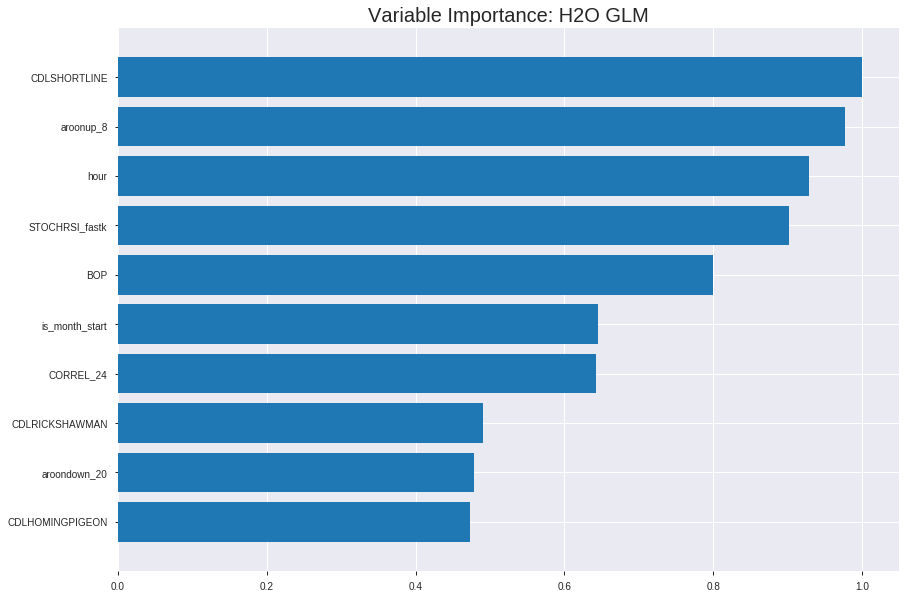

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_054815_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24836225089028108
RMSE: 0.49835955984638347
LogLoss: 0.6898635787230413
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5987.405114141723
Residual deviance: 5959.04159300963
AIC: 6061.04159300963
AUC: 0.5646598862642169
pr_auc: 0.5607197938272499
Gini: 0.12931977252843385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46033796197496574: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      8    2152  0.9963   (2152.0/2160.0)
1      2    2157  0.0009   (2.0/2159.0)
Total  10   4309  0.4987   (2154.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460338     0.666976  393
max f2                       0.450393     0.833398  398
max f0point5                 0.485518     0.560794  302
max accuracy                 0.502512     0.553137  193
max precision                0.67201      1         0
max recall                   0.450393     1         398
max specificity              0.67201      1         0
max absolute_mcc             0.502512     0.107616  193
max min_per_class_accuracy   0.499343     0.548611  215
max mean_per_class_accuracy  0.502512     0.553119  193

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 49.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.539591           1.31849   1.31849            0.659091         0.554402  0.659091                    0.554402            0.0134321       0.0134321                  31.8487   31.8487
    2        0.0201436                   0.534697           1.48872   1.40262            0.744186         0.53686   0.701149                    0.545732            0.0148217       0.0282538                  48.8717   40.2624
    3        0.0300996                   0.531288           1.16306   1.32338            0.581395         0.53299   0.661538                    0.541517            0.0115794       0.0398333                  16.306    32.3383
    4        0.0400556                   0.527927           1.11654   1.27197            0.55814          0.529744  0.635838                    0.538591            0.0111163       0.0509495                  11.6538   27.1971
    5        0.0500116                   0.525859           1.02349   1.22251            0.511628         0.52681   0.611111                    0.536245            0.0101899       0.0611394                  2.34928   22.2505
    6        0.100023                    0.5198             1.19472   1.20861            0.597222         0.522771  0.604167                    0.529508            0.0597499       0.120889                   19.4721   20.8613
    7        0.150035                    0.515676           1.12989   1.18237            0.564815         0.517584  0.591049                    0.525533            0.0565076       0.177397                   12.9891   18.2373
    8        0.200046                    0.512453           1.16694   1.17851            0.583333         0.514003  0.58912                     0.522651            0.0583604       0.235757                   16.6937   17.8514
    9        0.300069                    0.50741            1.08358   1.14687            0.541667         0.509787  0.573302                    0.518363            0.108384        0.344141                   8.35842   14.687
    10       0.400093                    0.503305           1.05117   1.12295            0.525463         0.505281  0.561343                    0.515092            0.105141        0.449282                   5.11693   12.2945
    11       0.500116                    0.499329           1.00949   1.10025            0.50463          0.501212  0.55                        0.512316            0.100973        0.550255                   0.949299  10.0255
    12       0.599907                    0.495589           0.932931  1.07242            0.466357         0.497455  0.536086                    0.509844            0.0930987       0.643353                   -6.70694  7.24212
    13       0.699931                    0.49128            0.902987  1.04821            0.451389         0.493337  0.523983                    0.507485            0.0903196       0.733673                   -9.70131  4.82083
    14       0.799954                    0.486246           0.944663  1.03526            0.472222         0.488744  0.517511                    0.505142            0.0944882       0.828161                   -5.53368  3.52614
    15       0.899977                    0.480402           0.893725  1.01953            0.446759         0.483513  0.509648                    0.502738            0.0893932       0.917554                   -10.6275  1.95311
    16       1                           0.400578           0.824265  1                  0.412037         0.474206  0.499884                    0.499884          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24956908973034894
RMSE: 0.49956890388648983
LogLoss: 0.6922752201325444
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1710.685455494171
Residual deviance: 1708.5352432871196
AIC: 1810.5352432871196
AUC: 0.5180240881568752
pr_auc: 0.5166502124702461
Gini: 0.036048176313750346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4519665225781068: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    615   0        (0.0/615.0)
Total  1    1233  0.5008   (618.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.451967     0.665584   398
max f2                       0.451967     0.832656   398
max f0point5                 0.4784       0.560621   346
max accuracy                 0.50876      0.52188    139
max precision                0.669497     1          0
max recall                   0.451967     1          398
max specificity              0.669497     1          0
max absolute_mcc             0.4784       0.0736234  346
max min_per_class_accuracy   0.499731     0.500813   203
max mean_per_class_accuracy  0.50876      0.521203   139

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 50.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.538547           0.926079  0.926079           0.461538         0.557346  0.461538                    0.557346            0.0097561       0.0097561                  -7.39212   -7.39212
    2        0.0202593                   0.532835           1.50488   1.2039             0.75             0.535703  0.6                         0.546957            0.0146341       0.0243902                  50.4878    20.3902
    3        0.0299838                   0.529908           1.00325   1.13883            0.5              0.531047  0.567568                    0.541797            0.0097561       0.0341463                  0.325203   13.8827
    4        0.0405186                   0.528825           0.926079  1.08351            0.461538         0.529318  0.54                        0.538553            0.0097561       0.0439024                  -7.39212   8.35122
    5        0.0502431                   0.527473           0.668835  1.00325            0.333333         0.528     0.5                         0.53651             0.00650407      0.0504065                  -33.1165   0.325203
    6        0.100486                    0.520465           1.16507   1.08416            0.580645         0.523088  0.540323                    0.529799            0.0585366       0.108943                   16.5067    8.41595
    7        0.149919                    0.516316           1.11838   1.09544            0.557377         0.51838   0.545946                    0.526034            0.0552846       0.164228                   11.8379    9.54428
    8        0.200162                    0.512611           0.938526  1.05605            0.467742         0.514216  0.526316                    0.523068            0.0471545       0.211382                   -6.14739   5.60548
    9        0.299838                    0.508067           1.02772   1.04664            0.512195         0.51042   0.521622                    0.518863            0.102439        0.313821                   2.77216    4.66359
    10       0.400324                    0.503511           1.03562   1.04387            0.516129         0.505799  0.520243                    0.515584            0.104065        0.417886                   3.5615     4.38695
    11       0.5                         0.499532           0.848278  1.00488            0.422764         0.501537  0.50081                     0.512784            0.0845528       0.502439                   -15.1722   0.487805
    12       0.599676                    0.495765           0.962469  0.997829           0.479675         0.497601  0.497297                    0.51026             0.095935        0.598374                   -3.75306   -0.217095
    13       0.700162                    0.491346           1.01943   1.00093            0.508065         0.49347   0.498843                    0.50785             0.102439        0.700813                   1.94335    0.092969
    14       0.799838                    0.486754           1.15823   1.02053            0.577236         0.489141  0.508612                    0.505519            0.115447        0.81626                    15.8226    2.0532
    15       0.899514                    0.479588           0.995096  1.01771            0.495935         0.483232  0.507207                    0.503049            0.099187        0.915447                   -0.490449  1.77133
    16       1                           0.445377           0.841437  1                  0.419355         0.473428  0.498379               


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:48:15  0.000 sec   2            2.6       51            1.38299           1.38506
    2019-07-25 05:48:15  0.024 sec   4            1.6       51            1.38154           1.38474
    2019-07-25 05:48:15  0.046 sec   6            1         51            1.37973           1.38455
    2019-07-25 05:48:15  0.072 sec   8            0.63      51            1.37765           1.38462
    2019-07-25 05:48:15  0.095 sec   10           0.39      51            1.37548           1.3851
    2019-07-25 05:48:15  0.119 sec   12           0.24      51            1.37346           1.386
    2019-07-25 05:48:15  0.134 sec   14           0.15      51            1.37175           1.38724
    2019-07-25 05:48:15  0.150 sec   16           0.094     51            1.37044           1.38863

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5364667747163695)

('F1', 0.6957446808510638)

('auc', 0.5319519139512812)

('logloss', 0.6916365014780119)

('mean_per_class_error', 0.4553253189918802)

('rmse', 0.4992478968228334)

('mse', 0.24924846248202248)

glm prediction progress: |████████████████████████████████████████████████| 100%


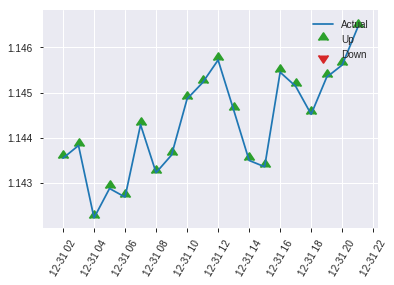


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24924846248202248
RMSE: 0.4992478968228334
LogLoss: 0.6916365014780119
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.3607874834584
Residual deviance: 853.4794428238665
AIC: 955.4794428238665
AUC: 0.5319519139512812
pr_auc: 0.5762714370933004
Gini: 0.06390382790256233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4668874412500198: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    286  0.9862   (286.0/290.0)
1      0    327  0        (0.0/327.0)
Total  4    613  0.4635   (286.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466887     0.695745  395
max f2                       0.466887     0.851119  395
max f0point5                 0.466887     0.588341  395
max accuracy                 0.466887     0.536467  395
max precision                0.621246     1         0
max recall                   0.466887     1         395
max specificity              0.621246     1         0
max absolute_mcc             0.520937     0.117467  34
max min_per_class_accuracy   0.497891     0.525994  198
max mean_per_class_accuracy  0.507605     0.544675  116

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 49.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.536179           1.0782    1.0782             0.571429         0.552126  0.571429                    0.552126            0.0122324       0.0122324                  7.82001   7.82001
    2        0.0210697                   0.531725           1.88685   1.45142            1                0.533282  0.769231                    0.543429            0.0183486       0.030581                   88.685    45.1423
    3        0.0307942                   0.527387           1.57238   1.48962            0.833333         0.528748  0.789474                    0.538793            0.0152905       0.0458716                  57.2375   48.9619
    4        0.0405186                   0.524631           1.2579    1.43401            0.666667         0.52633   0.76                        0.535802            0.0122324       0.058104                   25.79     43.4006
    5        0.0502431                   0.522889           1.2579    1.39992            0.666667         0.523849  0.741935                    0.533488            0.0122324       0.0703364                  25.79     39.9921
    6        0.100486                    0.517516           1.09559   1.24776            0.580645         0.520168  0.66129                     0.526828            0.0550459       0.125382                   9.55904   24.7756
    7        0.150729                    0.513049           1.03472   1.17675            0.548387         0.515475  0.623656                    0.523044            0.0519878       0.17737                    3.47243   17.6745
    8        0.200972                    0.510376           1.09559   1.15646            0.580645         0.511579  0.612903                    0.520178            0.0550459       0.232416                   9.55904   15.6457
    9        0.299838                    0.505861           0.927959  1.08111            0.491803         0.507832  0.572973                    0.516107            0.0917431       0.324159                   -7.20409  8.11141
    10       0.400324                    0.501851           0.943425  1.04655            0.5              0.503573  0.554656                    0.512961            0.0948012       0.41896                    -5.65749  4.65525
    11       0.50081                     0.497812           1.06516   1.05029            0.564516         0.499955  0.556634                    0.510351            0.107034        0.525994                   6.51573   5.02855
    12       0.599676                    0.493174           0.927959  1.03012            0.491803         0.49496   0.545946                    0.507814            0.0917431       0.617737                   -7.20409  3.01182
    13       0.700162                    0.4893             0.912992  1.01331            0.483871         0.491385  0.537037                    0.505456            0.0917431       0.70948                    -8.7008   1.33084
    14       0.799028                    0.484143           1.05169   1.01806            0.557377         0.487368  0.539554                    0.503218            0.103976        0.813456                   5.1687    1.80571
    15       0.899514                    0.478036           0.760827  0.989321           0.403226         0.481409  0.524324                    0.500782            0.0764526       0.889908                   -23.9173  -1.06786
    16       1                           0.462519           1.09559   1                  0.580645         0.473207  0.529984                    0.498011        

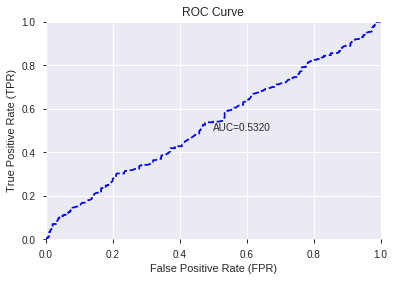

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


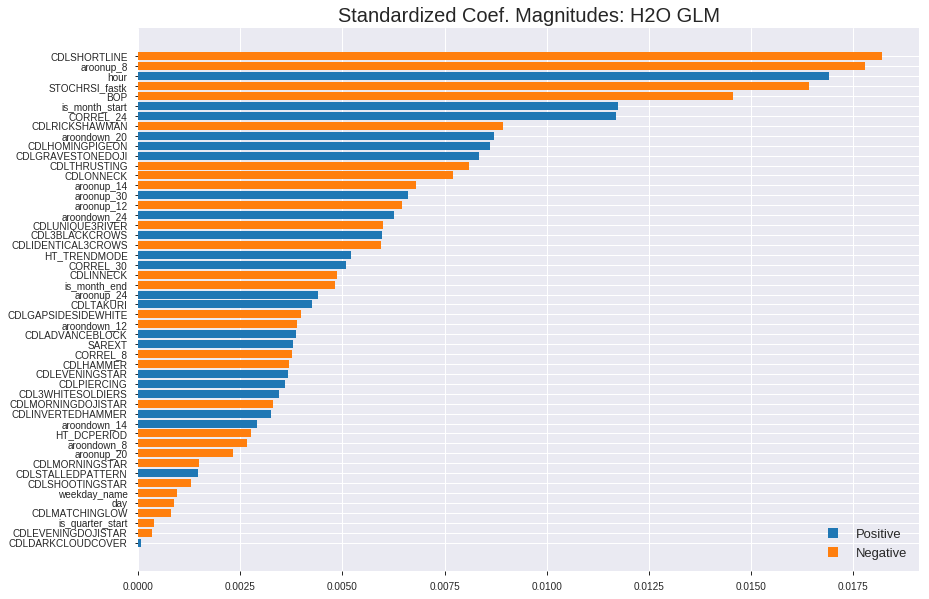

'log_likelihood'
--2019-07-25 05:48:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_054815_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_054815_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLSHORTLINE',
 'aroonup_8',
 'hour',
 'STOCHRSI_fastk',
 'BOP',
 'is_month_start',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'aroondown_20',
 'CDLHOMINGPIGEON',
 'CDLGRAVESTONEDOJI',
 'CDLTHRUSTING',
 'CDLONNECK',
 'aroonup_14',
 'aroonup_30',
 'aroonup_12',
 'aroondown_24',
 'CDLUNIQUE3RIVER',
 'CDL3BLACKCROWS',
 'CDLIDENTICAL3CROWS',
 'HT_TRENDMODE',
 'CORREL_30',
 'CDLINNECK',
 'is_month_end',
 'aroonup_24',
 'CDLTAKURI',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_12',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'CORREL_8',
 'CDLHAMMER',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'aroondown_14',
 'HT_DCPERIOD',
 'aroondown_8',
 'aroonup_20',
 'CDLMORNINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'day',
 'CDLMATCHINGLOW',
 'is_quarter_start',
 'CDLEVENINGDOJISTAR',
 'CDLDARKCLOUDCOVER']

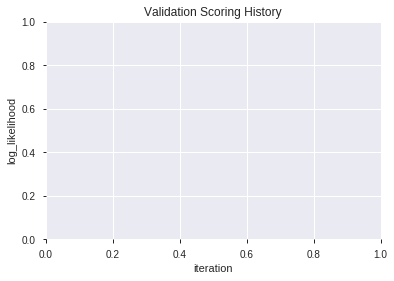

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_054923_model_6  0.544801  0.689404              0.484646  0.498151  0.248154
1  XGBoost_grid_1_AutoML_20190725_054923_model_4  0.542207  0.689347              0.492518  0.498121  0.248124
2  XGBoost_grid_1_AutoML_20190725_054923_model_5  0.536956  0.715555              0.500000  0.509792  0.259888
3  XGBoost_grid_1_AutoML_20190725_054923_model_1  0.536502  0.689587              0.488485  0.498329  0.248331
4               XGBoost_3_AutoML_20190725_054923  0.536038  0.689655              0.485036  0.498320  0.248323
5  XGBoost_grid_1_AutoML_20190725_054923_model_7  0.534372  0.699006              0.496552  0.502717  0.252724
6  XGBoost_grid_1_AutoML_20190725_054923_model_2  0.530855  0.692693              0.498276  0.499792  0.249792
7               XGBoost_1_AutoML_20190725_054923  0.529089  0.699261              0.492713  0.502893  0.252901
8  XGBoost_grid_1_AutoML_20190725_054923_model_3  0.527555  0.691504              0.484093  0.499249  0.249250
9               XGBoost_2_AutoML_20190725_054923  0.525440  0.697577              0.496552  0.502146  0.252151

variable  relative_importance  scaled_importance  percentage
0              SAREXT           690.996704           1.000000    0.095317
1         HT_DCPERIOD           687.895020           0.995511    0.094889
2                 BOP           618.141357           0.894565    0.085267
3      STOCHRSI_fastk           541.646240           0.783862    0.074715
4           CORREL_24           484.266144           0.700823    0.066800
5                 day           480.924255           0.695986    0.066339
6                hour           464.057190           0.671577    0.064013
7           CORREL_30           438.234039           0.634206    0.060450
8          aroonup_30           328.754822           0.475769    0.045349
9        weekday_name           286.943207           0.415260    0.039581
10       aroondown_12           251.035278           0.363294    0.034628
11          aroonup_8           247.390579           0.358020    0.034125
12       aroondown_20           219.782028           0.318065    0.030317
13         aroonup_24           208.212830           0.301322    0.028721
14        aroondown_8           187.133301           0.270816    0.025813
15       aroondown_14           169.030777           0.244619    0.023316
16         aroonup_20           168.006180           0.243136    0.023175
17       aroondown_24           162.024811           0.234480    0.022350
18         aroonup_12           143.321426           0.207413    0.019770
19         aroonup_14           126.932686           0.183695    0.017509
20       CDLSHORTLINE           120.721725           0.174707    0.016652
21     CDLRICKSHAWMAN            67.121101           0.097137    0.009259
22       HT_TRENDMODE            30.648598           0.044354    0.004228
23       is_month_end            23.225765           0.033612    0.003204
24  CDLGRAVESTONEDOJI            20.745186           0.030022    0.002862
25          CDLHAMMER            19.876402           0.028765    0.002742
26    CDLADVANCEBLOCK            17.872684           0.025865    0.002465
27          CDLTAKURI            15.636644           0.022629    0.002157
28     CDLMATCHINGLOW            12.879604           0.018639    0.001777
29  CDLINVERTEDHAMMER             9.866352           0.014278    0.001361
30     is_month_start             6.149518           0.008899    0.000848

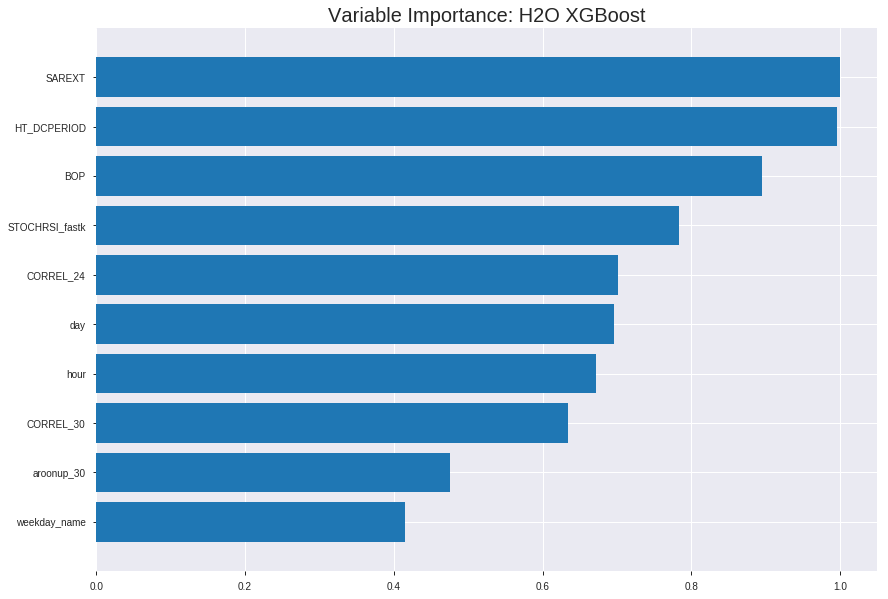

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_054923_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22038612006338995
RMSE: 0.46945300090998454
LogLoss: 0.6330087072366658
Mean Per-Class Error: 0.2732160165028391
AUC: 0.8006106007582385
pr_auc: 0.7987933882323012
Gini: 0.6012212015164771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.468605101108551: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1141  1019  0.4718   (1019.0/2160.0)
1      274   1885  0.1269   (274.0/2159.0)
Total  1415  2904  0.2994   (1293.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468605     0.744618  259
max f2                       0.428562     0.848843  316
max f0point5                 0.503285     0.73144   204
max accuracy                 0.499993     0.726789  210
max precision                0.784803     1         0
max recall                   0.344256     1         389
max specificity              0.784803     1         0
max absolute_mcc             0.499993     0.453932  210
max min_per_class_accuracy   0.496732     0.725463  216
max mean_per_class_accuracy  0.499993     0.726784  210

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.683168           2.00046   2.00046            1                0.707677  1                           0.707677            0.0203798       0.0203798                  100.046   100.046
    2        0.0201436                   0.656297           1.8609    1.93148            0.930233         0.668906  0.965517                    0.688514            0.0185271       0.0389069                  86.0896   93.1482
    3        0.0300996                   0.641661           1.81437   1.89275            0.906977         0.648708  0.946154                    0.675347            0.0180639       0.0569708                  81.4374   89.2746
    4        0.0400556                   0.627769           1.90742   1.89639            0.953488         0.634052  0.947977                    0.665083            0.0189903       0.0759611                  90.7418   89.6393
    5        0.0500116                   0.618827           1.90742   1.89859            0.953488         0.623012  0.949074                    0.656708            0.0189903       0.0949514                  90.7418   89.8588
    6        0.100023                    0.586931           1.89859   1.89859            0.949074         0.6016    0.949074                    0.629154            0.0949514       0.189903                   89.8588   89.8588
    7        0.150035                    0.566897           1.51887   1.77202            0.759259         0.575662  0.885802                    0.611323            0.0759611       0.265864                   51.887    77.2015
    8        0.200046                    0.550984           1.56518   1.72031            0.782407         0.558594  0.859954                    0.598141            0.078277        0.344141                   56.5177   72.0306
    9        0.300069                    0.530043           1.41236   1.61766            0.706019         0.539979  0.808642                    0.578754            0.141269        0.48541                    41.2364   61.7658
    10       0.400093                    0.511349           1.28734   1.53508            0.643519         0.520654  0.767361                    0.564229            0.128763        0.614173                   28.7335   53.5078
    11       0.500116                    0.496541           1.116     1.45126            0.55787          0.503984  0.725463                    0.55218             0.111626        0.725799                   11.5999   45.1262
    12       0.599907                    0.480601           0.872592  1.355              0.436195         0.488372  0.677345                    0.541566            0.0870774       0.812876                   -12.7408  35.5003
    13       0.699931                    0.463842           0.796481  1.27519            0.398148         0.472308  0.637446                    0.531668            0.0796665       0.892543                   -20.3519  27.5188
    14       0.799954                    0.444469           0.564946  1.18638            0.282407         0.455329  0.593054                    0.522123            0.0565076       0.94905                    -43.5054  18.6382
    15       0.899977                    0.416273           0.333411  1.09158            0.166667         0.431529  0.545665                    0.512055            0.0333488       0.982399                   -66.6589  9.15828
    16       1                           0.306308           0.175967  1                  0.087963         0.389427  0.499884                    0.499789         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2517136386749984
RMSE: 0.501710712138976
LogLoss: 0.6966945866443003
Mean Per-Class Error: 0.4785899102932871
AUC: 0.5176418823962069
pr_auc: 0.5129451512829307
Gini: 0.035283764792413796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3357991576194763: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    617   0.9968   (617.0/619.0)
1      0    615   0        (0.0/615.0)
Total  2    1232  0.5      (617.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.335799     0.665945   397
max f2                       0.335799     0.832882   397
max f0point5                 0.419083     0.558414   354
max accuracy                 0.499239     0.52107    224
max precision                0.72347      1          0
max recall                   0.335799     1          397
max specificity              0.72347      1          0
max absolute_mcc             0.447095     0.0607965  318
max min_per_class_accuracy   0.507588     0.505654   211
max mean_per_class_accuracy  0.447095     0.52141    318

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 51.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.676402           1.08043   1.08043            0.538462         0.693687  0.538462                    0.693687            0.0113821       0.0113821                  8.04253   8.04253
    2        0.0202593                   0.656809           1.00325   1.04338            0.5              0.66617   0.52                        0.680479            0.0097561       0.0211382                  0.325203  4.33821
    3        0.0299838                   0.640597           1.33767   1.13883            0.666667         0.649093  0.567568                    0.6703              0.0130081       0.0341463                  33.7669   13.8827
    4        0.0405186                   0.631533           0.771732  1.04338            0.384615         0.635891  0.52                        0.661354            0.00813008      0.0422764                  -22.8268  4.33821
    5        0.0502431                   0.625086           1.8393    1.19743            0.916667         0.628938  0.596774                    0.65508             0.0178862       0.0601626                  83.9295   19.743
    6        0.100486                    0.59128            1.00325   1.10034            0.5              0.606617  0.548387                    0.630848            0.0504065       0.110569                   0.325203  10.0341
    7        0.149919                    0.574857           1.0197    1.07375            0.508197         0.582484  0.535135                    0.614901            0.0504065       0.160976                   1.96988   7.37508
    8        0.200162                    0.561251           0.938526  1.03981            0.467742         0.567472  0.518219                    0.602996            0.0471545       0.20813                    -6.14739  3.98078
    9        0.299838                    0.539878           0.946156  1.00868            0.471545         0.550774  0.502703                    0.585636            0.0943089       0.302439                   -5.38436  0.867502
    10       0.400324                    0.523031           0.954708  0.995129           0.475806         0.531847  0.495951                    0.572134            0.095935        0.398374                   -4.52924  -0.487147
    11       0.5                         0.507426           1.07666   1.01138            0.536585         0.514694  0.504052                    0.560683            0.107317        0.505691                   7.66607   1.13821
    12       0.599676                    0.492279           1.02772   1.0141             0.512195         0.498823  0.505405                    0.550401            0.102439        0.60813                    2.77216   1.4098
    13       0.700162                    0.477603           1.08416   1.02415            0.540323         0.485143  0.510417                    0.541035            0.108943        0.717073                   8.41595   2.41531
    14       0.799838                    0.460098           0.978782  1.0185             0.487805         0.469365  0.507599                    0.532104            0.097561        0.814634                   -2.12175  1.8499
    15       0.899514                    0.436686           0.978782  1.0141             0.487805         0.448872  0.505405                    0.522881            0.097561        0.912195                   -2.12175  1.4098
    16       1                           0.3074             0.8738    1                  0.435484         0.403121  0.498379                    0.510847          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:49:42  12.378 sec  0                  0.5              0.693147            0.5             0                  1                0.500116                         0.5                0.693147              0.5               0                    1                  0.501621
    2019-07-25 05:49:42  12.482 sec  5                  0.495996         0.685161            0.654609        0.662315           1.86407          0.425561                         0.500199           0.693546              0.497227          0.493246             0.926079           0.493517
    2019-07-25 05:49:42  12.549 sec  10                 0.492197         0.677617            0.692315        0.692659           1.90953          0.405649                         0.500087           0.69332               0.508507          0.510474             1.23477            0.498379
    2019-07-25 05:49:42  12.639 sec  15                 0.488658         0.67061             0.709533        0.712887           2.00046          0.38759                          0.499413           0.691961              0.522453          0.524154             1.38912            0.498379
    2019-07-25 05:49:42  12.713 sec  20                 0.485669         0.664697            0.724394        0.726073           1.955            0.365825                         0.499914           0.69297               0.518134          0.521282             1.54346            0.498379
    2019-07-25 05:49:43  12.789 sec  25                 0.483254         0.659938            0.737351        0.73743            2.00046          0.37254                          0.499809           0.692765              0.522223          0.52161              1.23477            0.5
    2019-07-25 05:49:43  12.873 sec  30                 0.480063         0.65368             0.756184        0.756852           2.00046          0.350081                         0.500134           0.693448              0.524096          0.519445             1.23477            0.5
    2019-07-25 05:49:43  12.966 sec  35                 0.477147         0.647972            0.767739        0.767867           2.00046          0.332021                         0.500193           0.693576              0.526127          0.520471             1.23477            0.5
    2019-07-25 05:49:43  13.052 sec  40                 0.47451          0.642824            0.778311        0.77767            2.00046          0.302385                         0.501109           0.695447              0.519394          0.514322             0.926079           0.50081
    2019-07-25 05:49:43  13.155 sec  45                 0.471936         0.637829            0.791228        0.789986           2.00046          0.302153                         0.501314           0.695869              0.5192            0.515088             1.08043            0.50081
    2019-07-25 05:49:43  13.263 sec  50                 0.469453         0.633009            0.800611        0.798793           2.00046          0.299375                         0.501711           0.696695              0.517642          0.512945             1.08043            0.5

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
SAREXT             690.9967041015625      1.0                   0.09531682593298527
HT_DCPERIOD        687.89501953125        0.9955112889078894    0.0948889762391551
BOP                618.141357421875       0.8945648419923878    0.08526708132995689
STOCHRSI_fastk     541.646240234375       0.7838622630459956    0.07471526288219107
CORREL_24          484.2661437988281      0.7008226536021955    0.0668001908832933
---                ---                    ---                   ---
CDLADVANCEBLOCK    17.872684478759766     0.025865079200338478  0.0024653772518815403
CDLTAKURI          15.63664436340332      0.02262911569706279   0.0021569354819143184
CDLMATCHINGLOW     12.87960433959961      0.018639168990459566  0.0017766264261991312
CDLINVERTEDHAMMER  9.866352081298828      0.014278435805460331  0.0013609751802643667
is_month_start     6.149518013000488      0.008899489645172945  0.0008482711054013543


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5510534846029174)

('F1', 0.6934782608695653)

('auc', 0.5448012232415902)

('logloss', 0.6894040886122242)

('mean_per_class_error', 0.4615997047347886)

('rmse', 0.498150839953328)

('mse', 0.24815425934620622)

xgboost prediction progress: |████████████████████████████████████████████| 100%


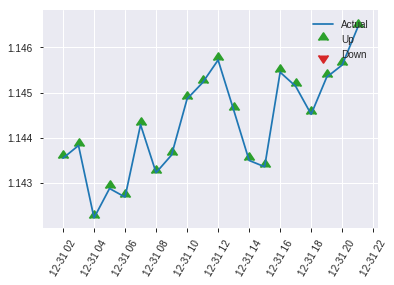


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24815425934620622
RMSE: 0.498150839953328
LogLoss: 0.6894040886122242
Mean Per-Class Error: 0.4615997047347886
AUC: 0.5448012232415902
pr_auc: 0.5803371225077543
Gini: 0.08960244648318039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40118515491485596: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   274  0.9448   (274.0/290.0)
1      8    319  0.0245   (8.0/327.0)
Total  24   593  0.4571   (282.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401185     0.693478  379
max f2                       0.338182     0.849351  399
max f0point5                 0.432561     0.593186  340
max accuracy                 0.43538      0.551053  335
max precision                0.72622      1         0
max recall                   0.338182     1         399
max specificity              0.72622      1         0
max absolute_mcc             0.595913     0.112694  32
max min_per_class_accuracy   0.492433     0.517241  211
max mean_per_class_accuracy  0.510858     0.5384    167

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.650499           1.34775   1.34775            0.714286         0.675897  0.714286                    0.675897            0.0152905       0.0152905                  34.775    34.775
    2        0.0210697                   0.622731           1.2579    1.30628            0.666667         0.629955  0.692308                    0.654693            0.0122324       0.0275229                  25.79     30.6281
    3        0.0307942                   0.614677           1.57238   1.39031            0.833333         0.618881  0.736842                    0.643384            0.0152905       0.0428135                  57.2375   39.0311
    4        0.0405186                   0.607215           1.2579    1.35853            0.666667         0.610459  0.72                        0.635482            0.0122324       0.0550459                  25.79     35.8532
    5        0.0502431                   0.60352            1.2579    1.33905            0.666667         0.605752  0.709677                    0.629728            0.0122324       0.0672783                  25.79     33.9055
    6        0.100486                    0.578373           1.27819   1.30862            0.677419         0.59107   0.693548                    0.610399            0.0642202       0.131498                   27.8189   30.8622
    7        0.150729                    0.561853           0.79126   1.13617            0.419355         0.570855  0.602151                    0.597218            0.0397554       0.171254                   -20.874   13.6168
    8        0.200972                    0.545728           1.09559   1.12602            0.580645         0.553546  0.596774                    0.5863              0.0550459       0.2263                     9.55904   12.6023
    9        0.299838                    0.52542            1.05169   1.10151            0.557377         0.536249  0.583784                    0.569796            0.103976        0.330275                   5.1687    10.1513
    10       0.400324                    0.509421           1.00429   1.07711            0.532258         0.517631  0.57085                     0.556702            0.100917        0.431193                   0.429121  7.71088
    11       0.50081                     0.492724           0.852126  1.03197            0.451613         0.500407  0.546926                    0.545407            0.0856269       0.51682                    -14.7874  3.19666
    12       0.599676                    0.47886            1.02076   1.03012            0.540984         0.4855    0.545946                    0.53553             0.100917        0.617737                   2.0755    3.01182
    13       0.700162                    0.46533            1.03472   1.03078            0.548387         0.471616  0.546296                    0.526357            0.103976        0.721713                   3.47243   3.07793
    14       0.799028                    0.450617           0.927959  1.01806            0.491803         0.457919  0.539554                    0.517889            0.0917431       0.813456                   -7.20409  1.80571
    15       0.899514                    0.42708            1.03472   1.01992            0.548387         0.439113  0.540541                    0.509089            0.103976        0.917431                   3.47243   1.9919
    16       1                           0.338182           0.821693  1                  0.435484         0.404556  0.529984                    0.498585           

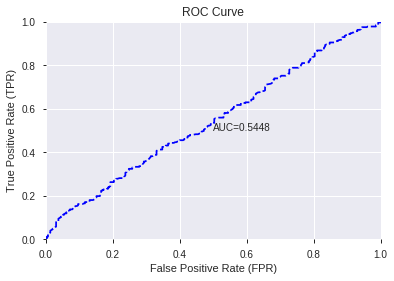

This function is available for GLM models only


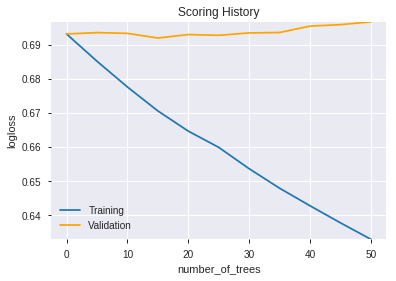

--2019-07-25 05:49:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_054923_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_054923_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SAREXT',
 'HT_DCPERIOD',
 'BOP',
 'STOCHRSI_fastk',
 'CORREL_24',
 'day',
 'hour',
 'CORREL_30',
 'aroonup_30',
 'weekday_name',
 'aroondown_12',
 'aroonup_8',
 'aroondown_20',
 'aroonup_24',
 'aroondown_8',
 'aroondown_14',
 'aroonup_20',
 'aroondown_24',
 'aroonup_12',
 'aroonup_14',
 'CDLSHORTLINE',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'is_month_end',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'is_month_start']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 935] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_055056_model_1  0.551977  0.722163              0.491184  0.513978  0.264173
1  DeepLearning_grid_1_AutoML_20190725_055056_model_4  0.548397  0.692766              0.491184  0.499860  0.249860
2  DeepLearning_grid_1_AutoML_20190725_055056_model_3  0.546446  0.717453              0.496552  0.511315  0.261443
3  DeepLearning_grid_1_AutoML_20190725_055056_model_2  0.528809  0.700611              0.498276  0.503340  0.253351
4  DeepLearning_grid_1_AutoML_20190725_055056_model_8  0.501529  0.691532              0.500000  0.499195  0.249196
5  DeepLearning_grid_1_AutoML_20190725_055056_model_7  0.500000  0.691836              0.500000  0.499344  0.249344
6  DeepLearning_grid_1_AutoML_20190725_055056_model_5  0.500000  0.691454              0.500000  0.499153  0.249154
7  DeepLearning_grid_1_AutoML_20190725_055056_model_6  0.500000  0.692299              0.500000  0.499576  0.249576
8               DeepLearning_1_AutoML_20190725_055056  0.496067  0.693944              0.500000  0.500397  0.250397

variable  relative_importance  scaled_importance  percentage
0                 is_month_end             1.000000           1.000000    0.005246
1               is_month_start             0.983793           0.983793    0.005161
2            CDLGRAVESTONEDOJI             0.863139           0.863139    0.004528
3                     CORREL_8             0.837325           0.837325    0.004393
4              CDLADVANCEBLOCK             0.808719           0.808719    0.004243
...                        ...                  ...                ...         ...
1032                    SUM_20             0.146520           0.146520    0.000769
1033  BBANDS_middleband_12_4_5             0.144018           0.144018    0.000756
1034               MIDPOINT_24             0.143071           0.143071    0.000751
1035   BBANDS_upperband_14_1_2             0.142608           0.142608    0.000748
1036  BBANDS_middleband_24_2_4             0.141971           0.141971    0.000745

[1037 rows x 4 columns]

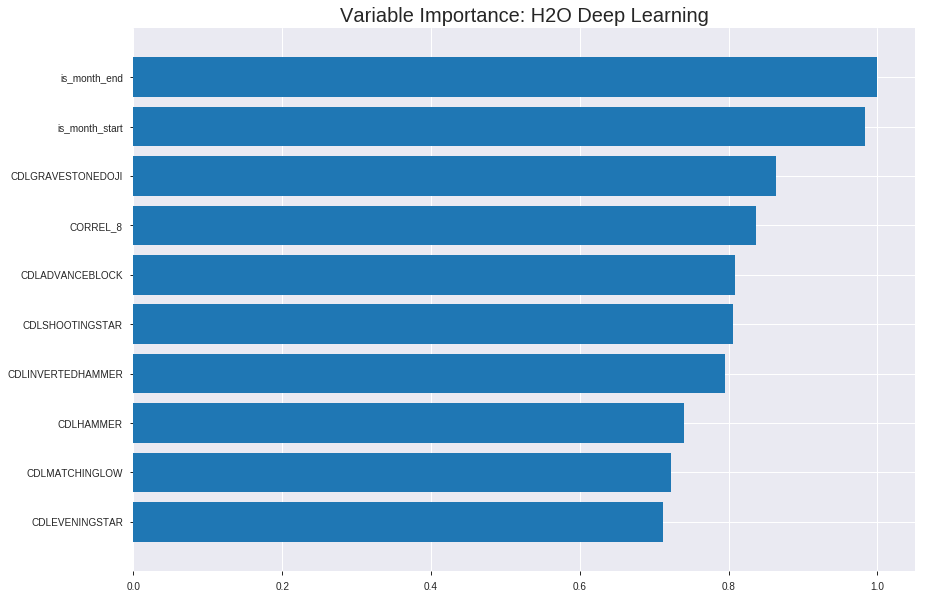

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_055056_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24743030369290694
RMSE: 0.4974236661970427
LogLoss: 0.6880386479982233
Mean Per-Class Error: 0.44777556910778304
AUC: 0.5663894035304411
pr_auc: 0.5572176954259546
Gini: 0.1327788070608822
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3740123669718267: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      42   2118  0.9806   (2118.0/2160.0)
1      20   2139  0.0093   (20.0/2159.0)
Total  62   4257  0.495    (2138.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374012     0.666771  379
max f2                       0.33693      0.833398  397
max f0point5                 0.448575     0.561523  268
max accuracy                 0.465926     0.552211  236
max precision                0.807915     1         0
max recall                   0.33693      1         397
max specificity              0.807915     1         0
max absolute_mcc             0.461426     0.105142  244
max min_per_class_accuracy   0.468834     0.547013  231
max mean_per_class_accuracy  0.461426     0.552224  244

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 47.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.646079           1.31849   1.31849            0.659091         0.712504  0.659091                    0.712504            0.0134321       0.0134321                  31.8487   31.8487
    2        0.0201436                   0.619477           1.20958   1.26466            0.604651         0.629994  0.632184                    0.671723            0.0120426       0.0254748                  20.9582   26.4661
    3        0.0300996                   0.599317           1.34915   1.29261            0.674419         0.609212  0.646154                    0.651046            0.0134321       0.0389069                  34.915    29.2607
    4        0.0400556                   0.59211            0.97697   1.21415            0.488372         0.595734  0.606936                    0.637298            0.00972673      0.0486336                  -2.30296  21.4154
    5        0.0500116                   0.582751           1.20958   1.21324            0.604651         0.587417  0.606481                    0.627368            0.0120426       0.0606762                  20.9582   21.3244
    6        0.100023                    0.552391           1.12063   1.16694            0.560185         0.565445  0.583333                    0.596407            0.0560445       0.116721                   12.063    16.6937
    7        0.150035                    0.534813           1.26881   1.2009             0.634259         0.543613  0.600309                    0.578809            0.0634553       0.180176                   26.8812   20.0895
    8        0.200046                    0.520358           1.1762    1.19472            0.587963         0.527533  0.597222                    0.56599             0.0588235       0.239                      17.6198   19.4721
    9        0.300069                    0.498845           1.08821   1.15922            0.543981         0.509562  0.579475                    0.547181            0.108847        0.347846                   8.82149   15.9219
    10       0.400093                    0.483036           0.986339  1.116              0.493056         0.490878  0.55787                     0.533105            0.0986568       0.446503                   -1.36605  11.5999
    11       0.500116                    0.46836            1.01412   1.09562            0.506944         0.475579  0.547685                    0.5216              0.101436        0.547939                   1.41237   9.5624
    12       0.599907                    0.455581           0.988628  1.07783            0.4942           0.461929  0.538788                    0.511674            0.0986568       0.646596                   -1.1372   7.78258
    13       0.699931                    0.443002           0.916879  1.05483            0.458333         0.449249  0.527291                    0.502753            0.0917091       0.738305                   -8.3121   5.48258
    14       0.799954                    0.428551           0.893725  1.03468            0.446759         0.436199  0.517221                    0.494431            0.0893932       0.827698                   -10.6275  3.46824
    15       0.899977                    0.410714           0.879833  1.01747            0.439815         0.420643  0.508618                    0.486231            0.0880037       0.915702                   -12.0167  1.74725
    16       1                           0.322881           0.842788  1                  0.421296         0.391182  0.499884                    0.476724          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2576299458454066
RMSE: 0.507572601551154
LogLoss: 0.7088242928087802
Mean Per-Class Error: 0.47799361676977026
AUC: 0.5046797220799348
pr_auc: 0.5017385469115517
Gini: 0.009359444159869668
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2940560804364868: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    615   0        (0.0/615.0)
Total  0    1234  0.5016   (619.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.294056     0.665224   399
max f2                       0.294056     0.832431   399
max f0point5                 0.337018     0.555454   386
max accuracy                 0.41575      0.52188    228
max precision                0.80777      1          0
max recall                   0.294056     1          399
max specificity              0.80777      1          0
max absolute_mcc             0.751913     0.0495267  2
max min_per_class_accuracy   0.419535     0.504065   220
max mean_per_class_accuracy  0.415487     0.522006   229

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 42.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.578547           1.08043   1.08043            0.538462         0.647859  0.538462                    0.647859            0.0113821       0.0113821                  8.04253   8.04253
    2        0.0202593                   0.555484           0.836043  0.963122           0.416667         0.563322  0.48                        0.607281            0.00813008      0.0195122                  -16.3957  -3.6878
    3        0.0299838                   0.5409             1.33767   1.0846             0.666667         0.5499    0.540541                    0.588671            0.0130081       0.0325203                  33.7669   8.45968
    4        0.0405186                   0.524257           1.23477   1.12364            0.615385         0.531437  0.56                        0.57379             0.0130081       0.0455285                  23.4772   12.3642
    5        0.0502431                   0.513744           0.501626  1.00325            0.25             0.518455  0.5                         0.56308             0.00487805      0.0504065                  -49.8374  0.325203
    6        0.100486                    0.487298           1.00325   1.00325            0.5              0.501046  0.5                         0.532063            0.0504065       0.100813                   0.325203  0.325203
    7        0.149919                    0.471734           1.05259   1.01952            0.52459          0.478849  0.508108                    0.514517            0.0520325       0.152846                   5.25923   1.9521
    8        0.200162                    0.461543           0.970889  1.00731            0.483871         0.466296  0.502024                    0.502413            0.0487805       0.201626                   -2.91109  0.731378
    9        0.299838                    0.443519           1.02772   1.0141             0.512195         0.45221   0.505405                    0.485724            0.102439        0.304065                   2.77216   1.4098
    10       0.400324                    0.42992            0.954708  0.99919            0.475806         0.436531  0.497976                    0.473376            0.095935        0.4                        -4.52924  -0.0809717
    11       0.5                         0.418968           1.07666   1.01463            0.536585         0.424827  0.505673                    0.463697            0.107317        0.507317                   7.66607   1.46341
    12       0.599676                    0.408724           1.01141   1.0141             0.504065         0.414203  0.505405                    0.455471            0.100813        0.60813                    1.14086   1.4098
    13       0.700162                    0.396657           1.03562   1.01719            0.516129         0.40289   0.506944                    0.447924            0.104065        0.712195                   3.5615    1.71861
    14       0.799838                    0.384264           0.783026  0.988005           0.390244         0.390071  0.492401                    0.440715            0.0780488       0.790244                   -21.6974  -1.1995
    15       0.899514                    0.365135           1.02772   0.992406           0.512195         0.375676  0.494595                    0.433508            0.102439        0.892683                   2.77216   -0.759394
    16       1                           0.294056           1.06798   1                  0.532258         0.350361  0.498379                    0.425153    


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:51:00  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:51:08  11.034 sec         228 obs/sec       0.403566  1             1743       0.674803         3.88327             -0.821435      0.524222        0.344973           1.22756          0.500116                         0.685798           2.71822               -0.881296        0.496051          0.494703             1.23477            0.501621
    2019-07-25 05:51:44  47.511 sec         256 obs/sec       2.42093   6             10456      0.642819         2.27326             -0.652867      0.549967        0.454833           1.50035          0.500116                         0.677222           2.229                 -0.834539        0.48563           0.486011             1.08043            0.497569
    2019-07-25 05:52:21  1 min 23.806 sec   259 obs/sec       4.44385   11            19193      0.663284         4.72925             -0.759781      0.522571        0.503681           1.27302          0.500116                         0.68353            2.91196               -0.868872        0.506951          0.485327             1.23477            0.495138
    2019-07-25 05:52:57  2 min  0.193 sec   260 obs/sec       6.44987   16            27857      0.66466          2.45182             -0.767094      0.5672          0.572006           1.54581          0.500116                         0.694517           2.81325               -0.929436        0.486556          0.489642             1.38912            0.501621
    2019-07-25 05:53:33  2 min 35.957 sec   262 obs/sec       8.49155   21            36675      0.62893          1.68294             -0.58221       0.559913        0.524977           1.22756          0.500116                         0.681315           2.37222               -0.856779        0.475607          0.48416              1.38912            0.501621
    2019-07-25 05:54:08  3 min 10.715 sec   265 obs/sec       10.5175   26            45425      0.601834         1.39117             -0.448814      0.557173        0.54776            1.18209          0.500116                         0.645755           1.53503               -0.668017        0.497825          0.510666             1.38912            0.492707
    2019-07-25 05:54:41  3 min 44.190 sec   269 obs/sec       12.5561   31            54230      0.609755         1.50698             -0.487206      0.54207         0.53983            1.27302          0.494327                         0.615924           1.19278               -0.517463        0.506488          0.519107             1.38912            0.49919
    2019-07-25 05:55:18  4 min 21.411 sec   274 obs/sec       14.9808   37            64702      0.569012         0.982569            -0.2951        0.558455        0.554157           1.09116          0.495717                         0.610798           1.16323               -0.492312        0.514604          0.51652              1.54346            0.49919
    2019-07-25

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
is_month_end              1.0                    1.0                  0.005246420496867366
is_month_start            0.983793318271637      0.983793318271637    0.005161393429661476
CDLGRAVESTONEDOJI         0.8631386756896973     0.8631386756896973   0.0045283884397773816
CORREL_8                  0.837324857711792      0.837324857711792    0.004392958296035696
CDLADVANCEBLOCK           0.808719277381897      0.808719277381897    0.004242881393068149
---                       ---                    ---                  ---
SUM_20                    0.14652039110660553    0.14652039110660553  0.0007687075831107181
BBANDS_middleband_12_4_5  0.14401774108409882    0.14401774108409882  0.0007555776287361533
MIDPOINT_24               0.14307115972042084    0.14307115972042084  0.0007506114648678005
BBANDS_upperband_14_1_2   0.14260825514793396    0.14260825514793396  0.0007481828728306117
BBANDS_middleband_24_2_4  0.14197121560573578    0.14197121560573578  0.0007448406955191082


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5478119935170178)

('F1', 0.695837780149413)

('auc', 0.5519772223979754)

('logloss', 0.722163217748186)

('mean_per_class_error', 0.4525941157861436)

('rmse', 0.5139776982190613)

('mse', 0.2641730742665644)

deeplearning prediction progress: |███████████████████████████████████████| 100%


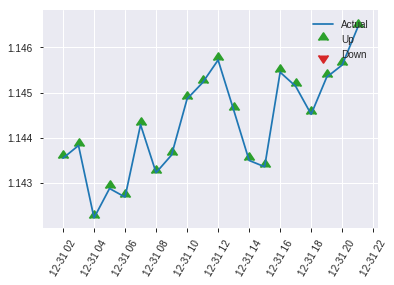


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2641730742665644
RMSE: 0.5139776982190613
LogLoss: 0.722163217748186
Mean Per-Class Error: 0.4525941157861436
AUC: 0.5519772223979754
pr_auc: 0.5814951681783073
Gini: 0.10395444479595084
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32520445146662885: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    284  0.9793   (284.0/290.0)
1      1    326  0.0031   (1.0/327.0)
Total  7    610  0.4619   (285.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325204     0.695838  392
max f2                       0.325204     0.849844  392
max f0point5                 0.342893     0.592523  371
max accuracy                 0.389143     0.547812  214
max precision                0.82349      1         0
max recall                   0.311291     1         398
max specificity              0.82349      1         0
max absolute_mcc             0.42136      0.115713  103
max min_per_class_accuracy   0.39123      0.538226  203
max mean_per_class_accuracy  0.42136      0.547406  103

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 39.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.519107           1.34775   1.34775            0.714286         0.593492  0.714286                    0.593492            0.0152905       0.0152905                  34.775    34.775
    2        0.0210697                   0.497066           1.2579    1.30628            0.666667         0.508059  0.692308                    0.554061            0.0122324       0.0275229                  25.79     30.6281
    3        0.0307942                   0.481977           1.57238   1.39031            0.833333         0.488149  0.736842                    0.533247            0.0152905       0.0428135                  57.2375   39.0311
    4        0.0405186                   0.472386           0.943425  1.28306            0.5              0.47769   0.68                        0.519913            0.00917431      0.0519878                  -5.65749  28.3058
    5        0.0502431                   0.464031           0.943425  1.21732            0.5              0.468004  0.645161                    0.509866            0.00917431      0.0611621                  -5.65749  21.7323
    6        0.100486                    0.442811           1.09559   1.15646            0.580645         0.453402  0.612903                    0.481634            0.0550459       0.116208                   9.55904   15.6457
    7        0.150729                    0.430258           1.21732   1.17675            0.645161         0.43596   0.623656                    0.466409            0.0611621       0.17737                    21.7323   17.6745
    8        0.200972                    0.423244           1.27819   1.20211            0.677419         0.427184  0.637097                    0.456603            0.0642202       0.24159                    27.8189   20.2106
    9        0.299838                    0.411372           0.927959  1.11171            0.491803         0.416488  0.589189                    0.443376            0.0917431       0.333333                   -7.20409  11.1712
    10       0.400324                    0.400756           0.973858  1.07711            0.516129         0.405287  0.57085                     0.433815            0.0978593       0.431193                   -2.61419  7.71088
    11       0.50081                     0.39123            1.06516   1.07471            0.564516         0.395624  0.569579                    0.426152            0.107034        0.538226                   6.51573   7.47108
    12       0.599676                    0.38249            0.927959  1.05052            0.491803         0.386997  0.556757                    0.419697            0.0917431       0.629969                   -7.20409  5.05166
    13       0.700162                    0.375106           0.943425  1.03515            0.5              0.378937  0.548611                    0.413847            0.0948012       0.724771                   -5.65749  3.5147
    14       0.799028                    0.365597           0.927959  1.02188            0.491803         0.370009  0.541582                    0.408423            0.0917431       0.816514                   -7.20409  2.18844
    15       0.899514                    0.353051           0.912992  1.00972            0.483871         0.360182  0.535135                    0.403034            0.0917431       0.908257                   -8.7008   0.971981
    16       1                           0.308764           0.912992  1                  0.483871         0.34062   0.529984                    0.396762          

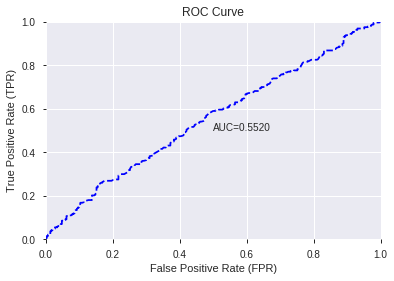

This function is available for GLM models only


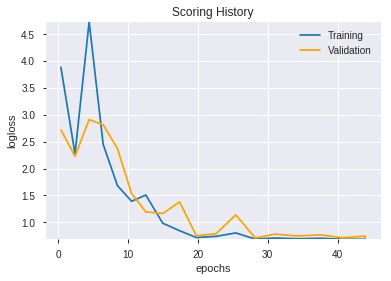

--2019-07-25 06:51:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_055056_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_055056_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['is_month_end',
 'is_month_start',
 'CDLGRAVESTONEDOJI',
 'CORREL_8',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLHAMMER',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'CDLHANGINGMAN',
 'CDLIDENTICAL3CROWS',
 'CDLMORNINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CORREL_12',
 'CDLEVENINGDOJISTAR',
 'is_quarter_start',
 'CDLTHRUSTING',
 'CDLTAKURI',
 'CORREL_30',
 'CDLDRAGONFLYDOJI',
 'CDLSEPARATINGLINES',
 'CORREL_14',
 'CDL3WHITESOLDIERS',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDLHOMINGPIGEON',
 'CDLRICKSHAWMAN',
 'VAR_8',
 'days_in_month',
 'CDLDARKCLOUDCOVER',
 'OBV',
 'DIV',
 'TRANGE',
 'VAR_30',
 'VAR_20',
 'SUB',
 'CDLINNECK',
 'VAR_24',
 'CDL3BLACKCROWS',
 'CDLUNIQUE3RIVER',
 'CDLXSIDEGAP3METHODS',
 'CORREL_20',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLHIKKAKEMOD',
 'HT_DCPERIOD',
 'CDLLONGLEGGEDDOJI',
 'aroonup_20',
 'SAREXT',
 'VAR_14',
 'hour',
 'AD',
 'day',
 'VAR_12',
 'MINUS_DM_8',
 'BETA_20',
 'PLUS_DM_12',
 'BETA_24',
 'aroondown_20

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_065206_model_1  0.538147  0.693859              0.498276  0.500355  0.250355

variable  relative_importance  scaled_importance  percentage
0                 CDLSHORTLINE             0.008387           1.000000    0.018202
1                         hour             0.006959           0.829762    0.015104
2                    aroonup_8             0.006765           0.806612    0.014682
3               STOCHRSI_fastk             0.006326           0.754206    0.013728
4                          BOP             0.006155           0.733873    0.013358
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_20_2_4             0.000000           0.000000    0.000000
1033  BBANDS_middleband_24_2_3             0.000000           0.000000    0.000000
1034  BBANDS_middleband_30_2_3             0.000000           0.000000    0.000000
1035                   MA_30_6             0.000000           0.000000    0.000000
1036  BBANDS_middleband_30_6_2             0.000000           0.000000    0.000000

[1037 rows x 4 columns]

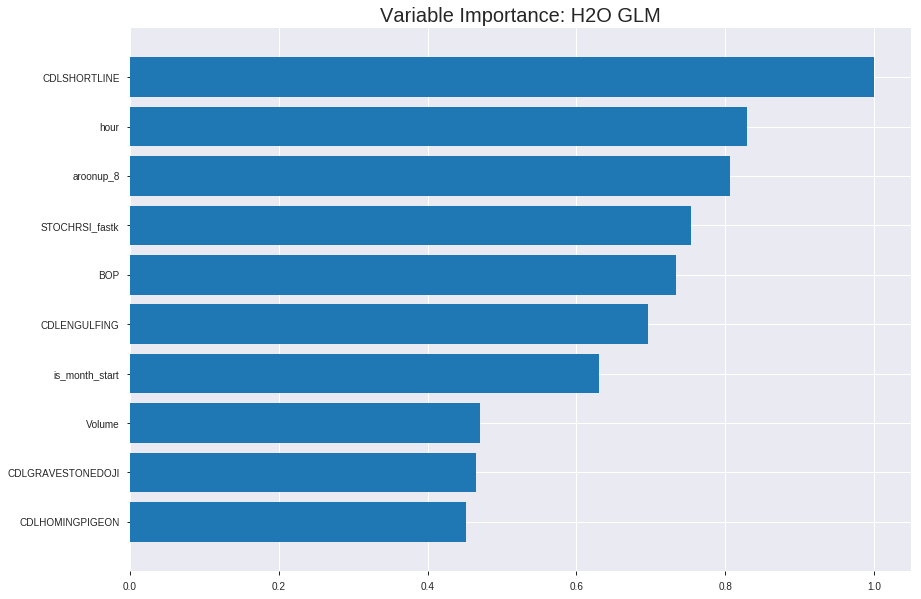

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_065206_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24838053029970303
RMSE: 0.4983778990883354
LogLoss: 0.6899035832845601
Null degrees of freedom: 4318
Residual degrees of freedom: 3301
Null deviance: 5987.405114141723
Residual deviance: 5959.38715241203
AIC: 7995.38715241203
AUC: 0.5579582883021975
pr_auc: 0.5541087875728282
Gini: 0.11591657660439503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4517631957100913: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      2    2158  0.9991   (2158.0/2160.0)
1      0    2159  0        (0.0/2159.0)
Total  2    4317  0.4997   (2158.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.451763     0.66677    397
max f2                       0.451763     0.833398   397
max f0point5                 0.476045     0.562138   337
max accuracy                 0.503225     0.544107   190
max precision                0.588561     1          0
max recall                   0.451763     1          397
max specificity              0.588561     1          0
max absolute_mcc             0.505109     0.0902552  181
max min_per_class_accuracy   0.499354     0.540741   212
max mean_per_class_accuracy  0.503225     0.54409    190

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 49.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.547107           1.40942   1.40942            0.704545         0.55659   0.704545                    0.55659             0.0143585       0.0143585                  40.9417    40.9417
    2        0.0201436                   0.540253           1.20958   1.31065            0.604651         0.543352  0.655172                    0.550047            0.0120426       0.0264011                  20.9582    31.0648
    3        0.0300996                   0.536223           1.53524   1.38494            0.767442         0.538011  0.692308                    0.546066            0.0152849       0.041686                   53.5239    38.4936
    4        0.0400556                   0.533014           1.07002   1.30666            0.534884         0.534547  0.653179                    0.543203            0.0106531       0.052339                   7.00152    30.6661
    5        0.0500116                   0.53049            0.930448  1.23177            0.465116         0.531745  0.615741                    0.540922            0.00926355      0.0616026                  -6.9552    23.1767
    6        0.100023                    0.52397            1.18546   1.20861            0.592593         0.526982  0.604167                    0.533952            0.0592867       0.120889                   18.546     20.8613
    7        0.150035                    0.519142           1.15768   1.19163            0.578704         0.52164   0.595679                    0.529848            0.0578972       0.178786                   15.7675    19.1634
    8        0.200046                    0.5154             1.07432   1.16231            0.537037         0.517155  0.581019                    0.526675            0.0537286       0.232515                   7.43228    16.2306
    9        0.300069                    0.50923            1.04191   1.12217            0.520833         0.512152  0.560957                    0.521834            0.104215        0.33673                    4.19079    12.2173
    10       0.400093                    0.504213           1.04654   1.10326            0.523148         0.506535  0.551505                    0.518009            0.104678        0.441408                   4.65386    10.3265
    11       0.500116                    0.499349           1.00023   1.08266            0.5              0.501861  0.541204                    0.514779            0.100046        0.541454                   0.0231589  8.26581
    12       0.599907                    0.49424            0.937572  1.05852            0.468677         0.496751  0.529139                    0.51178             0.0935618       0.635016                   -6.24279   5.85237
    13       0.699931                    0.489409           0.953925  1.04358            0.476852         0.491963  0.521667                    0.508949            0.0954145       0.730431                   -4.60754   4.35761
    14       0.799954                    0.4833             0.944663  1.03121            0.472222         0.486393  0.515485                    0.506128            0.0944882       0.824919                   -5.53368   3.12084
    15       0.899977                    0.476384           0.953925  1.02262            0.476852         0.480135  0.511191                    0.503239            0.0954145       0.920333                   -4.60754   2.26191
    16       1                           0.445808           0.796481  1                  0.398148         0.469696  0.499884                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24968408394719016
RMSE: 0.4996839840811292
LogLoss: 0.6925147896243664
Null degrees of freedom: 1233
Residual degrees of freedom: 216
Null deviance: 1710.685455494171
Residual deviance: 1709.1265007929364
AIC: 3745.1265007929364
AUC: 0.5200034148968307
pr_auc: 0.5219435527845058
Gini: 0.040006829793661325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4490390770909017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    615   0        (0.0/615.0)
Total  1    1233  0.5008   (618.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.449039     0.665584   398
max f2                       0.449039     0.832656   398
max f0point5                 0.449039     0.554354   398
max accuracy                 0.498727     0.528363   143
max precision                0.563075     1          0
max recall                   0.449039     1          398
max specificity              0.563075     1          0
max absolute_mcc             0.52376      0.0617155  24
max min_per_class_accuracy   0.489765     0.507317   208
max mean_per_class_accuracy  0.498727     0.527691   143

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.530044           1.23477   1.23477            0.615385         0.539917  0.615385                    0.539917            0.0130081       0.0130081                  23.4772   23.4772
    2        0.0202593                   0.525801           1.33767   1.28416            0.666667         0.527658  0.64                        0.534033            0.0130081       0.0260163                  33.7669   28.4163
    3        0.0299838                   0.523004           1.33767   1.30152            0.666667         0.524273  0.648649                    0.530867            0.0130081       0.0390244                  33.7669   30.1516
    4        0.0405186                   0.520843           1.08043   1.24403            0.538462         0.521744  0.62                        0.528495            0.0113821       0.0504065                  8.04253   24.4033
    5        0.0502431                   0.519194           1.17046   1.22979            0.583333         0.520014  0.612903                    0.526854            0.0113821       0.0617886                  17.0461   22.9793
    6        0.100486                    0.512631           0.906163  1.06798            0.451613         0.515331  0.532258                    0.521093            0.0455285       0.107317                   -9.38369  6.7978
    7        0.149919                    0.507448           0.986805  1.04121            0.491803         0.510068  0.518919                    0.517458            0.0487805       0.156098                   -1.31947  4.12129
    8        0.200162                    0.504093           1.16507   1.0723             0.580645         0.505914  0.534413                    0.51456             0.0585366       0.214634                   16.5067   7.23018
    9        0.299838                    0.498257           1.09297   1.07917            0.544715         0.500899  0.537838                    0.510018            0.108943        0.323577                   9.29738   7.91738
    10       0.400324                    0.493502           0.857619  1.02356            0.427419         0.495841  0.510121                    0.50646             0.0861789       0.409756                   -14.2381  2.35608
    11       0.5                         0.489689           0.978782  1.01463            0.487805         0.491529  0.505673                    0.503483            0.097561        0.507317                   -2.12175  1.46341
    12       0.599676                    0.485093           0.978782  1.00868            0.487805         0.487454  0.502703                    0.500819            0.097561        0.604878                   -2.12175  0.867502
    13       0.700162                    0.480348           1.06798   1.01719            0.532258         0.482967  0.506944                    0.498257            0.107317        0.712195                   6.7978    1.71861
    14       0.799838                    0.475507           1.01141   1.01647            0.504065         0.478004  0.506586                    0.495733            0.100813        0.813008                   1.14086   1.64661
    15       0.899514                    0.467978           0.929843  1.00687            0.463415         0.471997  0.501802                    0.493103            0.0926829       0.905691                   -7.01567  0.686736
    16       1                           0.448305           0.938526  1                  0.467742         0.461167  0.498379                    0.489894        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 06:52:14  0.000 sec   2            2.6       1018          1.37981           1.38503
    2019-07-25 06:52:19  4.817 sec   4            1.9       1023          1.37841           1.38521
    2019-07-25 06:52:24  9.662 sec   6            1.4       1026          1.37676           1.38542
    2019-07-25 06:52:29  14.679 sec  8            1         1028          1.37487           1.38582
    2019-07-25 06:52:34  19.515 sec  10           0.74      1029          1.37275           1.38645
    2019-07-25 06:52:39  24.351 sec  12           0.54      1032          1.37041           1.38747

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5429497568881686)

('F1', 0.6935312831389184)

('auc', 0.5381472107982705)

('logloss', 0.6938592542377848)

('mean_per_class_error', 0.45515659601391967)

('rmse', 0.5003549679022327)

('mse', 0.2503550939044443)

glm prediction progress: |████████████████████████████████████████████████| 100%


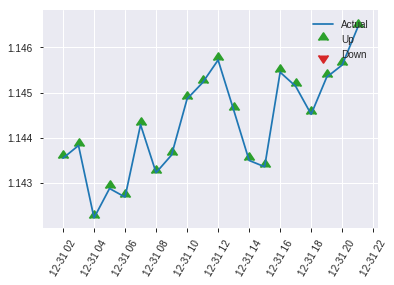


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2503550939044443
RMSE: 0.5003549679022327
LogLoss: 0.6938592542377848
Null degrees of freedom: 616
Residual degrees of freedom: -401
Null deviance: 855.3607874834584
Residual deviance: 856.2223197294265
AIC: 2892.2223197294265
AUC: 0.5381472107982705
pr_auc: 0.5632335572652512
Gini: 0.0762944215965411
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44900948705091126: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    289  0.9966   (289.0/290.0)
1      0    327  0        (0.0/327.0)
Total  1    616  0.4684   (289.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.449009     0.693531   398
max f2                       0.449009     0.849792   398
max f0point5                 0.465018     0.587653   344
max accuracy                 0.47569      0.54295    270
max precision                0.544232     1          0
max recall                   0.449009     1          398
max specificity              0.544232     1          0
max absolute_mcc             0.523963     0.0951566  9
max min_per_class_accuracy   0.484301     0.527586   203
max mean_per_class_accuracy  0.486748     0.544843   184

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 48.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.526673           1.6173    1.6173             0.857143         0.532288  0.857143                    0.532288            0.0183486       0.0183486                  61.73     61.73
    2        0.0210697                   0.520792           1.2579    1.45142            0.666667         0.523742  0.769231                    0.528343            0.0122324       0.030581                   25.79     45.1423
    3        0.0307942                   0.518218           0.943425  1.291              0.5              0.519303  0.684211                    0.525489            0.00917431      0.0397554                  -5.65749  29.1003
    4        0.0405186                   0.515224           0.943425  1.20758            0.5              0.517006  0.64                        0.523453            0.00917431      0.0489297                  -5.65749  20.7584
    5        0.0502431                   0.513783           1.57238   1.27819            0.833333         0.514434  0.677419                    0.521707            0.0152905       0.0642202                  57.2375   27.8189
    6        0.100486                    0.506553           0.730394  1.00429            0.387097         0.510004  0.532258                    0.515856            0.0366972       0.100917                   -26.9606  0.429121
    7        0.150729                    0.502737           1.09559   1.03472            0.580645         0.504441  0.548387                    0.512051            0.0550459       0.155963                   9.55904   3.47243
    8        0.200972                    0.498791           1.21732   1.08037            0.645161         0.500713  0.572581                    0.509216            0.0611621       0.217125                   21.7323   8.03739
    9        0.299838                    0.493323           1.11355   1.09131            0.590164         0.495706  0.578378                    0.504762            0.110092        0.327217                   11.3551   9.13133
    10       0.400324                    0.489072           0.973858  1.06183            0.516129         0.491358  0.562753                    0.501397            0.0978593       0.425076                   -2.61419  6.18307
    11       0.50081                     0.484372           1.00429   1.05029            0.532258         0.48648   0.556634                    0.498404            0.100917        0.525994                   0.429121  5.02855
    12       0.599676                    0.480016           1.02076   1.04542            0.540984         0.481877  0.554054                    0.49568             0.100917        0.626911                   2.0755    4.5417
    13       0.700162                    0.4757             1.00429   1.03951            0.532258         0.477631  0.550926                    0.493089            0.100917        0.727829                   0.429121  3.95147
    14       0.799028                    0.470217           0.897027  1.02188            0.47541          0.473006  0.541582                    0.490604            0.088685        0.816514                   -10.2973  2.18844
    15       0.899514                    0.464266           0.943425  1.01312            0.5              0.467535  0.536937                    0.488027            0.0948012       0.911315                   -5.65749  1.31195
    16       1                           0.448018           0.882559  1                  0.467742         0.458062  0.529984                    0.485016           

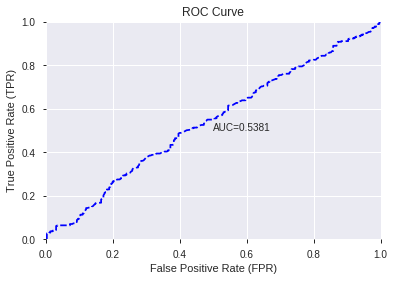

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


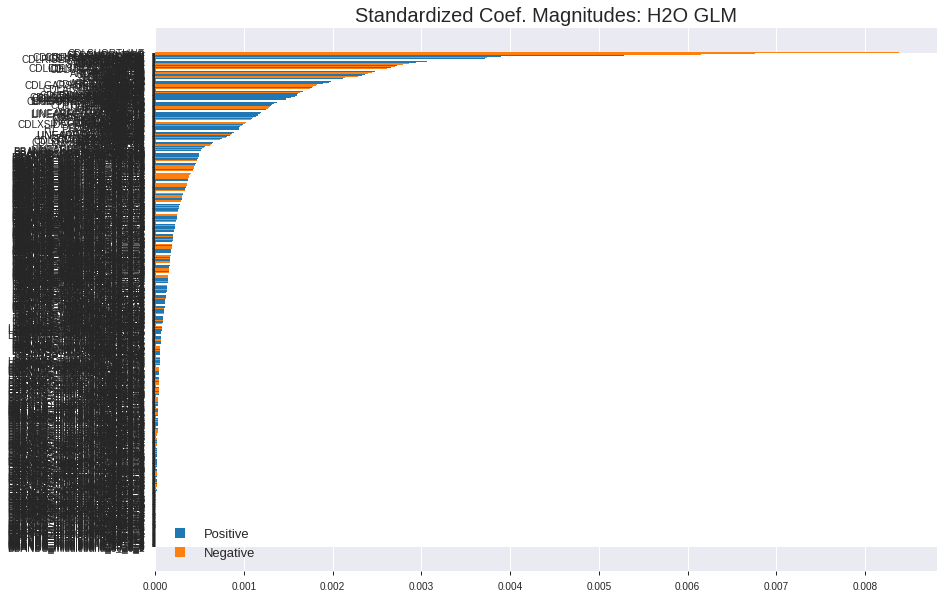

'log_likelihood'
--2019-07-25 06:53:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_065206_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_065206_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLSHORTLINE',
 'hour',
 'aroonup_8',
 'STOCHRSI_fastk',
 'BOP',
 'CDLENGULFING',
 'is_month_start',
 'Volume',
 'CDLGRAVESTONEDOJI',
 'CDLHOMINGPIGEON',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'CDLRISEFALL3METHODS',
 'CDLONNECK',
 'CDLTHRUSTING',
 'STDDEV_24',
 'aroondown_20',
 'CDLHARAMI',
 'AROONOSC_8',
 'ADXR_8',
 'STOCHRSI_fastd',
 'CDL3OUTSIDE',
 'DX_14',
 'ADOSC',
 'DX_20',
 'SUB',
 'DIV',
 'CORREL_24',
 'STDDEV_30',
 'CDLDOJISTAR',
 'TRANGE',
 'CDL3BLACKCROWS',
 'CDLIDENTICAL3CROWS',
 'MFI_8',
 'CDLUNIQUE3RIVER',
 'aroonup_14',
 'aroondown_30',
 'BETA_30',
 'DX_12',
 'AROONOSC_20',
 'DX_24',
 'aroonup_12',
 'CORREL_8',
 'days_in_month',
 'quarter',
 'MFI_20',
 'aroondown_24',
 'CDLINNECK',
 'STDDEV_20',
 'CORREL_20',
 'ULTOSC',
 'is_month_end',
 'BETA_20',
 'aroonup_30',
 'BETA_12',
 'SAREXT',
 'NATR_12',
 'NATR_14',
 'BETA_24',
 'aroondown_12',
 'AROONOSC_14',
 'ATR_12',
 'HT_DCPERIOD',
 'ATR_14',
 'CDLSPINNINGTOP',
 'DX_30',
 'CCI_8',
 'CDLGAPSIDESIDEWHITE',
 'weekofyear',
 'd

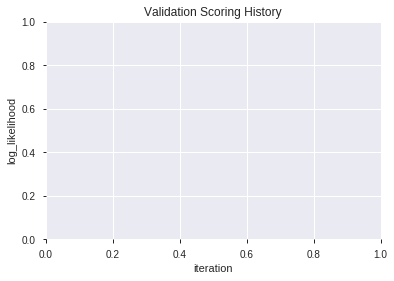

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_065405_model_4  0.545819  0.688410              0.494828  0.497624  0.247630
1  XGBoost_grid_1_AutoML_20190725_065405_model_2  0.535975  0.690176              0.494633  0.498538  0.248540
2  XGBoost_grid_1_AutoML_20190725_065405_model_5  0.535311  0.716278              0.500000  0.509812  0.259909
3               XGBoost_2_AutoML_20190725_065405  0.533228  0.695687              0.494437  0.501116  0.251117
4  XGBoost_grid_1_AutoML_20190725_065405_model_1  0.526189  0.692031              0.487931  0.499439  0.249439
5               XGBoost_3_AutoML_20190725_065405  0.526036  0.692296              0.488875  0.499554  0.249554
6  XGBoost_grid_1_AutoML_20190725_065405_model_7  0.516624  0.705447              0.498276  0.505838  0.255872
7  XGBoost_grid_1_AutoML_20190725_065405_model_3  0.514658  0.697324              0.491379  0.501983  0.251987
8               XGBoost_1_AutoML_20190725_065405  0.502842  0.701439              0.498276  0.503973  0.253988
9  XGBoost_grid_1_AutoML_20190725_065405_model_6  0.500443  0.703932              0.498276  0.505069  0.255095

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastk           115.650055           1.000000    0.021768
1                       hour           115.032089           0.994657    0.021652
2                      MFI_8           108.368362           0.937037    0.020398
3                    BETA_30            97.867699           0.846240    0.018421
4                        BOP            88.658752           0.766612    0.016688
..                       ...                  ...                ...         ...
217                   CCI_24             5.721001           0.049468    0.001077
218  BBANDS_upperband_30_7_5             5.606822           0.048481    0.001055
219               MINUS_DM_8             4.992039           0.043165    0.000940
220   BBANDS_lowerband_8_8_5             4.373616           0.037818    0.000823
221   BBANDS_upperband_8_0_2             4.214256           0.036440    0.000793

[222 rows x 4 columns]

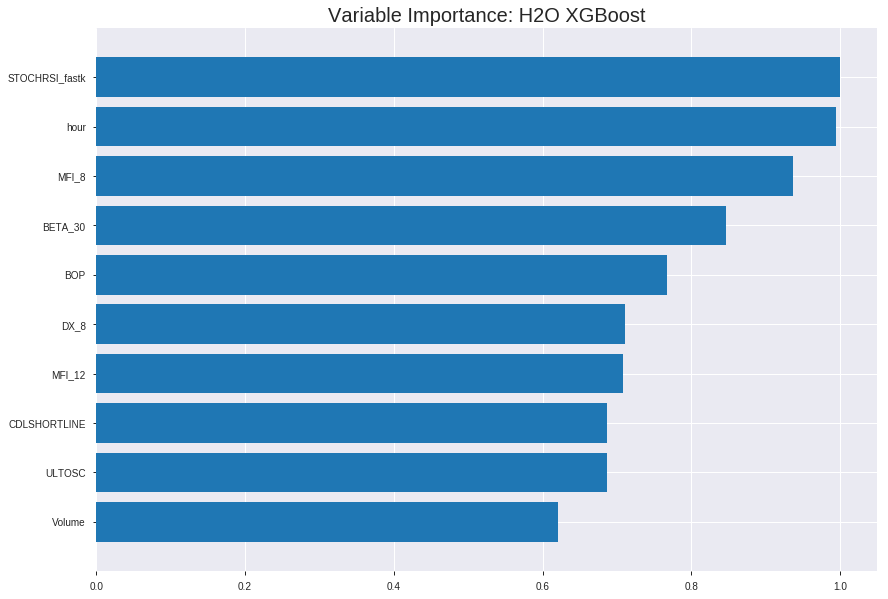

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_065405_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22469210774855994
RMSE: 0.47401699099142
LogLoss: 0.641898706507725
Mean Per-Class Error: 0.29312353112723655
AUC: 0.7738199698076956
pr_auc: 0.7670706787416017
Gini: 0.5476399396153913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47162907677037375: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1062  1098  0.5083   (1098.0/2160.0)
1      300   1859  0.139    (300.0/2159.0)
Total  1362  2957  0.3237   (1398.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471629     0.72674   246
max f2                       0.434892     0.843125  304
max f0point5                 0.515548     0.715301  173
max accuracy                 0.504204     0.706877  192
max precision                0.731114     1         0
max recall                   0.353772     1         381
max specificity              0.731114     1         0
max absolute_mcc             0.504204     0.414092  192
max min_per_class_accuracy   0.500927     0.706346  198
max mean_per_class_accuracy  0.500927     0.706876  198

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 50.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.643813           1.955     1.955              0.977273         0.664348  0.977273                    0.664348            0.0199166       0.0199166                  95.4998   95.4998
    2        0.0201436                   0.627544           1.90742   1.93148            0.953488         0.634129  0.965517                    0.649412            0.0189903       0.0389069                  90.7418   93.1482
    3        0.0300996                   0.617401           1.81437   1.89275            0.906977         0.622184  0.946154                    0.640406            0.0180639       0.0569708                  81.4374   89.2746
    4        0.0400556                   0.608629           1.72133   1.85014            0.860465         0.613188  0.924855                    0.633641            0.0171376       0.0741084                  72.1329   85.0139
    5        0.0500116                   0.603103           1.81437   1.84302            0.906977         0.605741  0.921296                    0.628087            0.0180639       0.0921723                  81.4374   84.3019
    6        0.100023                    0.581099           1.7041    1.77356            0.851852         0.591473  0.886574                    0.60978             0.0852246       0.177397                   70.4098   77.3559
    7        0.150035                    0.564896           1.49109   1.6794             0.74537          0.572155  0.839506                    0.597238            0.0745716       0.251969                   49.1086   67.9401
    8        0.200046                    0.553498           1.54665   1.64621            0.773148         0.559609  0.822917                    0.587831            0.0773506       0.329319                   54.6654   64.6214
    9        0.300069                    0.532202           1.44015   1.57753            0.719907         0.542619  0.78858                     0.57276             0.144048        0.473367                   44.0148   57.7526
    10       0.400093                    0.515983           1.27344   1.50151            0.636574         0.523913  0.750579                    0.560548            0.127374        0.600741                   27.3443   50.1505
    11       0.500116                    0.500573           1.0558    1.41236            0.527778         0.508241  0.706019                    0.550087            0.105604        0.706346                   5.58      41.2364
    12       0.599907                    0.48525            0.86795   1.3218             0.433875         0.492809  0.660749                    0.540559            0.0866142       0.79296                    -13.205   32.1804
    13       0.699931                    0.468707           0.754804  1.24078            0.377315         0.476797  0.620245                    0.531447            0.0754979       0.868458                   -24.5196  24.0777
    14       0.799954                    0.448462           0.629775  1.16438            0.314815         0.459063  0.582055                    0.522397            0.0629921       0.93145                    -37.0225  16.438
    15       0.899977                    0.419828           0.439917  1.08386            0.219907         0.435533  0.541806                    0.512742            0.0440019       0.975452                   -56.0083  8.3863
    16       1                           0.293977           0.245427  1                  0.122685         0.390891  0.499884                    0.500554           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2525059482556486
RMSE: 0.5024996997567746
LogLoss: 0.6983270951954628
Mean Per-Class Error: 0.46745077951587266
AUC: 0.5215335513613617
pr_auc: 0.5154810590559807
Gini: 0.043067102722723405
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3658101558685303: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    614   0.9919   (614.0/619.0)
1      2    613   0.0033   (2.0/615.0)
Total  7    1227  0.4992   (616.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.36581      0.665581   392
max f2                       0.284866     0.832431   399
max f0point5                 0.407357     0.556483   368
max accuracy                 0.534262     0.532415   190
max precision                0.695501     1          0
max recall                   0.284866     1          399
max specificity              0.695501     1          0
max absolute_mcc             0.534262     0.0653216  190
max min_per_class_accuracy   0.539804     0.516963   181
max mean_per_class_accuracy  0.534262     0.532549   190

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 53.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.666211           1.54346   1.54346            0.769231         0.680151  0.769231                    0.680151            0.0162602       0.0162602                  54.3465   54.3465
    2        0.0202593                   0.655395           0.668835  1.12364            0.333333         0.660312  0.56                        0.670628            0.00650407      0.0227642                  -33.1165  12.3642
    3        0.0299838                   0.642736           0.836043  1.03037            0.416667         0.648742  0.513514                    0.66353             0.00813008      0.0308943                  -16.3957  3.0367
    4        0.0405186                   0.631955           1.08043   1.04338            0.538462         0.637637  0.52                        0.656798            0.0113821       0.0422764                  8.04253   4.33821
    5        0.0502431                   0.625449           1.50488   1.1327             0.75             0.628187  0.564516                    0.65126             0.0146341       0.0569106                  50.4878   13.2704
    6        0.100486                    0.606274           0.938526  1.03562            0.467742         0.6151    0.516129                    0.63318             0.0471545       0.104065                   -6.14739  3.5615
    7        0.149919                    0.593898           1.08549   1.05206            0.540984         0.600099  0.524324                    0.622272            0.0536585       0.157724                   8.54858   5.20589
    8        0.200162                    0.583127           0.938526  1.02356            0.467742         0.588255  0.510121                    0.613733            0.0471545       0.204878                   -6.14739  2.35608
    9        0.299838                    0.567352           0.929843  0.992406           0.463415         0.575098  0.494595                    0.60089             0.0926829       0.297561                   -7.01567  -0.759394
    10       0.400324                    0.554171           1.0518    1.00731            0.524194         0.561071  0.502024                    0.590895            0.105691        0.403252                   5.17965   0.731378
    11       0.5                         0.539788           1.15823   1.0374             0.577236         0.547187  0.517018                    0.582181            0.115447        0.518699                   15.8226   3.73984
    12       0.599676                    0.526339           1.04403   1.0385             0.520325         0.533056  0.517568                    0.574016            0.104065        0.622764                   4.40346   3.85014
    13       0.700162                    0.509423           0.970889  1.0288             0.483871         0.517714  0.512731                    0.565936            0.097561        0.720325                   -2.91109  2.87978
    14       0.799838                    0.484402           0.962469  1.02053            0.479675         0.497434  0.508612                    0.557399            0.095935        0.81626                    -3.75306  2.0532
    15       0.899514                    0.447318           0.864591  1.00325            0.430894         0.468361  0.5                         0.547533            0.0861789       0.902439                   -13.5409  0.325203
    16       1                           0.284866           0.970889  1                  0.483871         0.413038  0.498379                    0.534018        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 06:55:06  21.858 sec  0                  0.5              0.693147            0.5             0                  1                0.500116                         0.5                0.693147              0.5               0                    1                  0.501621
    2019-07-25 06:55:07  23.418 sec  5                  0.496897         0.686955            0.635069        0.63248            1.77819          0.462607                         0.499774           0.692696              0.524374          0.514158             0.926079           0.501621
    2019-07-25 06:55:08  24.139 sec  10                 0.493684         0.68057             0.674153        0.661855           1.77314          0.426256                         0.49974            0.692627              0.517709          0.512909             1.08043            0.501621
    2019-07-25 06:55:09  24.890 sec  15                 0.490504         0.674276            0.698918        0.690412           1.90953          0.390137                         0.499896           0.692945              0.522526          0.515376             1.08043            0.498379
    2019-07-25 06:55:09  25.631 sec  20                 0.488677         0.670661            0.706179        0.695791           1.955            0.38759                          0.499981           0.693119              0.524411          0.518785             1.23477            0.501621
    2019-07-25 06:55:10  26.380 sec  25                 0.486164         0.665692            0.712521        0.705851           1.90953          0.374161                         0.500492           0.694155              0.522919          0.51909              1.23477            0.501621
    2019-07-25 06:55:11  27.132 sec  30                 0.483892         0.661208            0.722204        0.7154             1.955            0.368604                         0.500924           0.695049              0.530738          0.522806             1.08043            0.501621
    2019-07-25 06:55:12  28.582 sec  35                 0.480717         0.654984            0.740519        0.735271           1.955            0.353091                         0.501797           0.696828              0.518632          0.514166             1.38912            0.501621
    2019-07-25 06:55:13  29.465 sec  40                 0.477993         0.649646            0.752532        0.746534           1.86407          0.335263                         0.502562           0.698434              0.517874          0.511632             1.23477            0.501621
    2019-07-25 06:55:14  30.226 sec  45                 0.475807         0.64539             0.766273        0.759742           1.90953          0.323223                         0.502602           0.698527              0.518325          0.51127              1.38912            0.49919
    2019-07-25 06:55:15  31.043 sec  50                 0.474017         0.641899            0.77382         0.767071           1.955            0.323686                         0.5025             0.698327              0.521534          0.515481             1.54346            0.49919

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
STOCHRSI_fastk           115.65005493164062     1.0                   0.021768457317838247
hour                     115.03208923339844     0.9946565896695211    0.02165213951812752
MFI_8                    108.36836242675781     0.9370368435260412    0.020397846533538506
BETA_30                  97.8676986694336       0.846239967004616     0.018421338602388832
BOP                      88.65875244140625      0.7666122812808985    0.01668796672439385
---                      ---                    ---                   ---
CCI_24                   5.721000671386719      0.049468205395737465  0.0010768465177471665
BBANDS_upperband_30_7_5  5.606821537017822      0.048480924114838925  0.0010553549273232261
MINUS_DM_8               4.992038726806641      0.04316503550091157   0.0009396362329245662
BBANDS_lowerband_8_8_5   4.373615741729736      0.037817671114077106  0.0008232323595068319
BBANDS_upperband_8_0_2   4.214256286621094      0.03643972576677193   0.0007932366150277053


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5623987034035657)

('F1', 0.6950053134962806)

('auc', 0.5458188337024148)

('logloss', 0.6884103927240884)

('mean_per_class_error', 0.446984076768955)

('rmse', 0.497624329071963)

('mse', 0.24762997288432137)

xgboost prediction progress: |████████████████████████████████████████████| 100%


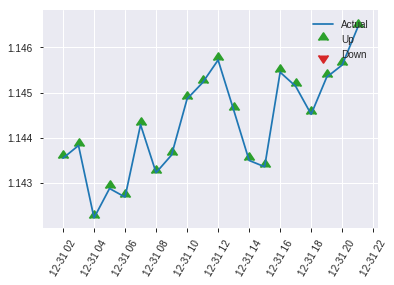


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24762997288432137
RMSE: 0.497624329071963
LogLoss: 0.6884103927240884
Mean Per-Class Error: 0.446984076768955
AUC: 0.5458188337024148
pr_auc: 0.5635010632459023
Gini: 0.09163766740482959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4349622130393982: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    287  0.9897   (287.0/290.0)
1      0    327  0        (0.0/327.0)
Total  3    614  0.4652   (287.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434962     0.695005  396
max f2                       0.434962     0.850676  396
max f0point5                 0.52981      0.593607  257
max accuracy                 0.530164     0.562399  256
max precision                0.692335     1         0
max recall                   0.434962     1         396
max specificity              0.692335     1         0
max absolute_mcc             0.530164     0.111687  256
max min_per_class_accuracy   0.546153     0.535168  206
max mean_per_class_accuracy  0.530164     0.553016  256

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 54.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.651644           1.6173    1.6173             0.857143         0.664154  0.857143                    0.664154            0.0183486       0.0183486                  61.73     61.73
    2        0.0210697                   0.644374           0.62895   1.16114            0.333333         0.646757  0.615385                    0.656125            0.00611621      0.0244648                  -37.105   16.1139
    3        0.0307942                   0.637209           0.943425  1.09239            0.5              0.640601  0.578947                    0.651222            0.00917431      0.0336391                  -5.65749  9.23869
    4        0.0405186                   0.634587           1.57238   1.20758            0.833333         0.635848  0.64                        0.647533            0.0152905       0.0489297                  57.2375   20.7584
    5        0.0502431                   0.628843           0.62895   1.09559            0.333333         0.632804  0.580645                    0.644682            0.00611621      0.0550459                  -37.105   9.55904
    6        0.100486                    0.611257           1.09559   1.09559            0.580645         0.622027  0.580645                    0.633354            0.0550459       0.110092                   9.55904   9.55904
    7        0.150729                    0.595878           1.03472   1.0753             0.548387         0.601635  0.569892                    0.622781            0.0519878       0.16208                    3.47243   7.53017
    8        0.200972                    0.585054           0.852126  1.01951            0.451613         0.589274  0.540323                    0.614404            0.0428135       0.204893                   -14.7874  1.95077
    9        0.299838                    0.570309           1.02076   1.01992            0.540984         0.577458  0.540541                    0.602222            0.100917        0.30581                    2.0755    1.9919
    10       0.400324                    0.558516           1.15646   1.05419            0.612903         0.564648  0.558704                    0.592791            0.116208        0.422018                   15.6457   5.41916
    11       0.50081                     0.546153           1.12602   1.0686             0.596774         0.552055  0.566343                    0.584617            0.11315         0.535168                   12.6023   6.86045
    12       0.599676                    0.537838           1.11355   1.07601            0.590164         0.541792  0.57027                     0.577557            0.110092        0.64526                    11.3551   7.60145
    13       0.700162                    0.525839           0.943425  1.05699            0.5              0.531603  0.560185                    0.570962            0.0948012       0.740061                   -5.65749  5.69855
    14       0.799028                    0.509089           0.897027  1.03719            0.47541          0.517483  0.549696                    0.564345            0.088685        0.828746                   -10.2973  3.71935
    15       0.899514                    0.492931           0.882559  1.01992            0.467742         0.501825  0.540541                    0.55736             0.088685        0.917431                   -11.7441  1.9919
    16       1                           0.412641           0.821693  1                  0.435484         0.467007  0.529984                    0.548281            0

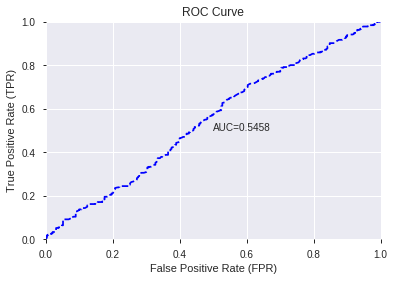

This function is available for GLM models only


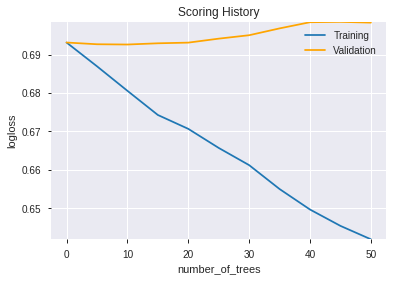

--2019-07-25 06:55:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_065405_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_065405_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCHRSI_fastk',
 'hour',
 'MFI_8',
 'BETA_30',
 'BOP',
 'DX_8',
 'MFI_12',
 'CDLSHORTLINE',
 'ULTOSC',
 'Volume',
 'HT_DCPERIOD',
 'BETA_12',
 'MFI_14',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'STDDEV_8',
 'PLUS_DM_8',
 'MACDFIX_hist_20',
 'dayofyear',
 'day',
 'STDDEV_14',
 'aroondown_20',
 'BETA_24',
 'BBANDS_lowerband_30_7_4',
 'STDDEV_24',
 'BETA_8',
 'AROONOSC_8',
 'STOCHRSI_fastd',
 'BETA_14',
 'ROC_12',
 'WILLR_12',
 'MACDEXT_signal',
 'TRIX_8',
 'ADXR_8',
 'ADOSC',
 'STOCH_slowd',
 'AROONOSC_20',
 'MOM_8',
 'MFI_30',
 'DX_20',
 'DX_30',
 'BBANDS_lowerband_24_7_5',
 'STOCH_slowk',
 'STDDEV_20',
 'STDDEV_12',
 'MINUS_DI_24',
 'SAREXT',
 'CCI_8',
 'LINEARREG_ANGLE_20',
 'PLUS_DM_24',
 'MINUS_DM_30',
 'MACDFIX_signal_24',
 'CCI_12',
 'DX_24',
 'aroonup_8',
 'NATR_12',
 'AROONOSC_24',
 'CMO_30',
 'BBANDS_lowerband_24_2_5',
 'MINUS_DI_30',
 'MOM_12',
 'BETA_20',
 'MOM_24',
 'CMO_20',
 'ADX_24',
 'DX_14',
 'aroonup_24',
 'MFI_20',
 'AROONOSC_14',
 'MACDFIX_hist_12',
 'MACDE

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

540

['MAVP_8_2',
 'T3_8_2',
 'BBANDS_upperband_8_2_2',
 'BBANDS_middleband_8_2_2',
 'BBANDS_lowerband_8_2_2',
 'BBANDS_upperband_8_2_3',
 'BBANDS_middleband_8_2_3',
 'BBANDS_lowerband_8_2_3',
 'BBANDS_upperband_8_2_4',
 'BBANDS_middleband_8_2_4',
 'BBANDS_lowerband_8_2_4',
 'BBANDS_upperband_8_2_5',
 'BBANDS_middleband_8_2_5',
 'BBANDS_lowerband_8_2_5',
 'MA_8_3',
 'MAVP_8_3',
 'T3_8_3',
 'BBANDS_upperband_8_3_2',
 'BBANDS_middleband_8_3_2',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_upperband_8_3_3',
 'BBANDS_middleband_8_3_3',
 'BBANDS_lowerband_8_3_3',
 'BBANDS_upperband_8_3_4',
 'BBANDS_middleband_8_3_4',
 'BBANDS_lowerband_8_3_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_middleband_8_3_5',
 'MA_8_4',
 'MAVP_8_4',
 'BBANDS_upperband_8_4_2',
 'BBANDS_middleband_8_4_2',
 'BBANDS_lowerband_8_4_2',
 'BBANDS_upperband_8_4_3',
 'BBANDS_middleband_8_4_3',
 'BBANDS_lowerband_8_4_3',
 'BBANDS_upperband_8_4_4',
 'BBANDS_middleband_8_4_4',
 'BBANDS_lowerband_8_4_4',
 'BBANDS_upperband_8_4_5',
 'BBANDS_middle

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_070146_model_2  0.538005  0.699694              0.494828  0.502816  0.252824
1  DeepLearning_grid_1_AutoML_20190725_070146_model_1  0.521955  0.785448              0.500000  0.531586  0.282583
2  DeepLearning_grid_1_AutoML_20190725_070146_model_4  0.510303  0.695216              0.489460  0.501033  0.251035
3  DeepLearning_grid_1_AutoML_20190725_070146_model_7  0.503733  0.702895              0.500000  0.504832  0.254856
4               DeepLearning_1_AutoML_20190725_070146  0.500000  0.694216              0.500000  0.500534  0.250535
5  DeepLearning_grid_1_AutoML_20190725_070146_model_5  0.500000  0.694112              0.500000  0.500482  0.250483
6  DeepLearning_grid_1_AutoML_20190725_070146_model_8  0.500000  0.694013              0.500000  0.500433  0.250433
7  DeepLearning_grid_1_AutoML_20190725_070146_model_6  0.500000  0.692961              0.500000  0.499907  0.249907
8  DeepLearning_grid_1_AutoML_20190725_070146_model_3  0.490362  0.711917              0.500000  0.508763  0.258840

variable  relative_importance  scaled_importance  percentage
0         CDLONNECK             1.000000           1.000000    0.004595
1         CORREL_30             0.929367           0.929367    0.004270
2         aroonup_8             0.902964           0.902964    0.004149
3      HT_TRENDMODE             0.888372           0.888372    0.004082
4         CDLINNECK             0.864458           0.864458    0.003972
..              ...                  ...                ...         ...
535      MACDFIX_12             0.315998           0.315998    0.001452
536      MACDFIX_14             0.314768           0.314768    0.001446
537  CDLHARAMICROSS             0.310368           0.310368    0.001426
538          TRIX_8             0.309176           0.309176    0.001421
539      CDL3INSIDE             0.287341           0.287341    0.001320

[540 rows x 4 columns]

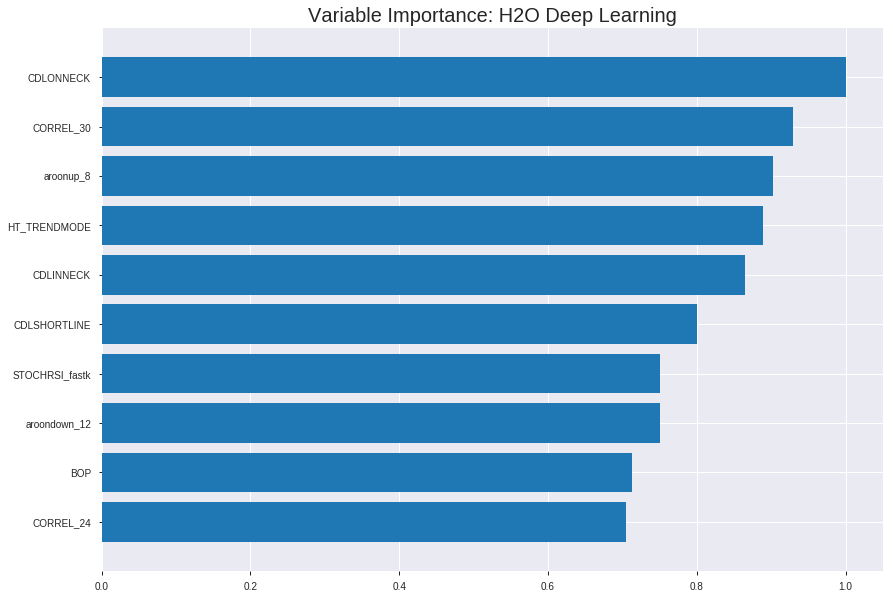

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_070146_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.27465232000325135
RMSE: 0.5240728193707925
LogLoss: 0.7568086304212014
Mean Per-Class Error: 0.46310716981455746
AUC: 0.5388360309128025
pr_auc: 0.5497553051021291
Gini: 0.07767206182560504
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08101714110662428: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      6    2154  0.9972   (2154.0/2160.0)
1      2    2157  0.0009   (2.0/2159.0)
Total  8    4311  0.4992   (2156.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0810171    0.66677    395
max f2                       0.0665663    0.833269   399
max f0point5                 0.173076     0.557903   352
max accuracy                 0.466236     0.53693    157
max precision                0.995767     1          0
max recall                   0.0665663    1          399
max specificity              0.995767     1          0
max absolute_mcc             0.518592     0.0882532  117
max min_per_class_accuracy   0.408653     0.516906   200
max mean_per_class_accuracy  0.466236     0.536893   157

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 38.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.713394           1.45488   1.45488            0.727273         0.773384  0.727273                    0.773384            0.0148217       0.0148217                  45.4882    45.4882
    2        0.0201436                   0.676815           1.53524   1.4946             0.767442         0.689114  0.747126                    0.731734            0.0152849       0.0301065                  53.5239    49.4599
    3        0.0300996                   0.653998           1.02349   1.33877            0.511628         0.66327   0.669231                    0.709088            0.0101899       0.0402964                  2.34928    33.8772
    4        0.0400556                   0.630432           1.39567   1.35291            0.697674         0.641606  0.676301                    0.692315            0.0138953       0.0541918                  39.5672    35.2914
    5        0.0500116                   0.618032           1.44219   1.37069            0.72093          0.623469  0.685185                    0.678609            0.0143585       0.0685503                  44.2194    37.0688
    6        0.100023                    0.569151           1.04654   1.20861            0.523148         0.592231  0.604167                    0.63542             0.052339        0.120889                   4.65386    20.8613
    7        0.150035                    0.541425           1.12989   1.18237            0.564815         0.554351  0.591049                    0.608397            0.0565076       0.177397                   12.9891    18.2373
    8        0.200046                    0.519383           1.14841   1.17388            0.574074         0.530534  0.586806                    0.588931            0.057434        0.234831                   14.8414    17.3883
    9        0.300069                    0.47833            1.00949   1.11909            0.50463          0.497745  0.559414                    0.558536            0.100973        0.335804                   0.949299   11.9086
    10       0.400093                    0.446425           0.977078  1.08358            0.488426         0.462596  0.541667                    0.534551            0.0977304       0.433534                   -2.29219   8.35842
    11       0.500116                    0.407488           0.838157  1.0345             0.418981         0.428251  0.51713                     0.513291            0.0838351       0.517369                   -16.1843   3.44988
    12       0.599907                    0.351071           0.932931  1.0176             0.466357         0.381311  0.508684                    0.491337            0.0930987       0.610468                   -6.70694   1.76034
    13       0.699931                    0.285823           1.04191   1.02108            0.520833         0.317813  0.51042                     0.466539            0.104215        0.714683                   4.19079    2.10766
    14       0.799954                    0.231917           0.977078  1.01558            0.488426         0.257718  0.50767                     0.440429            0.0977304       0.812413                   -2.29219   1.55752
    15       0.899977                    0.180395           0.995601  1.01336            0.497685         0.20662   0.50656                     0.414444            0.0995831       0.911996                   -0.439911  1.33553
    16       1                           0.0656718          0.879833  1                  0.439815         0.145102  0.499884                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25943827667948965
RMSE: 0.509350838498858
LogLoss: 0.7127220616420781
Mean Per-Class Error: 0.48828821729251226
AUC: 0.4968885036184772
pr_auc: 0.5074109108057738
Gini: -0.0062229927630456094
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33005415687189094: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   603   0.9742   (603.0/619.0)
1      6    609   0.0098   (6.0/615.0)
Total  22   1212  0.4935   (609.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.330054     0.666667   381
max f2                       0.26369      0.832882   397
max f0point5                 0.335476     0.557398   378
max accuracy                 0.647138     0.511345   72
max precision                0.999365     1          0
max recall                   0.26369      1          397
max specificity              0.999365     1          0
max absolute_mcc             0.801023     0.0810415  7
max min_per_class_accuracy   0.511435     0.487884   209
max mean_per_class_accuracy  0.417261     0.511712   318

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 51.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.766968           1.38912   1.38912            0.692308         0.82994   0.692308                    0.82994             0.0146341       0.0146341                  38.9118   38.9118
    2        0.0202593                   0.739494           1.17046   1.28416            0.583333         0.755591  0.64                        0.794252            0.0113821       0.0260163                  17.0461   28.4163
    3        0.0299838                   0.727615           1.00325   1.19306            0.5              0.734948  0.594595                    0.775018            0.0097561       0.0357724                  0.325203  19.3056
    4        0.0405186                   0.703283           0.926079  1.12364            0.461538         0.713116  0.56                        0.758924            0.0097561       0.0455285                  -7.39212  12.3642
    5        0.0502431                   0.690248           1.00325   1.10034            0.5              0.697072  0.548387                    0.746952            0.0097561       0.0552846                  0.325203  10.0341
    6        0.100486                    0.653509           1.03562   1.06798            0.516129         0.67127   0.532258                    0.709111            0.0520325       0.107317                   3.5615    6.7978
    7        0.149919                    0.628023           0.953912  1.03037            0.47541          0.639013  0.513514                    0.685998            0.0471545       0.154472                   -4.60882  3.0367
    8        0.200162                    0.603181           0.970889  1.01544            0.483871         0.613493  0.506073                    0.667798            0.0487805       0.203252                   -2.91109  1.54373
    9        0.299838                    0.564258           0.897217  0.976137           0.447154         0.583771  0.486486                    0.639865            0.0894309       0.292683                   -10.2783  -2.38629
    10       0.400324                    0.536414           1.03562   0.991067           0.516129         0.550441  0.493927                    0.617418            0.104065        0.396748                   3.5615    -0.893321
    11       0.5                         0.511472           0.946156  0.982114           0.471545         0.523825  0.489465                    0.59876             0.0943089       0.491057                   -5.38436  -1.78862
    12       0.599676                    0.485681           0.91353   0.970714           0.455285         0.498456  0.483784                    0.582088            0.0910569       0.582114                   -8.64697  -2.92859
    13       0.700162                    0.463537           1.14889   0.996285           0.572581         0.475244  0.496528                    0.566754            0.115447        0.697561                   14.8885   -0.3715
    14       0.799838                    0.437088           1.1256    1.0124             0.560976         0.449777  0.504559                    0.552176            0.112195        0.809756                   12.56     1.24002
    15       0.899514                    0.400537           0.929843  1.00325            0.463415         0.421246  0.5                         0.537668            0.0926829       0.902439                   -7.01567  0.325203
    16       1                           0.238825           0.970889  1                  0.483871         0.354337  0.498379                    0.519246     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:04:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 07:05:00  3 min 13.262 sec  924 obs/sec       0.557536  1             2408       0.581912         1.00745             -0.354486      0.515437        0.513785           1.13663          0.500116                         0.604523           1.1916                -0.461809        0.52411           0.514591             0.771732           0.501621
    2019-07-25 07:05:19  3 min 32.134 sec  841 obs/sec       3.84325   7             16599      0.620055         1.50795             -0.537871      0.502079        0.486784           0.863836         0.500116                         0.701039           3.10347               -0.965845        0.528953          0.513228             1.23477            0.50081
    2019-07-25 07:05:36  3 min 49.963 sec  928 obs/sec       7.7166    14            33328      0.529645         0.774969            -0.122094      0.519112        0.517916           1.22756          0.500116                         0.577309           0.95121               -0.333159        0.533086          0.529961             0.926079           0.49919
    2019-07-25 07:05:54  4 min  7.402 sec  1012 obs/sec      12.1114   22            52309      0.509387         0.720317            -0.0379009     0.532405        0.526611           1.13663          0.500116                         0.51828            0.736963              -0.0744699       0.524347          0.526477             1.69781            0.501621
    2019-07-25 07:06:12  4 min 25.932 sec  1077 obs/sec      17.0852   31            73791      0.504726         0.703756            -0.018995      0.539407        0.540158           1.45488          0.500116                         0.51552            0.726679              -0.0630555       0.474944          0.490234             1.54346            0.5
    2019-07-25 07:06:30  4 min 43.030 sec  1163 obs/sec      22.6099   41            97652      0.511259         0.71766             -0.0455428     0.513105        0.512833           1.36395          0.498727                         0.520566           0.739128              -0.083966        0.487817          0.491399             1.08043            0.5
    2019-07-25 07:06:47  5 min  0.184 sec  1244 obs/sec      28.6203   52            123611     0.512063         0.723001            -0.0488326     0.549891        0.541654           1.27302          0.49479                          0.538052           0.795497              -0.158014        0.538152          0.530896             1.23477            0.491896
    2019-07-25 07:07:04  5 min 17.207 sec  1326 obs/sec      35.2211   64            152120     0.524073         0.756809            -0.0986093     0.538836        0.549755           1.45488          0.49919                          0.509351           0.712722              -0.037764        0.496889          0.507411             1.38912            0.493517
    2019-07-25 07:07:21  5 min 34.3

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ---------------------
CDLONNECK       1.0                    1.0                  0.004594983631913317
CORREL_30       0.9293673634529114     0.9293673634529114   0.004270427823100562
aroonup_8       0.9029642343521118     0.9029642343521118   0.004149105877051094
HT_TRENDMODE    0.8883715867996216     0.8883715867996216   0.004082052900401122
CDLINNECK       0.8644576668739319     0.8644576668739319   0.003972168829767692
---             ---                    ---                  ---
MACDFIX_12      0.3159978985786438     0.3159978985786438   0.0014520051716878726
MACDFIX_14      0.3147684931755066     0.3147684931755066   0.0014463560739834712
CDLHARAMICROSS  0.310367614030838      0.310367614030838    0.0014261341063476905
TRIX_8          0.30917641520500183    0.30917641520500183  0.0014206605672406189
CDL3INSIDE      0.28734084963798523    0.28734084963798523  0.0013203265008666077


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5429497568881686)

('F1', 0.6950053134962806)

('auc', 0.5380048507856163)

('logloss', 0.6996937618887287)

('mean_per_class_error', 0.45548349678371824)

('rmse', 0.502816419379146)

('mse', 0.2528243515972652)

deeplearning prediction progress: |███████████████████████████████████████| 100%


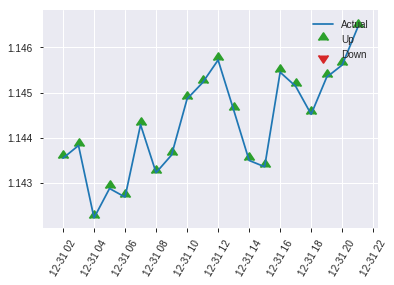


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2528243515972652
RMSE: 0.502816419379146
LogLoss: 0.6996937618887287
Mean Per-Class Error: 0.45548349678371824
AUC: 0.5380048507856163
pr_auc: 0.5640837866805171
Gini: 0.07600970157123266
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30266175272206236: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    287  0.9897   (287.0/290.0)
1      0    327  0        (0.0/327.0)
Total  3    614  0.4652   (287.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.302662     0.695005   396
max f2                       0.302662     0.850676   396
max f0point5                 0.302662     0.587496   396
max accuracy                 0.515282     0.54295    230
max precision                0.949765     1          0
max recall                   0.302662     1          396
max specificity              0.949765     1          0
max absolute_mcc             0.552757     0.0908813  173
max min_per_class_accuracy   0.528005     0.53211    207
max mean_per_class_accuracy  0.552757     0.544517   173

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 53.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.759859           0.80865   0.80865            0.428571         0.820145  0.428571                    0.820145            0.00917431      0.00917431                 -19.135   -19.135
    2        0.0210697                   0.742188           1.2579    1.016              0.666667         0.746253  0.538462                    0.786041            0.0122324       0.0214067                  25.79     1.59962
    3        0.0307942                   0.726449           1.2579    1.09239            0.666667         0.732295  0.578947                    0.769068            0.0122324       0.0336391                  25.79     9.23869
    4        0.0405186                   0.718637           1.2579    1.13211            0.666667         0.722573  0.6                         0.757909            0.0122324       0.0458716                  25.79     13.211
    5        0.0502431                   0.707451           0.943425  1.09559            0.5              0.71346   0.580645                    0.749306            0.00917431      0.0550459                  -5.65749  9.55904
    6        0.100486                    0.65897            1.27819   1.18689            0.677419         0.684606  0.629032                    0.716956            0.0642202       0.119266                   27.8189   18.689
    7        0.150729                    0.63126            1.15646   1.17675            0.612903         0.645348  0.623656                    0.693087            0.058104        0.17737                    15.6457   17.6745
    8        0.200972                    0.613262           0.912992  1.11081            0.483871         0.621866  0.58871                     0.675282            0.0458716       0.223242                   -8.7008   11.0807
    9        0.299838                    0.579222           1.11355   1.11171            0.590164         0.594619  0.589189                    0.648685            0.110092        0.333333                   11.3551   11.1712
    10       0.400324                    0.550936           1.06516   1.10003            0.564516         0.564322  0.582996                    0.627508            0.107034        0.440367                   6.51573   10.0026
    11       0.50081                     0.527873           0.912992  1.0625             0.483871         0.53787   0.563107                    0.609523            0.0917431       0.53211                    -8.7008   6.24981
    12       0.599676                    0.511738           0.989823  1.05052            0.52459          0.519499  0.556757                    0.594681            0.0978593       0.629969                   -1.0177   5.05166
    13       0.700162                    0.487271           0.882559  1.02641            0.467742         0.500569  0.543981                    0.581174            0.088685        0.718654                   -11.7441  2.64115
    14       0.799028                    0.460192           0.804231  0.998921           0.42623          0.473208  0.529412                    0.567815            0.0795107       0.798165                   -19.5769  -0.107933
    15       0.899514                    0.406918           1.00429   0.999521           0.532258         0.436065  0.52973                     0.553097            0.100917        0.899083                   0.429121  -0.0479378
    16       1                           0.277858           1.00429   1                  0.532258         0.368236  0.529984                    0.534521      

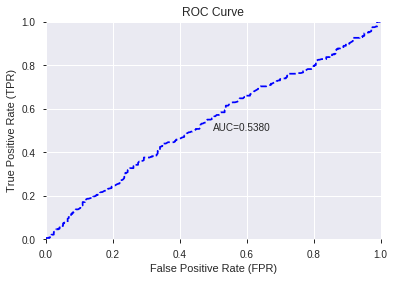

This function is available for GLM models only


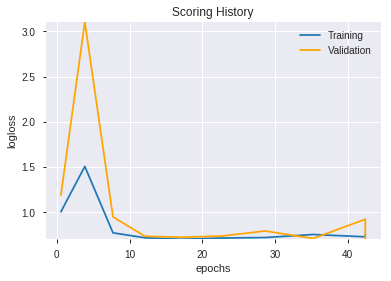

--2019-07-25 07:36:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.96
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.96|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_070146_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_070146_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLONNECK',
 'CORREL_30',
 'aroonup_8',
 'HT_TRENDMODE',
 'CDLINNECK',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'aroondown_12',
 'BOP',
 'CORREL_24',
 'aroonup_20',
 'aroonup_30',
 'aroondown_30',
 'aroondown_20',
 'aroondown_24',
 'CORREL_20',
 'CDLIDENTICAL3CROWS',
 'aroonup_14',
 'aroonup_12',
 'aroonup_24',
 'STOCHRSI_fastd',
 'BETA_8',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLRICKSHAWMAN',
 'ADOSC',
 'OBV',
 'CDLHIKKAKE',
 'BETA_14',
 'AROONOSC_8',
 'AROONOSC_20',
 'AROONOSC_14',
 'MFI_30',
 'AROONOSC_12',
 'STOCH_slowd',
 'CDLGRAVESTONEDOJI',
 'DX_8',
 'CDLSPINNINGTOP',
 'BETA_30',
 'WILLR_12',
 'BETA_24',
 'CDLDOJI',
 'BETA_20',
 'BETA_12',
 'MFI_20',
 'CDLHAMMER',
 'STOCHF_fastd',
 'CDLENGULFING',
 'WILLR_8',
 'AROONOSC_24',
 'MFI_12',
 'VAR_8',
 'MFI_24',
 'MFI_14',
 'DX_14',
 'WILLR_30',
 'ULTOSC',
 'AROONOSC_30',
 'STOCHF_fastk',
 'ADX_8',
 'STOCH_slowk',
 'ADXR_14',
 'WILLR_24',
 'CCI_14',
 'DX_12',
 'ADX_12',
 'CDLLONGLINE',
 'DX_30',
 'CDLEVENINGSTAR',
 'CCI_12',
 'DX_24',


In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_073657_model_1  0.528198  0.693971                   0.5  0.500408  0.250408

variable  relative_importance  scaled_importance    percentage
0                CDLSHORTLINE         1.838839e-02           1.000000  3.011786e-02
1                   aroonup_8         1.568342e-02           0.852898  2.568746e-02
2                CDLENGULFING         1.249479e-02           0.679493  2.046488e-02
3              STOCHRSI_fastk         1.248115e-02           0.678752  2.044255e-02
4                         BOP         1.188532e-02           0.646349  1.946665e-02
..                        ...                  ...                ...           ...
535                 MAVP_30_1         4.132567e-06           0.000225  6.768622e-06
536  BBANDS_middleband_12_0_3         3.261020e-06           0.000177  5.341137e-06
537                    TSF_20         1.734301e-06           0.000094  2.840565e-06
538                   MA_20_2         6.759322e-07           0.000037  1.107091e-06
539                    MA_8_6         2.717834e-07           0.000015  4.451468e-07

[540 rows x 4 columns]

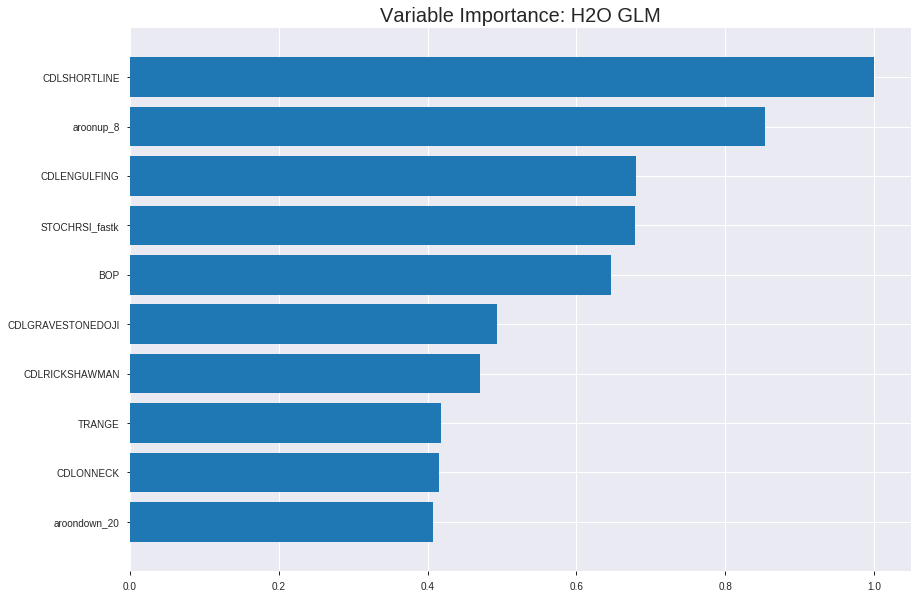

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_073657_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24794769810242936
RMSE: 0.49794346878177786
LogLoss: 0.6890301279266782
Null degrees of freedom: 4318
Residual degrees of freedom: 3778
Null deviance: 5987.405114141723
Residual deviance: 5951.842245030646
AIC: 7033.842245030646
AUC: 0.5593285214348206
pr_auc: 0.5587643027081308
Gini: 0.11865704286964118
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44017574429275574: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      5    2155  0.9977   (2155.0/2160.0)
1      1    2158  0.0005   (1.0/2159.0)
Total  6    4313  0.4992   (2156.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.440176     0.666873   395
max f2                       0.438688     0.833462   396
max f0point5                 0.465849     0.561137   344
max accuracy                 0.504427     0.545728   187
max precision                0.678676     1          0
max recall                   0.438688     1          396
max specificity              0.678676     1          0
max absolute_mcc             0.492621     0.0934064  239
max min_per_class_accuracy   0.499653     0.54213    207
max mean_per_class_accuracy  0.504427     0.545711   187

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 49.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.558223           1.50035   1.50035            0.75             0.571096  0.75                        0.571096            0.0152849       0.0152849                  50.0347   50.0347
    2        0.0201436                   0.550095           1.48872   1.4946             0.744186         0.55293   0.747126                    0.562118            0.0148217       0.0301065                  48.8717   49.4599
    3        0.0300996                   0.545197           1.30263   1.4311             0.651163         0.547734  0.715385                    0.55736             0.012969        0.0430755                  30.2627   43.1101
    4        0.0400556                   0.541547           0.883926  1.2951             0.44186          0.543409  0.647399                    0.553892            0.00880037      0.0518759                  -11.6074  29.5098
    5        0.0500116                   0.53926            0.97697   1.23177            0.488372         0.540242  0.615741                    0.551175            0.00972673      0.0616026                  -2.30296  23.1767
    6        0.100023                    0.53076            1.18546   1.20861            0.592593         0.534772  0.604167                    0.542973            0.0592867       0.120889                   18.546    20.8613
    7        0.150035                    0.525108           1.16694   1.19472            0.583333         0.527535  0.597222                    0.537827            0.0583604       0.17925                    16.6937   19.4721
    8        0.200046                    0.520519           1.06506   1.16231            0.532407         0.522752  0.581019                    0.534058            0.0532654       0.232515                   6.50614   16.2306
    9        0.300069                    0.512439           1.01412   1.11291            0.506944         0.51639   0.556327                    0.528169            0.101436        0.333951                   1.41237   11.2912
    10       0.400093                    0.505875           1.09748   1.10905            0.548611         0.508993  0.554398                    0.523375            0.109773        0.443724                   9.74763   10.9053
    11       0.500116                    0.499559           0.986339  1.08451            0.493056         0.502798  0.54213                     0.519259            0.0986568       0.542381                   -1.36605  8.45104
    12       0.599907                    0.493181           1.01648   1.07319            0.508121         0.49618   0.536472                    0.51542             0.101436        0.643817                   1.64766   7.31933
    13       0.699931                    0.486212           0.870572  1.04424            0.435185         0.489975  0.521998                    0.511784            0.0870774       0.730894                   -12.9428  4.42378
    14       0.799954                    0.478585           0.898356  1.026              0.449074         0.482649  0.51288                     0.508141            0.0898564       0.82075                    -10.1644  2.59973
    15       0.899977                    0.468964           0.958555  1.0185             0.479167         0.474053  0.509133                    0.504353            0.0958777       0.916628                   -4.14447  1.85018
    16       1                           0.431653           0.833526  1                  0.416667         0.45968   0.499884                    0.499884         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24952197808251406
RMSE: 0.4995217493588383
LogLoss: 0.6921830213229843
Null degrees of freedom: 1233
Residual degrees of freedom: 693
Null deviance: 1710.685455494171
Residual deviance: 1708.3076966251251
AIC: 2790.307696625125
AUC: 0.5218605934039955
pr_auc: 0.522832873556395
Gini: 0.043721186807990975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44366346063439394: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    612   0.9887   (612.0/619.0)
1      2    613   0.0033   (2.0/615.0)
Total  9    1225  0.4976   (614.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.443663     0.666304   392
max f2                       0.437103     0.832882   397
max f0point5                 0.443663     0.555757   392
max accuracy                 0.509254     0.525932   114
max precision                0.656285     1          0
max recall                   0.437103     1          397
max specificity              0.656285     1          0
max absolute_mcc             0.534014     0.0662487  25
max min_per_class_accuracy   0.492981     0.508885   200
max mean_per_class_accuracy  0.509254     0.525094   114

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 49.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.543605           1.23477   1.23477            0.615385         0.562642  0.615385                    0.562642            0.0130081       0.0130081                  23.4772   23.4772
    2        0.0202593                   0.536519           1.33767   1.28416            0.666667         0.539404  0.64                        0.551488            0.0130081       0.0260163                  33.7669   28.4163
    3        0.0299838                   0.533953           1.50488   1.35575            0.75             0.535271  0.675676                    0.546228            0.0146341       0.0406504                  50.4878   35.5746
    4        0.0405186                   0.531502           0.617386  1.16377            0.307692         0.532678  0.58                        0.542705            0.00650407      0.0471545                  -38.2614  16.3772
    5        0.0502431                   0.529828           1.00325   1.1327             0.5              0.530471  0.564516                    0.540337            0.0097561       0.0569106                  0.325203  13.2704
    6        0.100486                    0.522768           1.00325   1.06798            0.5              0.52611   0.532258                    0.533224            0.0504065       0.107317                   0.325203  6.7978
    7        0.149919                    0.517189           1.11838   1.0846             0.557377         0.519886  0.540541                    0.528826            0.0552846       0.162602                   11.8379   8.45968
    8        0.200162                    0.512877           1.16507   1.1048             0.580645         0.514782  0.550607                    0.525301            0.0585366       0.221138                   16.5067   10.4796
    9        0.299838                    0.504997           0.91353   1.04121            0.455285         0.508695  0.518919                    0.51978             0.0910569       0.312195                   -8.64697  4.12129
    10       0.400324                    0.498756           1.00325   1.03168            0.5              0.502105  0.51417                     0.515344            0.100813        0.413008                   0.325203  3.16843
    11       0.5                         0.492972           0.962469  1.01789            0.479675         0.495877  0.507293                    0.511463            0.095935        0.508943                   -3.75306  1.78862
    12       0.599676                    0.486061           1.02772   1.01952            0.512195         0.489579  0.508108                    0.507825            0.102439        0.611382                   2.77216   1.9521
    13       0.700162                    0.47958            1.03562   1.02183            0.516129         0.483043  0.509259                    0.504269            0.104065        0.715447                   3.5615    2.18308
    14       0.799838                    0.472877           0.978782  1.01647            0.487805         0.476428  0.506586                    0.500799            0.097561        0.813008                   -2.12175  1.64661
    15       0.899514                    0.464096           0.91353   1.00506            0.455285         0.468864  0.500901                    0.49726             0.0910569       0.904065                   -8.64697  0.505969
    16       1                           0.433755           0.954708  1                  0.475806         0.455122  0.498379                    0.493026          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 07:36:59  0.000 sec   2            2.6       540           1.38144           1.38458
    2019-07-25 07:37:00  0.751 sec   3            1.9       541           1.38046           1.38455
    2019-07-25 07:37:02  2.189 sec   5            1.4       541           1.37934           1.38443
    2019-07-25 07:37:03  3.677 sec   7            1         541           1.37806           1.38437
    2019-07-25 07:37:04  5.107 sec   9            0.74      541           1.37663           1.38447
    2019-07-25 07:37:06  6.673 sec   11           0.54      541           1.37505           1.38476
    2019-07-25 07:37:07  8.103 sec   13           0.39      541           1.37336           1.38525
    2019-07-25 07:37:09  9.542 sec   15           0.29      541           1.37162           1.38597
    2019-07-25 07:37:10  11.038 sec  17           0.21      541           1.36987           1.38694

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5526742301458671)

('F1', 0.6927966101694916)

('auc', 0.5281978276916588)

('logloss', 0.6939705806584522)

('mean_per_class_error', 0.45030581039755346)

('rmse', 0.5004082348519773)

('mse', 0.25040840150767163)

glm prediction progress: |████████████████████████████████████████████████| 100%


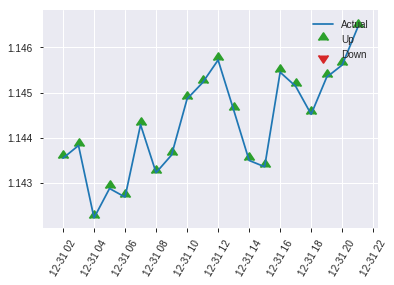


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25040840150767163
RMSE: 0.5004082348519773
LogLoss: 0.6939705806584522
Null degrees of freedom: 616
Residual degrees of freedom: 76
Null deviance: 855.3607874834584
Residual deviance: 856.35969653253
AIC: 1938.35969653253
AUC: 0.5281978276916588
pr_auc: 0.5559406043674155
Gini: 0.05639565538331759
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4294098896215227: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    290  1        (290.0/290.0)
1      0    327  0        (0.0/327.0)
Total  0    617  0.47     (290.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.42941      0.692797   399
max f2                       0.42941      0.849351   399
max f0point5                 0.42941      0.584973   399
max accuracy                 0.483806     0.552674   218
max precision                0.574574     1          0
max recall                   0.42941      1          399
max specificity              0.574574     1          0
max absolute_mcc             0.483806     0.0997647  218
max min_per_class_accuracy   0.487032     0.524138   199
max mean_per_class_accuracy  0.483806     0.549694   218

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 48.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.540619           1.34775   1.34775            0.714286         0.550875  0.714286                    0.550875            0.0152905       0.0152905                  34.775    34.775
    2        0.0210697                   0.535583           1.57238   1.45142            0.833333         0.53876   0.769231                    0.545283            0.0152905       0.030581                   57.2375   45.1423
    3        0.0307942                   0.531044           0.62895   1.19169            0.333333         0.533315  0.631579                    0.541504            0.00611621      0.0366972                  -37.105   19.1695
    4        0.0405186                   0.527869           0.62895   1.05664            0.333333         0.529723  0.56                        0.538676            0.00611621      0.0428135                  -37.105   5.66361
    5        0.0502431                   0.526765           0.943425  1.03472            0.5              0.527298  0.548387                    0.536474            0.00917431      0.0519878                  -5.65749  3.47243
    6        0.100486                    0.517892           1.09559   1.06516            0.580645         0.522301  0.564516                    0.529388            0.0550459       0.107034                   9.55904   6.51573
    7        0.150729                    0.511585           1.09559   1.0753             0.580645         0.51433   0.569892                    0.524368            0.0550459       0.16208                    9.55904   7.53017
    8        0.200972                    0.507537           0.973858  1.04994            0.516129         0.50967   0.556452                    0.520694            0.0489297       0.211009                   -2.61419  4.99408
    9        0.299838                    0.500161           1.05169   1.05052            0.557377         0.5043    0.556757                    0.515288            0.103976        0.314985                   5.1687    5.05166
    10       0.400324                    0.493074           1.15646   1.07711            0.612903         0.496733  0.57085                     0.510631            0.116208        0.431193                   15.6457   7.71088
    11       0.50081                     0.487051           0.943425  1.05029            0.5              0.490214  0.556634                    0.506534            0.0948012       0.525994                   -5.65749  5.02855
    12       0.599676                    0.480769           1.05169   1.05052            0.557377         0.48388   0.556757                    0.502799            0.103976        0.629969                   5.1687    5.05166
    13       0.700162                    0.474571           0.852126  1.02204            0.451613         0.477528  0.541667                    0.499172            0.0856269       0.715596                   -14.7874  2.20438
    14       0.799028                    0.467702           0.742367  0.987439           0.393443         0.471473  0.523327                    0.495745            0.0733945       0.788991                   -25.7633  -1.25612
    15       0.899514                    0.458407           1.06516   0.996121           0.564516         0.463694  0.527928                    0.492165            0.107034        0.896024                   6.51573   -0.387911
    16       1                           0.42941            1.03472   1                  0.548387         0.449988  0.529984                    0.487926       

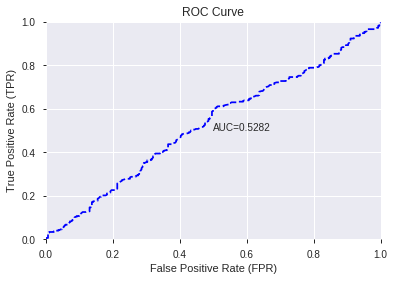

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


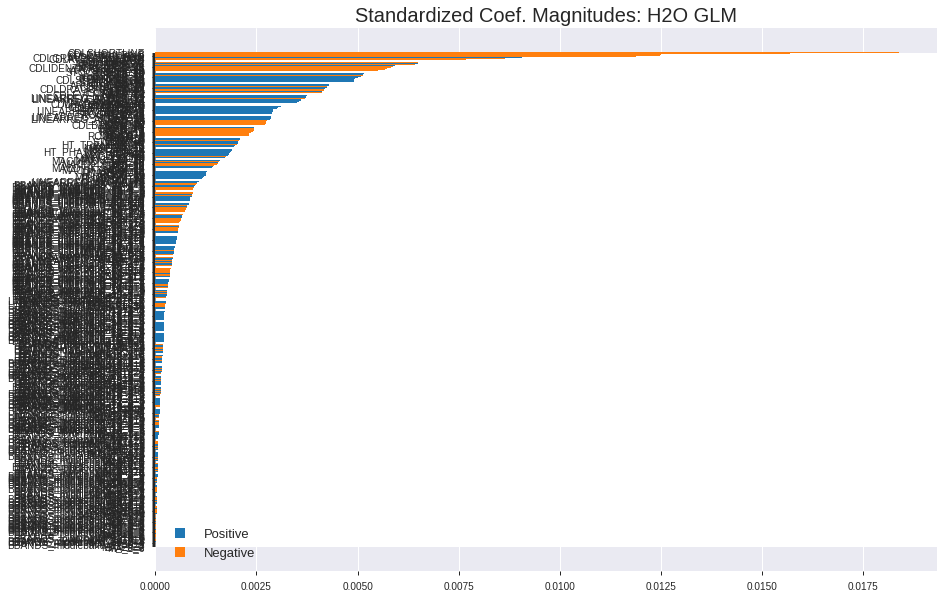

'log_likelihood'
--2019-07-25 07:37:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_073657_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_073657_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLSHORTLINE',
 'aroonup_8',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'BOP',
 'CDLGRAVESTONEDOJI',
 'CDLRICKSHAWMAN',
 'TRANGE',
 'CDLONNECK',
 'aroondown_20',
 'CDLHARAMI',
 'AROONOSC_8',
 'STDDEV_24',
 'STOCHF_fastk',
 'aroondown_30',
 'ADOSC',
 'CDLIDENTICAL3CROWS',
 'AROONOSC_20',
 'aroonup_14',
 'STOCHRSI_fastd',
 'BETA_30',
 'aroonup_12',
 'MFI_20',
 'BETA_12',
 'aroondown_24',
 'aroondown_12',
 'DX_14',
 'CORREL_24',
 'aroonup_30',
 'CDLSPINNINGTOP',
 'STOCH_slowd',
 'DX_20',
 'CDLINNECK',
 'BETA_20',
 'AROONOSC_14',
 'STDDEV_20',
 'DX_12',
 'CDLHAMMER',
 'DX_24',
 'CDLDRAGONFLYDOJI',
 'BETA_24',
 'ULTOSC',
 'CORREL_20',
 'VAR_12',
 'NATR_12',
 'NATR_14',
 'CDLEVENINGSTAR',
 'ATR_12',
 'LINEARREG_ANGLE_12',
 'LINEARREG_SLOPE_12',
 'CDL3INSIDE',
 'BETA_14',
 'aroonup_24',
 'MACDFIX_hist_24',
 'VAR_30',
 'CDLHARAMICROSS',
 'CDLHIKKAKE',
 'NATR_20',
 'STDDEV_14',
 'CDLMARUBOZU',
 'CDLHIGHWAVE',
 'NATR_8',
 'LINEARREG_SLOPE_8',
 'STOCH_slowk',
 'MOM_24',
 'STOCHF_fastd',
 'ROCR100_24'

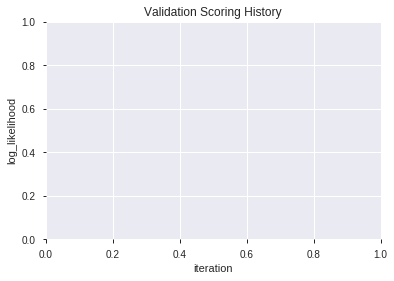

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_073826_model_6  0.558383  0.691729              0.494633  0.499218  0.249219
1               XGBoost_3_AutoML_20190725_073826  0.549678  0.688350              0.496357  0.497594  0.247600
2  XGBoost_grid_1_AutoML_20190725_073826_model_3  0.542212  0.694069              0.500000  0.500401  0.250401
3               XGBoost_2_AutoML_20190725_073826  0.542086  0.692945              0.496552  0.499847  0.249847
4  XGBoost_grid_1_AutoML_20190725_073826_model_4  0.540119  0.689633              0.494828  0.498245  0.248248
5  XGBoost_grid_1_AutoML_20190725_073826_model_1  0.535537  0.694028              0.484288  0.500277  0.250277
6  XGBoost_grid_1_AutoML_20190725_073826_model_2  0.527333  0.690986              0.496552  0.498916  0.248917
7               XGBoost_1_AutoML_20190725_073826  0.522308  0.701914              0.492908  0.503921  0.253937
8  XGBoost_grid_1_AutoML_20190725_073826_model_5  0.520843  0.715335              0.496552  0.509797  0.259893
9  XGBoost_grid_1_AutoML_20190725_073826_model_7  0.508911  0.702620              0.496357  0.504428  0.254447

variable  relative_importance  scaled_importance  percentage
0                       DX_8           190.678406           1.000000    0.019463
1                        BOP           185.521637           0.972956    0.018937
2                    BETA_30           184.416794           0.967161    0.018824
3                     MFI_12           179.623276           0.942022    0.018335
4                   STDDEV_8           135.529892           0.710777    0.013834
..                       ...                  ...                ...         ...
287                   RSI_24             3.773874           0.019792    0.000385
288  BBANDS_upperband_30_5_5             3.720691           0.019513    0.000380
289  BBANDS_upperband_20_1_3             3.412531           0.017897    0.000348
290  BBANDS_upperband_24_5_5             2.631934           0.013803    0.000269
291  BBANDS_upperband_20_2_5             2.596142           0.013615    0.000265

[292 rows x 4 columns]

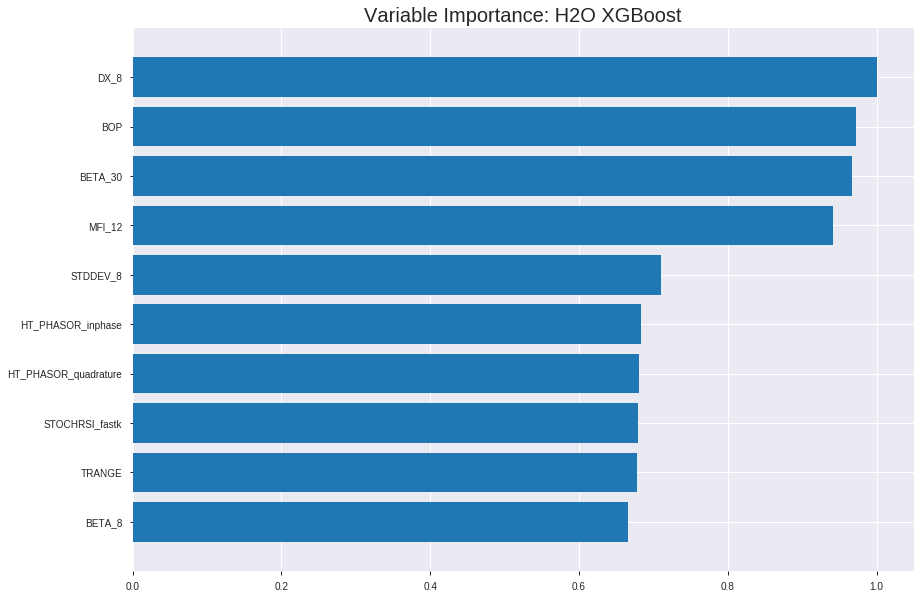

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_073826_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20830134380315515
RMSE: 0.4564004204677677
LogLoss: 0.6083888345486127
Mean Per-Class Error: 0.20584375482476447
AUC: 0.8772249669771671
pr_auc: 0.8786820616474614
Gini: 0.7544499339543342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49272841916364785: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1595  565   0.2616   (565.0/2160.0)
1      350   1809  0.1621   (350.0/2159.0)
Total  1945  2374  0.2119   (915.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492728     0.798147  212
max f2                       0.445254     0.872777  275
max f0point5                 0.52783      0.81478   161
max accuracy                 0.508839     0.794165  189
max precision                0.716685     1         0
max recall                   0.365065     1         355
max specificity              0.716685     1         0
max absolute_mcc             0.508839     0.590133  189
max min_per_class_accuracy   0.50186      0.788328  199
max mean_per_class_accuracy  0.508839     0.794156  189

Gains/Lift Table: Avg response rate: 49.99 %, avg score: 50.04 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.669035           2.00046    2.00046            1                0.687329  1                           0.687329            0.0203798       0.0203798                  100.046   100.046
    2        0.0201436                   0.650382           1.95394    1.97747            0.976744         0.659201  0.988506                    0.673427            0.0194535       0.0398333                  95.3941   97.7469
    3        0.0300996                   0.642176           1.90742    1.9543             0.953488         0.645716  0.976923                    0.664261            0.0189903       0.0588235                  90.7418   95.4299
    4        0.0400556                   0.631877           2.00046    1.96577            1                0.636715  0.982659                    0.657414            0.0199166       0.0787402                  100.046   96.5773
    5        0.0500116                   0.623733           1.90742    1.95416            0.953488         0.628188  0.976852                    0.651596            0.0189903       0.0977304                  90.7418   95.4156
    6        0.100023                    0.594515           1.93563    1.94489            0.967593         0.607694  0.972222                    0.629645            0.0968041       0.194535                   93.5633   94.4895
    7        0.150035                    0.578815           1.90785    1.93255            0.953704         0.586091  0.966049                    0.615127            0.0954145       0.289949                   90.7849   93.2546
    8        0.200046                    0.562907           1.8245     1.90553            0.912037         0.570759  0.952546                    0.604035            0.0912459       0.381195                   82.4497   90.5534
    9        0.300069                    0.540791           1.61148    1.80752            0.805556         0.551152  0.903549                    0.586407            0.161186        0.542381                   61.1484   80.7517
    10       0.400093                    0.521932           1.39384    1.7041             0.696759         0.531522  0.851852                    0.572686            0.139416        0.681797                   39.3841   70.4098
    11       0.500116                    0.501301           1.07895    1.57907            0.539352         0.510966  0.789352                    0.560342            0.10792         0.789717                   7.89535   57.9069
    12       0.599907                    0.483602           0.812253   1.45151            0.406032         0.492409  0.725589                    0.549041            0.081056        0.870774                   -18.7747  45.1513
    13       0.699931                    0.463094           0.65756    1.33805            0.328704         0.473756  0.668872                    0.538283            0.0657712       0.936545                   -34.244   33.8054
    14       0.799954                    0.437062           0.39361    1.21996            0.196759         0.450443  0.609841                    0.5273              0.0393701       0.975915                   -60.639   21.9964
    15       0.899977                    0.401787           0.189859   1.10548            0.0949074        0.420965  0.552611                    0.515482            0.0189903       0.994905                   -81.0141  10.5478
    16       1                           0.230276           0.0509377  1                  0.025463         0.364777  0.499884                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25720556004957706
RMSE: 0.5071543749683888
LogLoss: 0.708211406759369
Mean Per-Class Error: 0.46152462009272754
AUC: 0.5298658996283017
pr_auc: 0.5267638595005645
Gini: 0.059731799256603324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3836526572704315: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    610   0.9855   (610.0/619.0)
1      3    612   0.0049   (3.0/615.0)
Total  12   1222  0.4968   (613.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383653     0.666304  388
max f2                       0.278857     0.832431  399
max f0point5                 0.417527     0.556887  374
max accuracy                 0.602157     0.538898  146
max precision                0.684292     0.607143  31
max recall                   0.278857     1         399
max specificity              0.745672     0.998384  0
max absolute_mcc             0.602157     0.079712  146
max min_per_class_accuracy   0.57699      0.52504   187
max mean_per_class_accuracy  0.602157     0.538475  146

Gains/Lift Table: Avg response rate: 49.84 %, avg score: 57.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.716606           0.617386  0.617386           0.307692         0.729158  0.307692                    0.729158            0.00650407      0.00650407                 -38.2614  -38.2614
    2        0.0202593                   0.69935            1.50488   1.04338            0.75             0.707004  0.52                        0.718524            0.0146341       0.0211382                  50.4878   4.33821
    3        0.0299838                   0.693016           1.33767   1.13883            0.666667         0.695704  0.567568                    0.711123            0.0130081       0.0341463                  33.7669   13.8827
    4        0.0405186                   0.686312           1.08043   1.12364            0.538462         0.690431  0.56                        0.705743            0.0113821       0.0455285                  8.04253   12.3642
    5        0.0502431                   0.681093           1.33767   1.16507            0.666667         0.683587  0.580645                    0.701455            0.0130081       0.0585366                  33.7669   16.5067
    6        0.100486                    0.661301           1.19743   1.18125            0.596774         0.669586  0.58871                     0.68552             0.0601626       0.118699                   19.743    18.1248
    7        0.149919                    0.646443           1.05259   1.13883            0.52459          0.653323  0.567568                    0.674904            0.0520325       0.170732                   5.25923   13.8827
    8        0.200162                    0.634283           1.03562   1.11292            0.516129         0.640337  0.554656                    0.666227            0.0520325       0.222764                   3.5615    11.2919
    9        0.299838                    0.615216           1.04403   1.09002            0.520325         0.625325  0.543243                    0.65263             0.104065        0.326829                   4.40346   9.00198
    10       0.400324                    0.59597            1.03562   1.07636            0.516129         0.605889  0.536437                    0.640897            0.104065        0.430894                   3.5615    7.63635
    11       0.5                         0.576882           0.962469  1.05366            0.479675         0.586047  0.525122                    0.629963            0.095935        0.526829                   -3.75306  5.36585
    12       0.599676                    0.557754           0.91353   1.03037            0.455285         0.56723   0.513514                    0.619536            0.0910569       0.617886                   -8.64697  3.0367
    13       0.700162                    0.53501            0.889982  1.01022            0.443548         0.546043  0.503472                    0.608988            0.0894309       0.707317                   -11.0018  1.02191
    14       0.799838                    0.507709           0.864591  0.992071           0.430894         0.522692  0.494428                    0.598234            0.0861789       0.793496                   -13.5409  -0.792909
    15       0.899514                    0.467363           1.02772   0.996021           0.512195         0.488549  0.496396                    0.58608             0.102439        0.895935                   2.77216   -0.397861
    16       1                           0.278857           1.03562   1                  0.516129         0.431449  0.498379                    0.570541     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 07:39:19  30.198 sec  0                  0.5              0.693147            0.5             0                  1                0.500116                         0.5                0.693147              0.5               0                    1                  0.501621
    2019-07-25 07:39:20  30.870 sec  5                  0.494995         0.683175            0.680919        0.683883           1.86407          0.420699                         0.500635           0.69442               0.488786          0.494084             1.12866            0.498379
    2019-07-25 07:39:20  31.094 sec  10                 0.489371         0.672065            0.753355        0.742643           1.8186           0.360269                         0.500702           0.694562              0.50693           0.501846             0.926079           0.501621
    2019-07-25 07:39:20  31.363 sec  15                 0.484925         0.663329            0.778101        0.772531           1.955            0.330169                         0.500563           0.694289              0.522473          0.522252             0.926079           0.501621
    2019-07-25 07:39:20  31.619 sec  20                 0.481455         0.656534            0.78786         0.781823           1.90953          0.311183                         0.50113            0.695457              0.527563          0.520823             0.926079           0.50081
    2019-07-25 07:39:21  31.874 sec  25                 0.477648         0.649128            0.806754        0.798138           1.86407          0.303542                         0.501208           0.695632              0.532225          0.526706             1.08043            0.501621
    2019-07-25 07:39:21  32.138 sec  30                 0.472996         0.640102            0.822137        0.813572           1.90953          0.278074                         0.501344           0.695911              0.533131          0.529259             1.23477            0.498379
    2019-07-25 07:39:21  32.425 sec  35                 0.469044         0.632471            0.835873        0.830782           2.00046          0.262792                         0.502827           0.698983              0.537502          0.533534             1.08043            0.497569
    2019-07-25 07:39:22  32.707 sec  40                 0.464854         0.62445             0.850956        0.847856           1.955            0.244038                         0.502813           0.698981              0.538464          0.533111             1.08043            0.498379
    2019-07-25 07:39:22  32.990 sec  45                 0.461018         0.617119            0.861278        0.861074           2.00046          0.235471                         0.505916           0.705525              0.531904          0.529949             0.926079           0.497569
    2019-07-25 07:39:22  33.288 sec  50                 0.4564           0.608389            0.877225        0.878682           2.00046          0.211855                         0.507154           0.708211              0.529866          0.526764             0.617386           0.496759

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
DX_8                     190.67840576171875     1.0                   0.01946297815302758
BOP                      185.52163696289062     0.9729556748797644    0.01893661504404906
BETA_30                  184.4167938232422      0.9671613997743332    0.018823841194259422
MFI_12                   179.62327575683594     0.94202211854709      0.01833455591295077
STDDEV_8                 135.52989196777344     0.7107773500956283    0.01383384403657805
---                      ---                    ---                   ---
RSI_24                   3.773873805999756      0.019791825880460617  0.0003852078747199308
BBANDS_upperband_30_5_5  3.7206907272338867     0.019512910821603193  0.00037977935702283844
BBANDS_upperband_20_1_3  3.4125313758850098     0.01789678994982515   0.00034832483180277044
BBANDS_upperband_24_5_5  2.6319336891174316     0.01380299818746349   0.00026864745216888117
BBANDS_upperband_20_2_5  2.596142292022705      0.01361529262661748   0.0002649941429389335


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5623987034035657)

('F1', 0.6943556975505857)

('auc', 0.5583834229674154)

('logloss', 0.6917286715635136)

('mean_per_class_error', 0.45347463882737526)

('rmse', 0.49921830694391534)

('mse', 0.24921891798794926)

xgboost prediction progress: |████████████████████████████████████████████| 100%


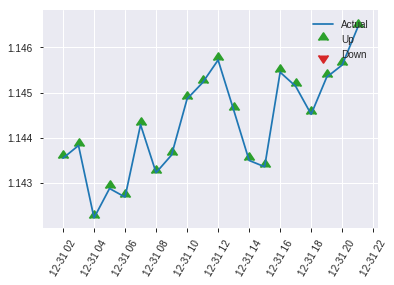


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24921891798794926
RMSE: 0.49921830694391534
LogLoss: 0.6917286715635136
Mean Per-Class Error: 0.45347463882737526
AUC: 0.5583834229674154
pr_auc: 0.5886366570520765
Gini: 0.11676684593483078
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4202941060066223: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    286  0.9862   (286.0/290.0)
1      1    326  0.0031   (1.0/327.0)
Total  5    612  0.4652   (287.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420294     0.694356  395
max f2                       0.394847     0.849792  398
max f0point5                 0.504909     0.598661  345
max accuracy                 0.537508     0.562399  301
max precision                0.680724     0.769231  23
max recall                   0.394847     1         398
max specificity              0.732059     0.996552  0
max absolute_mcc             0.666705     0.136432  44
max min_per_class_accuracy   0.588856     0.531034  192
max mean_per_class_accuracy  0.653758     0.546525  64

Gains/Lift Table: Avg response rate: 53.00 %, avg score: 58.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.706288           1.0782    1.0782             0.571429         0.720073  0.571429                    0.720073            0.0122324       0.0122324                  7.82001   7.82001
    2        0.0210697                   0.692838           1.57238   1.30628            0.833333         0.700706  0.692308                    0.711134            0.0152905       0.0275229                  57.2375   30.6281
    3        0.0307942                   0.684919           1.2579    1.291              0.666667         0.688483  0.684211                    0.703981            0.0122324       0.0397554                  25.79     29.1003
    4        0.0405186                   0.680967           1.88685   1.43401            1                0.68302   0.76                        0.69895             0.0183486       0.058104                   88.685    43.4006
    5        0.0502431                   0.679139           0.62895   1.27819            0.333333         0.680016  0.677419                    0.695286            0.00611621      0.0642202                  -37.105   27.8189
    6        0.100486                    0.664243           1.46079   1.36949            0.774194         0.672037  0.725806                    0.683661            0.0733945       0.137615                   46.0787   36.9488
    7        0.150729                    0.65216            1.09559   1.27819            0.580645         0.657485  0.677419                    0.674936            0.0550459       0.192661                   9.55904   27.8189
    8        0.200972                    0.642269           0.79126   1.15646            0.419355         0.646909  0.612903                    0.667929            0.0397554       0.232416                   -20.874   15.6457
    9        0.299838                    0.624387           1.02076   1.11171            0.540984         0.632178  0.589189                    0.656141            0.100917        0.333333                   2.0755    11.1712
    10       0.400324                    0.606273           1.00429   1.08475            0.532258         0.615554  0.574899                    0.645953            0.100917        0.434251                   0.429121  8.47479
    11       0.50081                     0.588887           0.973858  1.0625             0.516129         0.597091  0.563107                    0.636149            0.0978593       0.53211                    -2.61419  6.24981
    12       0.599676                    0.575766           0.897027  1.03522            0.47541          0.582217  0.548649                    0.627257            0.088685        0.620795                   -10.2973  3.52178
    13       0.700162                    0.560491           0.973858  1.02641            0.516129         0.568884  0.543981                    0.61888             0.0978593       0.718654                   -2.61419  2.64115
    14       0.799028                    0.537851           1.20635   1.04868            0.639344         0.550889  0.555781                    0.610467            0.119266        0.83792                    20.6347   4.86753
    15       0.899514                    0.503195           0.912992  1.03352            0.483871         0.521481  0.547748                    0.600526            0.0917431       0.929664                   -8.7008   3.35179
    16       1                           0.389016           0.699961  1                  0.370968         0.466979  0.529984                    0.587107         

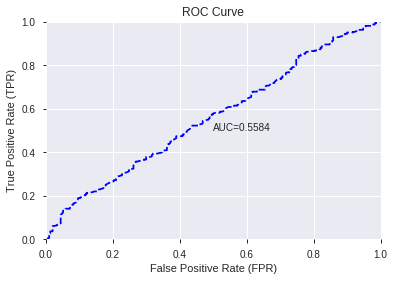

This function is available for GLM models only


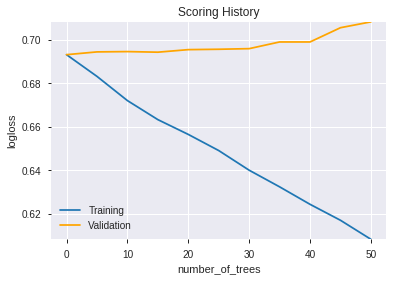

--2019-07-25 07:39:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_073826_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_073826_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b093',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['DX_8',
 'BOP',
 'BETA_30',
 'MFI_12',
 'STDDEV_8',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'TRANGE',
 'BETA_8',
 'BETA_12',
 'ULTOSC',
 'CCI_8',
 'MFI_20',
 'MACDEXT_signal',
 'STOCH_slowd',
 'DX_30',
 'OBV',
 'ADOSC',
 'MFI_14',
 'LINEARREG_ANGLE_20',
 'ROCP_8',
 'ATR_30',
 'AROONOSC_14',
 'MINUS_DI_30',
 'MACDEXT_hist',
 'WILLR_8',
 'STDDEV_20',
 'LINEARREG_ANGLE_14',
 'STOCHRSI_fastd',
 'CCI_14',
 'BETA_20',
 'aroonup_8',
 'STOCHF_fastk',
 'WILLR_14',
 'CDLSHORTLINE',
 'MINUS_DI_8',
 'TRIX_8',
 'PLUS_DM_8',
 'DX_24',
 'CCI_12',
 'PPO',
 'CCI_20',
 'WILLR_20',
 'WILLR_12',
 'AROONOSC_8',
 'AROONOSC_24',
 'CORREL_30',
 'NATR_20',
 'LINEARREG_SLOPE_8',
 'MFI_30',
 'ADXR_12',
 'ADX_8',
 'MACDFIX_signal_20',
 'DX_12',
 'ADX_20',
 'NATR_24',
 'aroonup_20',
 'MINUS_DM_8',
 'MINUS_DI_20',
 'aroonup_24',
 'PLUS_DI_20',
 'VAR_30',
 'aroonup_14',
 'MOM_24',
 'CMO_30',
 'AROONOSC_12',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_24_7_5',
 'BETA_14',
 'BETA_24',
 'PLUS_DM_2

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.562
GLM             0.553
XGBoost         0.562
dtype: float64

DeepLearning    GLM  XGBoost
All          0.556  0.543    0.562
DLF          0.562  0.536    0.551
Fwe          0.548  0.543    0.562
RFE          0.543  0.553    0.562
XGBF         0.546  0.536    0.551





F1


DeepLearning    0.696
GLM             0.696
XGBoost         0.695
dtype: float64

DeepLearning    GLM  XGBoost
All          0.696  0.694    0.695
DLF          0.693  0.696    0.693
Fwe          0.696  0.694    0.695
RFE          0.695  0.693    0.694
XGBF         0.694  0.696    0.693





auc


DeepLearning    0.554
GLM             0.538
XGBoost         0.558
dtype: float64

DeepLearning    GLM  XGBoost
All          0.554  0.538    0.546
DLF          0.546  0.532    0.545
Fwe          0.552  0.538    0.546
RFE          0.538  0.528    0.558
XGBF         0.534  0.532    0.545





logloss


DeepLearning    0.757
GLM             0.694
XGBoost         0.692
dtype: float64

DeepLearning    GLM  XGBoost
All          0.725  0.694    0.688
DLF          0.757  0.692    0.689
Fwe          0.722  0.694    0.688
RFE          0.700  0.694    0.692
XGBF         0.694  0.692    0.689





mean_per_class_error


DeepLearning    0.457
GLM             0.455
XGBoost         0.462
dtype: float64

DeepLearning    GLM  XGBoost
All          0.443  0.455    0.447
DLF          0.455  0.455    0.462
Fwe          0.453  0.455    0.447
RFE          0.455  0.450    0.453
XGBF         0.457  0.455    0.462





rmse


DeepLearning    0.520
GLM             0.500
XGBoost         0.499
dtype: float64

DeepLearning    GLM  XGBoost
All          0.514  0.500    0.498
DLF          0.520  0.499    0.498
Fwe          0.514  0.500    0.498
RFE          0.503  0.500    0.499
XGBF         0.500  0.499    0.498





mse


DeepLearning    0.271
GLM             0.250
XGBoost         0.249
dtype: float64

DeepLearning    GLM  XGBoost
All          0.264  0.250    0.248
DLF          0.271  0.249    0.248
Fwe          0.264  0.250    0.248
RFE          0.253  0.250    0.249
XGBF         0.250  0.249    0.248

{'F1':       DeepLearning    GLM  XGBoost
 All          0.696    NaN      NaN
 DLF          0.693    NaN      NaN
 DLF            NaN  0.696      NaN
 DLF            NaN    NaN    0.693
 All            NaN  0.694      NaN
 All            NaN    NaN    0.695
 XGBF         0.694    NaN      NaN
 XGBF           NaN  0.696      NaN
 XGBF           NaN    NaN    0.693
 Fwe          0.696    NaN      NaN
 Fwe            NaN  0.694      NaN
 Fwe            NaN    NaN    0.695
 RFE          0.695    NaN      NaN
 RFE            NaN  0.693      NaN
 RFE            NaN    NaN    0.694,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.556    NaN      NaN
 DLF          0.562    NaN      NaN
 DLF            NaN  0.536      NaN
 DLF            NaN    NaN    0.551
 All            NaN  0.543      NaN
 All            NaN    NaN    0.562
 XGBF         0.546    NaN      NaN
 XGBF           NaN  0.536      NaN
 XGBF           NaN    NaN    0.551
 Fwe          0.548    NaN      NaN
 Fwe     